# housekeeping

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, TheilSenRegressor
import os
from datetime import datetime
from datetime import date
import npd_wraper as npd
import plotly.express as px
import plotly.graph_objects as go  
import sys
import colorsys
import json
from scipy import stats
from copy import deepcopy

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, RegularGridInterpolator

from utils import get_field_status,get_field_overview,\
    get_field_inplace_volumes, get_field_reserves, \
        get_production_yearly, get_production_monthly,\
            get_field_description, get_all_wells

import matplotlib.pyplot as plt
import scipy.stats as stats

# The unicellar is available at https://github.com/alex11818/unicellar
from submodules.unicellar.unicellar.plotters import multiplot
from submodules.unicellar.unicellar.helpers import get_fluid_properties

In [3]:
os.makedirs('./figures',exist_ok=True)
recreate_figures = True
recreate_figures = False

update_data = True
update_data = False

In [4]:
cc_ft2m, cc_psi2bar = .3048, 0.0689476  # m, bar
p_atm = 1.01325
def f_degF2degC(degF):
    return (degF-32)*5/9

# references

1. Norwegian Offshore Directorate. Factpages. https://factpages.sodir.no, (retrieved October 5, 2024).

2. DISKOS data repository (public portal). https://www.diskos.com, (retrieved October 5, 2024).

3. Eric W. Lemmon, Ian H. Bell, Marcia L. Huber, and Mark O. McLinden, **"Thermophysical Properties of Fluid Systems" in NIST Chemistry WebBook**, NIST Standard Reference Database Number 69, Eds. P.J. Linstrom and W.G. Mallard, National Institute of Standards and Technology, Gaithersburg MD, 20899, https://doi.org/10.18434/T4D303, (retrieved October 5, 2024).

4. Moss, B, Barson, D, Rakhit, K, Dennis, H,  Swarbrick, R. 2003 Formation pore pressures and formation waters. 317- 329 in The Millennium Atlas:  petroleum geology of the central and northern North Sea.  Evans,  D, Graham, C ,Armour, A, and Bathurst, P  (editors and co-ordinators). (London: The Geological Society of London.)

5. **The Millennium atlas: petroleum geology of the central and northern North Sea**, London: Geological Society of London, 2003, ISBN 10: 186239119X  ISBN 13: 9781862391192

6. Alnes, H., Eiken, O., Nooner, S., Sasagawa, G., Stenvold, T., & Zumberge, M. (2011). **Results from Sleipner gravity monitoring: Updated density and temperature distribution of the CO2 plume.** Energy Procedia, 4, 5504–5511. https://doi.org/10.1016/j.egypro.2011.02.536

(other references are given below)

# functions

In [5]:
def generate_rainbow_colors(N, saturation=1.0, brightness=1.0, gap=.1):
    '''Generates N rainbow colors with specified saturation and brightness  
    which can be used in Plotly charts.

    Parameters
    ------------
    N : int
        number of colors

    saturation : float
        
    brightness : float

    gap : float
        if <1, prevents the far right part of the spectrum  from coinciding with 
        the violet one in the left   

    Returns
    -------
    colors: list of strings 
        e.g. ['rgb(255,0,0)', 'rgb(51,255,0)', 'rgb(0,102,255)']

    Example
    -------
    # Generates and plots 20 colors:
    N = 20
    rainbow_colors = generate_rainbow_colors(N)
    fig = go.Figure(
        data=[go.Bar(x=list(range(N)), y=[1]*N, marker_color=rainbow_colors)])
    fig.show()   
    '''
    colors = []
    mult = (1-gap)/N 
    for i in range(N):
        hue = mult*i 
        rgb = colorsys.hsv_to_rgb(hue, saturation, brightness)
        colors.append(f'rgb({rgb[0]*255:.0f},{rgb[1]*255:.0f},{rgb[2]*255:.0f})')

    return colors

In [6]:
def cross_plot(fig,percentages=[0,10,20]):
    dashes=['solid','dot','dash','longdash']
    D=fig.to_dict()['data']
    x_max=[]
    y_max=[]
    for r in D:
        # x = np.array(r['x'], dtype=float)
        # x = x[~np.isnan(x)]
        x = pd.Series(r['x'], dtype=float).dropna()
        x_max.append(x.max())

    x_max=max(x_max)
    # y_max=max(y_max)
    
    for p,dash in zip(percentages,dashes):

        mp=1+p/100
        mm=1-p/100
        # print(mp,mm)
        if p == 0:
            x = [0, x_max]
            y = [0, x_max]             
        else:
            x = [x_max, 0, x_max/mp]
            y = [x_max*mm, 0, x_max]             
            
        fig.add_trace(
            go.Scatter(
                x=x, y=y, mode='lines',
                name=f'+/- {p}%', 
                line=dict(color='dimgray', 
                          width=1, 
                          dash=dash)
            )
        )     
    return fig

# cross_plot(fig)
# fig.show(renderer='browser')

# field data

important notes on NPD reporting of reserves, resources and volumes:  
https://www.sodir.no/en/regulations/reporting_and_applications/revised-national-budget/

>*Note that the name of the deposit used in column B forms the basis for specifying the deposit in the various profile collections. The hydrocarbons are divided between oil, associated liquid (condensate), associated gas and/or free gas all independently of the sales products. Gas volumes shall be reported at the actual calorific value. All estimates shall be given with uncertainty, i.e., high (preferable P10), low (preferable P90) and base estimate (expected value). Information about risk spread, i.e., the probability that the outcome will be greater than, or equal to the low/high value shall be given at the top right of the table. These values should always apply when uncertainty is reported.*

>***The resources should be reported as sales products; oil, NGL, condensate and gas.** The sales products shall, to the greatest extent possible, be reported in the same way as they will be reported to The Norwegian Offshore Directorate (DISKOS – Saleable Production) in the regular monthly reporting. **This means that condensate sold as oil should be reported as oil, and associated liquid from gas fields shall be reported as oil if the liquid is sold as oil**. If any changes in definition of sales products during the operating period of a field, the date of the change should be reflected in the RNB reporting, meaning that the change should be reflected in the same way as reported to DISKOS (Saleable Production).*

>**In the table showing hydrocarbons originally in place, condensate should be reported as associated liquid, regardless of the sales product.**

>**Gas flared or used for fuel shall not be included in the resource base.***

## volume & reserves

In [7]:
volumes = get_field_inplace_volumes(update=update_data)
reserves = get_field_reserves(update=update_data)

for df in [reserves, volumes]:
    df.set_index('fldNpdidField',inplace=True, drop=True)
    df.index.rename('fldID',inplace=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)    

df = pd.concat([reserves,volumes],axis=1,join='inner')
df = df.loc[:,~df.columns.duplicated(keep='first')]
df = df.rename(columns={i: i.replace('fld','') for i in df.columns})

df['RF oil']= None
ind = df['InplaceOil']>0
df.loc[ind,'RF oil'] = (df.loc[ind,'RecoverableOil']/df.loc[ind,'InplaceOil']).round(3) 

df['GIIP'] = df['InplaceFreeGas']+df['InplaceAssGas']
df['RF gas']=df['RecoverableGas']/df['GIIP']
df['RF gas'] = df['RF gas'].round(4) 
df['maturity oil'] = np.nan
df.loc[ind,'maturity oil']= \
(1-df.loc[ind,'RemainingOil']/df.loc[ind,'RecoverableOil']).round(3) 

clmns_dict = {\
'Name': 'field', 
'RecoverableGas': 'rec. gas',  
'RecoverableOil': 'rec. oil', 
'RecoverableNGL': 'rec. NGL',
'RecoverableCondensate': 'rec. cond.',
'RecoverableOE': 'rec. OE', 
'RemainingOil': 'rem. oil',
'RemainingNGL': 'rem. NGL',
'RemainingCondensate': 'rem. cond.', 
'RemainingGas': 'rem. gas', 
'RemainingOE': 'rem. OE', 
'DatesyncNPD': 'DatesyncNPD',
'DateOffResEstDisplay': 'DateOffResEstDisplay', 
'InplaceFreeGas': 'in-place free gas',
'InplaceAssGas': 'in-place ass. gas',
'InplaceAssLiquid': 'in-place ass. liquid', 
'InplaceOil': 'STOIIP', 
'GIIP': 'GIIP', 
'RF_oil': 'oil RF',
'RF_gas': 'gas RF',
'RF_liq.': 'liq. RF',
'maturity oil': 'maturity oil',
'maturity gas': 'maturity gas',
'maturity liq.': 'maturity liq.',
'maturity OE': 'maturity OE',
}

df = df.drop(columns=['DateOffResEstDisplay','DatesyncNPD'])
df = df.rename(columns=clmns_dict)

# converting NGL from tonnes to Sm3
df['rem. NGL'] = 1.9*df['rem. NGL']
df['rec. NGL'] = 1.9*df['rec. NGL']

df['in-place liq.']=df['STOIIP'] + df['in-place ass. liquid']

df['in-place OE'] = df['in-place liq.'] + \
    (df['GIIP'] + df['in-place ass. gas'])

df['in-place liq./OE ratio']=\
    ((df['STOIIP']+df['in-place ass. liquid']) / df['in-place OE']).round(3) 

df['in-place free gas/OE ratio']=\
(df['in-place free gas'] / df['in-place OE']).round(3) 

df['rec. ass. liq.']=df['rec. NGL']+df['rec. cond.']
df['rem. ass. liq.']=df['rem. NGL']+df['rem. cond.']

df['rec. liq.']=df['rec. oil']+df['rec. ass. liq.']
df['rem. liq.']=df['rem. oil']+df['rem. ass. liq.']
df['RF liq.']=(df['rec. liq.']/df['in-place liq.']).round(3) 

df['GOR'] = None

df['maturity gas']= (1-df['rem. gas']/df['rec. gas']).round(3) 
df['maturity OE']= (1-df['rem. OE']/df['rec. OE']).round(3) 
df['maturity liq.']= (1-df['rem. liq.']/df['rec. liq.']).round(3) 

df = df[['rec. oil', 'rec. gas', 'rec. ass. liq.', 'rec. OE',
    'rem. oil', 'rem. gas', 'rem. ass. liq.', 'rem. OE', 
    'STOIIP', 'GIIP', 'GOR',
    'in-place ass. liquid', 
    'in-place ass. gas', 
    'in-place free gas', 
    'in-place OE',
    'in-place liq./OE ratio',
    'in-place free gas/OE ratio',
    'RF oil', 'RF gas', 'RF liq.',
    'maturity oil','maturity gas','maturity OE','maturity liq.',
    'field']]

# shortcut for in-place columns to be used later
clmns_inplace=[
    'STOIIP', 'GIIP', 'GOR', 'in-place ass. liquid', 
    'in-place ass. gas', 'in-place free gas', 'in-place OE']

df.head(10)
df = df.set_index('field', drop=False)

In [8]:
reserves = get_field_reserves(update=update_data)

## GOR estimation

In [9]:
ind = (df['STOIIP']>0.0) & (df['in-place ass. gas']>0.0)
df.loc[ind,'GOR']=(df.loc[ind,'in-place ass. gas']/df.loc[ind,'STOIIP']*1000).round(1)
df.loc[ind,clmns_inplace]

STOIIP   GIIP    GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                       
ALVE           5.0   19.0  400.0                   6.0                2.0   
ALVE NORD     17.0   18.0  235.3                   5.0                4.0   
ALVHEIM      124.0   32.0   96.8                   1.0               12.0   
BALDER       280.0   15.0   53.6                   0.0               15.0   
BAUGE         16.0    5.0  312.5                   0.0                5.0   
...            ...    ...    ...                   ...                ...   
VISUND SØR    13.0   12.0  230.8                   4.0                3.0   
VOLUND        22.0    4.0   90.9                   0.0                2.0   
VOLVE         19.0    3.0  157.9                   0.0                3.0   
YME           57.0    3.0   52.6                   0.0                3.0   
ÅSGARD       198.0  394.0  292.9                 202.0               58.0   

            in-place free gas  in-place OE  
field                                       
ALVE                     17.0         32.0  
ALVE NORD                14.0         44.0  
ALVHEIM                  20.0        169.0  
BALDER                    0.0        310.0  
BAUGE                     0.0         26.0  
...                       ...          ...  
VISUND SØR                9.0         32.0  
VOLUND                    2.0         28.0  
VOLVE                     0.0         25.0  
YME                       0.0         63.0  
ÅSGARD                  336.0        852.0  

[92 rows x 7 columns]

Some oil fields have zero in-place ass. gas.

In [10]:
df.loc[(df['in-place ass. gas']==0)&(df['STOIIP']>0), clmns_inplace]

STOIIP   GIIP   GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                          
ALBUSKJELL        56.0   56.0  None                  40.0                0.0   
BLANE              3.0    0.0  None                   0.0                0.0   
BRYNHILD           6.0    0.0  None                   0.0                0.0   
ENOCH              2.0    0.0  None                   0.0                0.0   
GLITNE            20.0    1.0  None                   0.0                0.0   
HALTEN ØST         3.0   16.0  None                   5.0                0.0   
HEIMDAL           11.0   61.0  None                   0.0                0.0   
IDUN NORD          1.0    4.0  None                   0.0                0.0   
JETTE              3.0    0.0  None                   0.0                0.0   
JOHAN CASTBERG   175.0    0.0  None                   0.0                0.0   
KRISTIN           70.0  121.0  None                  19.0                0.0   
ORMEN LANGE        1.0  398.0  None                  37.0                0.0   
SKIRNE             5.0   15.0  None                   0.0                0.0   
SKOGUL             3.0    0.0  None                   0.0                0.0   
TUNE               2.0   22.0  None                  11.0                0.0   
TYRVING           10.0    0.0  None                   0.0                0.0   
ÆRFUGL NORD        1.0    6.0  None                   0.0                0.0   
AASTA HANSTEEN     4.0   84.0  None                   1.0                0.0   

                in-place free gas  in-place OE  
field                                           
ALBUSKJELL                   56.0        152.0  
BLANE                         0.0          3.0  
BRYNHILD                      0.0          6.0  
ENOCH                         0.0          2.0  
GLITNE                        1.0         21.0  
HALTEN ØST                   16.0         24.0  
HEIMDAL                      61.0         72.0  
IDUN NORD                     4.0          5.0  
JETTE                         0.0          3.0  
JOHAN CASTBERG                0.0        175.0  
KRISTIN                     121.0        210.0  
ORMEN LANGE                 398.0        436.0  
SKIRNE                       15.0         20.0  
SKOGUL                        0.0          3.0  
TUNE                         22.0         35.0  
TYRVING                       0.0         10.0  
ÆRFUGL NORD                   6.0          7.0  
AASTA HANSTEEN               84.0         89.0

## descriptions 

In [11]:
if 'HPHT' not in df.columns:
    descr = get_field_description(update=update_data)
    descr = descr.rename(
        columns={'fldDescriptionText': 'text', 
                 'fldDescriptionHeading': 'key',
                 'fldName': 'field', 'fldNpdidField': 'fldID'                 
                 })
    descr.set_index('field', inplace=True)

    res_descr = descr[descr['key'] == 'Reservoir']['text'].copy()
    res_descr.rename('reservoir', inplace=True)
    rs_descr = descr[descr['key'] == 'Recovery strategy']['text'].copy()
    rs_descr.rename('recovery', inplace=True)

    df['HPHT']=False
    df['res. quality'] = None
    df['faulted'] = None

    for f in res_descr.index:
        dtext = res_descr.loc[f] 
        if 'HPHT' in dtext:
            df.loc[f,'HPHT'] = True
            print(dtext)
        pass

    df = df.join(res_descr)
    df = df.join(rs_descr)
    df

Berling contains gas and condensate. The Berling Garn reservoir is in the Middle Jurassic Garn Formation. It is at a depth of 4100 metres and has high pressure and high temperature (HPHT). The reservoir is structurally complex and has varying reservoir quality. The Berling Breiflabb reservoir is in intra-Lange Formation turbidite sandstone of Late Cretaceous age at a depth of 3900 metres.
Brynhild produced oil from sandstone of Late Jurassic age in the Ula Formation. The reservoir is at a depth of 3300 metres, and the reservoir conditions are close to high pressure, high temperature (HPHT) conditions.
Dvalin contains gas in Middle Jurassic sandstone in the Ile and Garn Formations. The reservoirs are at a depth of 4500 metres and have high pressure and high temperature (HPHT). The homogeneous shallow marine Garn sandstone has good reservoir quality, while the more heterogeneous and fine-grained Ile sandstone has less favourable reservoir properties.
Embla produces oil and gas from segme

In [12]:
ovv=get_field_overview(update=update_data)
ovv

fldName                    cmpLongName  fldCurrentActivitySatus  \
0        ALBUSKJELL  ConocoPhillips Skandinavia AS                Shut down   
1              ALVE              Equinor Energy AS                Producing   
2         ALVE NORD                    Aker BP ASA  Approved for production   
3           ALVHEIM                    Aker BP ASA                Producing   
4              ATLA      TotalEnergies EP Norge AS                Shut down   
..              ...                            ...                      ...   
135     ÆRFUGL NORD                    Aker BP ASA                Producing   
136             ØRN                    Aker BP ASA  Approved for production   
137       ØST FRIGG                    Aker BP ASA                Shut down   
138          ÅSGARD              Equinor Energy AS                Producing   
139  AASTA HANSTEEN              Equinor Energy AS                Producing   

         wlbName wlbCompletionDate    fldMainArea               fldOwnerKind  \
0          1/6-1        26.11.1972      North sea         PRODUCTION LICENSE   
1       6507/3-1        26.10.1990  Norwegian sea         PRODUCTION LICENSE   
2    6607/12-2 S        25.10.2011  Norwegian sea         PRODUCTION LICENSE   
3         24/6-2        08.07.1998      North sea         PRODUCTION LICENSE   
4         25/5-7        23.10.2010      North sea         PRODUCTION LICENSE   
..           ...               ...            ...                        ...   
135   6507/3-9 S        15.07.2012  Norwegian sea         PRODUCTION LICENSE   
136   6507/2-5 S        14.09.2019  Norwegian sea         PRODUCTION LICENSE   
137       25/2-1        21.09.1973      North sea         PRODUCTION LICENSE   
138    6507/11-1        10.12.1981  Norwegian sea  BUSINESS ARRANGEMENT AREA   
139    6707/10-1        23.07.1997  Norwegian sea         PRODUCTION LICENSE   

    fldOwnerName fldMainSupplyBase       fldHcType  fldNpdidOwner  \
0            018               NaN  GAS/CONDENSATE        20900.0   
1          159 B      Sandnessjøen  GAS/CONDENSATE      2819945.0   
2          127 C               NaN         OIL/GAS     29427330.0   
3            203               NaN         OIL/GAS        22436.0   
4          102 C               NaN  GAS/CONDENSATE      5467035.0   
..           ...               ...             ...            ...   
135        212 E      Sandnessjøen  GAS/CONDENSATE      4966902.0   
136          942               NaN             GAS     30676176.0   
137          873               NaN             GAS     28973585.0   
138  ÅSGARD UNIT      Kristiansund  GAS/CONDENSATE        40564.0   
139          218      Sandnessjøen             GAS        22556.0   

     fldNpdidField  wlbNpdidWellbore  cmpNpdidCompany  \
0            43437               239        2410696.0   
1          4444332              1533       32011216.0   
2         42002483              6642       28544099.0   
3          2845712              3397       28544099.0   
4         21106284              6423       35000016.0   
..             ...               ...              ...   
135       38542241              6951       28544099.0   
136       42002484              8775       28544099.0   
137          43576               353       28544099.0   
138          43765                68       32011216.0   
139       23395946              3075       32011216.0   

                                        fldFactPageUrl  \
0    https://factpages.sodir.no/factpages/default.a...   
1    https://factpages.sodir.no/factpages/default.a...   
2    https://factpages.sodir.no/factpages/default.a...   
3    https://factpages.sodir.no/factpages/default.a...   
4    https://factpages.sodir.no/factpages/default.a...   
..                                                 ...   
135  https://factpages.sodir.no/factpages/default.a...   
136  https://factpages.sodir.no/factpages/default.a...   
137  https://factpages.sodir.no/factpages/default.a...   
138  htt

In [13]:
ovv_dict={'fldName': 'field','cmpLongName': 'operator', \
 'fldOwnerName': 'PL/BAA',\
 'fldHcType': 'HC type',\
 'fldCurrentActivitySatus':'status',\
 'fldFactPageUrl':'FactPageUrl'}
# ovv
ovv=ovv[list(ovv_dict.keys())]
ovv=ovv.rename(columns=ovv_dict)
ovv=ovv.set_index('field')
ovv['HC type']=ovv['HC type'].map({
    'GAS/CONDENSATE': 'gas',
    'OIL/GAS': 'oil/gas', 
    'OIL': 'oil', 'GAS': 'gas', 
    'OIL/CONDENSATE': 'oil/gas', 
    }
)

ovv['status']=ovv['status'].map({
    'Shut down':'shut down', 
    'Producing':'producing', 
    'Approved for production':'approved'
})
df = df.join(ovv)
clmns_inplace.append('HC type')
df.columns

Index(['rec. oil', 'rec. gas', 'rec. ass. liq.', 'rec. OE', 'rem. oil',
       'rem. gas', 'rem. ass. liq.', 'rem. OE', 'STOIIP', 'GIIP', 'GOR',
       'in-place ass. liquid', 'in-place ass. gas', 'in-place free gas',
       'in-place OE', 'in-place liq./OE ratio', 'in-place free gas/OE ratio',
       'RF oil', 'RF gas', 'RF liq.', 'maturity oil', 'maturity gas',
       'maturity OE', 'maturity liq.', 'field', 'HPHT', 'res. quality',
       'faulted', 'reservoir', 'recovery', 'operator', 'PL/BAA', 'HC type',
       'status', 'FactPageUrl'],
      dtype='object')

## producing groups and formations

In [14]:
strat_litho_overview = pd.read_csv('./data/NOD/strat_litho_overview.csv')
sl_df = strat_litho_overview.copy()
sl_df['name'] = sl_df['lsuName'].copy()
sl_df['parent'] = sl_df['lsuNameParent'].copy()
sl_df = sl_df[sl_df['lsuLevel']=='FORMATION']

for i in sl_df.index:
    name = sl_df.loc[i,'name'].split()
    sl_df.loc[i,'name'] = " ".join(name[:-1])

    parent = sl_df.loc[i,'parent']
    if not pd.isna(parent):
        parent = parent.split()
        parent = " ".join(parent[:-1])
        sl_df.loc[i,'parent'] = parent    

# dictionary of formations and their parent groups/subgroups
fm_dict = dict(zip(sl_df['name'],sl_df['parent']))

fm_df = pd.read_csv("./data/NOD/formations.csv")
fm_df = fm_df.set_index('field')

In [15]:
# checking the formations by comparing them with reservoir description
for i in fm_df.index:
    
    fms = fm_df.loc[i,'formation']

    if pd.isna(fms): continue

    gps_text = fm_df.loc[i,'group']

    if pd.isna(gps_text):
        GPS = ['']
    else:
        gps = gps_text.split(',')
        gps = [gp.strip() for gp in gps]
        GPS = [gp.upper() for gp in gps]
        
    fms = fms.split(',')
    res = fm_df.loc[i,'reservoir']
    fms = [fm.strip() for fm in fms]
    
    for fm in fms:
        # checks if formation is not mentioned in description, but is present in FMs
        if not fm in res: 
            print(f'{i}: {fm} not in the description!')

        # check if the fm's group is featured in the desc., 
        # but missed in 'group'
        FM = fm.upper()
        gpx = fm_dict.get(FM)
        if (gpx is not None) and (not gpx in GPS):
            print(f'{i}: GP {gpx} ({FM}) missed in groups!')

FLYNDRE: Forties not in the description!
SKOGUL: Frigg not in the description!
SOLVEIG: Skagerrak not in the description!


In [16]:
df = df.join(fm_df[['group','formation','lithology']])
# to enable to string search
df[['group','formation']] = df[['group','formation']].fillna('') 

## prod./inj. (DISKOS)

Field-wise and well-wise production/injection data downloaded from DISKOS production dashboard
https://public.dsif.dawlmknpdprd01.ienergycloud.solutions/pdm

* Norwegian + UK share
* total allocated production, i.e. more than saleable as it might be consumed on the platform or contain large quant. of CO2  to be separated later

In [17]:
fld_ypr=pd.read_csv(
    r"./data/DISKOS/20240325_AllocatedProduction_yearlyFacility_all.csv", 
    na_values=[" "])

fld_yir=pd.read_csv(
    r"./data/DISKOS/20240325_AllocatedInjection_yearlyFacility_all.csv", 
        na_values=[" "])

fld_ypr=fld_ypr.rename(columns={'name': 'field'})
fld_yir=fld_yir.rename(columns={'name': 'field'})

fld_yir.set_index('field',inplace=True)
fld_ypr.set_index('field',inplace=True)

print('inj. :', fld_yir.columns)
print('prod.:', fld_ypr.columns)
# units 
for i in ['gasUom', 'waterUom','CO2Uom', 'cuttingsUom']:
    print(i,':',fld_yir[i].unique()[-1])
for i in ['oilUom', 'gasUom', 'gasGcvUom', 'condensateUom',\
          'waterUom','oilEquivalentUom']:
    print(i,':',fld_ypr[i].unique()[-1])

# dropping columns
fld_yir=fld_yir.drop(
    columns=['gasUom', 'waterUom', 'CO2Uom', 
             'cuttings','cuttingsUom']).rename(columns={'name':'well'})

fld_ypr=fld_ypr.drop(
    columns=['oilUom', 'gasUom', 'condensateUom',
             'waterUom']).rename(columns={'name':'well'})

print('inj. :', fld_yir.columns)
print('prod.:', fld_ypr.columns)

fld_ypr[['oil','water','condensate','gas','oilEquivalent']]=\
fld_ypr[['oil','water','condensate','gas','oilEquivalent']].fillna(0) #/365
fld_ypr=fld_ypr[['year','oil','water','condensate','gas','oilEquivalent']]
fld_ypr[['oil','water','condensate','oilEquivalent']] /= 1e+6 # to Msm3/year
fld_ypr[['gas']] /= 1e+9 # to Bsm3 /year

fld_yir[['gas','water','CO2']]=fld_yir[['gas','water','CO2']].fillna(0) #/365
fld_yir=fld_yir[['year','gas','water','CO2']]
fld_yir[['water']] /= 1e+6
fld_yir[['gas','CO2']] /= 1e+9

fld_ypr=fld_ypr.rename(
    {'oil': 'oil YPR','water': 'water YPR',
     'condensate': 'condensate YPR','gas': 'gas YPR',
     'oilEquivalent': 'OE YPR'})

fld_yir=fld_yir.rename(
    {'gas': 'gas IR', 'water': 'water IR','CO2':'CO2 IR'})

inj. : Index(['npdId', 'year', 'gas', 'gasUom', 'water', 'waterUom', 'CO2', 'CO2Uom',
       'cuttings', 'cuttingsUom'],
      dtype='object')
prod.: Index(['npdId', 'year', 'oil', 'oilUom', 'oilMass', 'oilMassUom', 'oilBbl',
       'oilBblUom', 'oilSm3Day', 'oilSm3DayUom', 'oilBblDay', 'oilBblDayUom',
       'gas', 'gasUom', 'gasEnergy', 'gasEnergyUom', 'gasGcv', 'gasGcvUom',
       'gasMass', 'gasMassUom', 'condensate', 'condensateUom', 'oilEquivalent',
       'oilEquivalentUom', 'water', 'waterUom'],
      dtype='object')
gasUom : Sm3
waterUom : Sm3
CO2Uom : Sm3
cuttingsUom : Sm3
oilUom : Sm3
gasUom : Sm3
gasGcvUom : MJ/Sm3
condensateUom : Sm3
waterUom : Sm3
oilEquivalentUom : Sm3 o.e.
inj. : Index(['npdId', 'year', 'gas', 'water', 'CO2'], dtype='object')
prod.: Index(['npdId', 'year', 'oil', 'oilMass', 'oilMassUom', 'oilBbl', 'oilBblUom',
       'oilSm3Day', 'oilSm3DayUom', 'oilBblDay', 'oilBblDayUom', 'gas',
       'gasEnergy', 'gasEnergyUom', 'gasGcv', 'gasGcvUom', 'gasMass',
   

In [18]:
fld_ypr.loc['FRIGG',:].head()

year  oil  water  condensate        gas  oilEquivalent
field                                                        
FRIGG  1977  0.0    0.0    0.003222   1.574170       1.577392
FRIGG  1978  0.0    0.0    0.015797   7.355567       7.371364
FRIGG  1979  0.0    0.0    0.019572  13.596469      13.616041
FRIGG  1980  0.0    0.0    0.016897  16.333569      16.350466
FRIGG  1981  0.0    0.0    0.016540  16.883306      16.899846

Attemps to estimate density

In [19]:
# fld_ypr['oil density']=fld_ypr['oilMass']/fld_ypr['oil']*1000
# dens_df = fld_ypr[fld_ypr['oil density']>0]
# dens_df = dens_df.groupby('field')['oil density'].agg(['min','mean','median','max']).dropna()

# dens_df

## net production 

from NPD FactPages
[oil/gas net production] = [production] - [injection]

'oil YPR' = 'oil PR (Msm3/year)'

In [20]:
rename_dict = \
    {'prfNpdidInformationCarrier': 'fldID',
     'prfInformationCarrier': 'field',
     'prfYear': 'year',
     'prfPrdOilNetMillSm3':  'oil YPR',
     'prfPrdGasNetBillSm3':  'gas YPR',
     'prfPrdNGLNetMillSm3':  'NGL YPR',
     'prfPrdCondensateNetMillSm3':  'condensate YPR',
     'prfPrdOeNetMillSm3': 'OE YPR',
     'prfPrdProducedWaterInFieldMillSm3': 'water YPR'}

fld_ypr2 = get_production_yearly(update=update_data)
fld_ypr2.rename(columns=rename_dict, inplace=True)
if 'Unnamed: 0' in fld_ypr2.columns:
    fld_ypr2.drop(columns=['Unnamed: 0'], inplace=True)  

# let's lump all the liquids into 'oil', as very often condensate is reported as oil
fld_ypr2['oil YPR']=fld_ypr2['oil YPR']+\
fld_ypr2['condensate YPR']+fld_ypr2['NGL YPR']
# ... and drop NGL, condensate and water columns
fld_ypr2=fld_ypr2.drop(
    columns=['condensate YPR','NGL YPR'])
fld_ypr2 = fld_ypr2.set_index('field')
# fld_ypr2=fld_ypr2.set_index('field')
fld_ypr2

year  oil YPR  gas YPR  OE YPR  water YPR     fldID
field                                                                   
16/1-12 Troldhaugen  2021    0.000    0.007   0.007      0.032  17196400
16/1-12 Troldhaugen  2022    0.008    0.014   0.022      0.162  17196400
16/1-12 Troldhaugen  2023    0.049    0.011   0.060      0.106  17196400
16/1-12 Troldhaugen  2024    0.014    0.003   0.017      0.031  17196400
33/9-6 DELTA         2009    0.010    0.000   0.010      0.011     44576
...                   ...      ...      ...     ...        ...       ...
AASTA HANSTEEN       2020    0.192    8.749   8.941      0.021  23395946
AASTA HANSTEEN       2021    0.172    8.920   9.092      0.019  23395946
AASTA HANSTEEN       2022    0.185    8.890   9.075      0.021  23395946
AASTA HANSTEEN       2023    0.148    6.939   7.087      0.018  23395946
AASTA HANSTEEN       2024    0.055    2.548   2.603      0.007  23395946

[2220 rows x 6 columns]

## finding peak OE production year

In [21]:
fld_ypr2.columns

Index(['year', 'oil YPR', 'gas YPR', 'OE YPR', 'water YPR', 'fldID'], dtype='object')

In [22]:
# for i in ['oil YPR', 'gas YPR','OE YPR']:
for i in ['OE YPR']:
    rty = fld_ypr2.copy()
    rty = rty.reset_index('field')
    ind = rty.groupby('field')[i].idxmax()
    rty = rty.loc[ind,:]
    rty = rty.set_index('field')
    # rty = max_oe_prod.drop(columns=['field'])
    df = df.join(rty) # adding the data into the main dataframe
    
df=df.rename(columns={
    'year':    'peak year', 
    'oil YPR': 'peak oil YPR',
    'gas YPR': 'peak gas YPR',
    'OE YPR':  'peak OE YPR'
})
# df['peak year']=df['peak year'].astype(int)
rty.head()

year  oil YPR  gas YPR  OE YPR  water YPR     fldID
field                                                                   
16/1-12 Troldhaugen  2023    0.049    0.011   0.060      0.106  17196400
33/9-6 DELTA         2010    0.021    0.000   0.021      0.038     44576
7220/11-1 (Alta)     2018    0.106    0.000   0.106      0.003  25288497
AASTA HANSTEEN       2021    0.172    8.920   9.092      0.019  23395946
ALBUSKJELL           1981    1.694    2.249   3.943      0.000     43437

## rem. OE lifetime

In [23]:
# df['rem. OE prod. years']=(df['rem. OE']/fld_ypr.loc[fld_ypr['year']==2023,'oilEquivalent']*1e+6).round(1)
# last_year_oe_prod = fld_ypr2.copy().set_index('field')
last_year_oe_prod = fld_ypr2.copy()
last_year_oe_prod = last_year_oe_prod.loc[last_year_oe_prod['year']==2023, 'OE YPR']
df['rem. OE prod. years'] = (df['rem. OE']/last_year_oe_prod).round(1)
# # leaving only values for reservoirs that produced at least 50% of recoverable reserves
df.loc[df['maturity OE']<0.75,'rem. OE prod. years']=np.nan
df.loc[df.status=='shut down','rem. OE prod. years'] = 0

In [24]:
df['status'].unique()

array(['shut down', 'producing', 'approved'], dtype=object)

### logistic function (finish later)

In [25]:
finish_later = True
if not finish_later:
    # Q = fld_ypr[['year','oilEquivalent']]
    # Q = Q.rename(columns={'oilEquivalent':'OE'})
    Q = fld_ypr2[['year','OE YPR']]
    Q = Q.rename(columns={'OE YPR':'OE'})
    
    Q['m'] = 0.0 # maturity
    Q['t50'] = np.nan # maturity
    
    for fld in Q.index.unique():
        if not fld in df.index: 
            Q = Q.drop([fld])
    
    for fld in df.index:
    
        if (not fld in Q.index): continue
        
        yy = Q.loc[fld,'year']
        
        if not isinstance(yy, pd.Series): continue
    
        # rec_oe =  Q.loc[fld,'OE'].sum()
        rec_oe =  df.loc[fld,'rec. OE']
        prod_oe = Q.loc[fld,'OE'].sum()
        
        Q.loc[fld,'year'] = yy - yy.iloc[0] + 1
        Q.loc[fld,'m'] = Q.loc[fld,'OE'].cumsum() / rec_oe 
    
        # print(fld,prod_oe/rec_oe)
        # if current maturity >= 50% ...
        if prod_oe/rec_oe >= 0.5:
            yy = Q.loc[fld,'year']
            mm = Q.loc[fld,'m']    
            fint = interp1d(mm,yy)
            print(f'{fld}:\t {fint(0.5): .2f}')

# well data

## importing all wells

In [26]:
wells_all = get_all_wells(update=update_data)
# wells_all.sort_values(by='field', inplace=True)
wells_all.rename(columns={'fldNpdidField':'fldID', 'wlbField': 'field'}, inplace=True)
wells_all=wells_all.rename(columns={'wlbNsDecDeg': 'lat', 'wlbEwDecDeg': 'lon'})
wells_all['wlbSubSea'].map({'NO': False,'YES': True})
wells_all[['lat', 'lon']] = wells_all[['lat', 'lon']].astype(float)
# deriving SubSea True Vertical Depth (SSTVD)
wells_all['SSTVD'] = wells_all['wlbFinalVerticalDepth'] - wells_all['wlbKellyBushElevation']

if 'Unnamed: 0' in wells_all.columns:
    wells_all.drop(columns=['Unnamed: 0'], inplace=True)  

# formatting dates
for c in wells_all.columns:
    if 'Date' not in c: continue
    print(c + ' converted to daytime')
    wells_all[c]=pd.to_datetime(wells_all[c],dayfirst=True)

# keeping only already released wells
# NOTE: 2 years after drilling, many valiable well data fields are made available: such as completion date, depth etc.
# so it does not make sence to keep data for unreleased wells
ind = wells_all['wlbReleasedDate'] <= datetime.today()
wells_all = wells_all.loc[ind,:]

wlbEntryDate converted to daytime
wlbCompletionDate converted to daytime
wlbEntryPreDrillDate converted to daytime
wlbCompPreDrillDate converted to daytime
wlbPluggedAbandonDate converted to daytime
wlbPluggedDate converted to daytime
wlbWdssQcDate converted to daytime
wlbReleasedDate converted to daytime
wlbDateReclass converted to daytime
wlbDateUpdated converted to daytime
wlbDateUpdatedMax converted to daytime


Notes from https://factpages.npd.no/en/wellbore/pageview/development/all/8718  
* **'wlbFinalVerticalDepth'** (Final vertical depth (TVD) [m RKB]) - Vertical elevation from total depth to kelly bushing. Shown only for released wells. Referred to as true vertical depth (TVD).
* **'wlbKellyBushElevation'** (Kelly bushing elevation [m]) - Elevation of the rotary kelly bushing (RKB) above mean sea level.
* **'wlbWaterDepth'** (Water depth [m]) - Depth in metres betweem mean sea level and sea floor.  
* **'wlbContent'** - For development wellbores, type of produced/injected fluid. Legal values: WATER, CUTTINGS, NOT AVAILABLE, OIL, GAS/CONDENSATE, OIL/GAS, CO2, GAS, WATER/GAS, NOT APPLICABLE.
* **'wlbCompletionDate'** 
* **'wlbStatus'**: Status for the wellbore. Legal values are:
    BLOWOUT: A blowout has occurred in the well.  
    CLOSED: A development wellbore that has been closed in a shorter or longer periode. Also applies to development wellbores where drilling is completed, but production/injection has not yet been reported.  
    DRILLING: The well is in the drilling phase - can be active drilling, logging, testing or plugging,  
    JUNKED: The drilling operation has been terminated due to technical problems.  
    P&A: Exploration: The well is plugged and abandoned, and can not be reentered for further use. Development wells: The production/injection from/to the well is stopped and the well is plugged. The wellhead is removed or else made unavailable for further well operations.  
    PLUGGED: The wellbore has been plugged, but the upper parts of the wellbore can be re-used. A sidetrack might be drilled at a later stage.  
    PRODUCING: It was produced from the wellbore at the time of the operators last monthly report to the NPD.  
    INJECTING: It was injected to the wellbore at the time of the operators last monthly report to the NPD.  
    PREDRILLED: The upper part of the well has been drilled, usually as part of a batch-drilling campaign covering several wellbores.  
    RE-CLASS TO DEV: Exploration wellbore that is reclassified to a development wellbore.  
    RE-CLASS TO TEST: Exploration wellbore that is reclassified to test production.  
    SUSPENDED: The drilling operation in the wellbore has been temporarily stopped. The current plan is to continue drilling later on.  

In [27]:
wells_all['wlbPurpose'].unique()

array(['WILDCAT', 'SOIL DRILLING', 'APPRAISAL', 'PRODUCTION',
       'OBSERVATION', 'INJECTION', 'SHALLOW GAS', 'SCIENTIFIC', 'UNKNOWN',
       'STRATIGRAPHIC', 'PILOT', 'NOT AVAILABLE', 'WILDCAT-CCS',
       'INJECTION-CCS', nan], dtype=object)

In [28]:
wells_all['wlbContent'].unique()

array(['OIL', 'OIL SHOWS', nan, 'GAS', 'DRY', 'GAS/CONDENSATE', 'SHOWS',
       'OIL/GAS', 'NOT APPLICABLE', 'GAS SHOWS', 'OIL/GAS SHOWS', 'WATER',
       'CUTTINGS', 'WATER/GAS', 'CO2', 'OIL/GAS/CONDENSATE',
       'NOT AVAILABLE'], dtype=object)

## reservoir temperatures

In [29]:
wells_temp = wells_all[(wells_all['wlbBottomHoleTemperature']>0) \
                       & (wells_all['wlbFinalVerticalDepth']>0)].copy()

X = wells_temp['SSTVD' ].values.reshape(-1, 1)
y = wells_temp['wlbBottomHoleTemperature'].values

LS_model=LinearRegression()
LS_model.fit(X, y)

TS_model=TheilSenRegressor()
TS_model.fit(X, y)

print(f"LS Coefficient (slope): {LS_model.coef_[0]*1000:f} degC/km")
print(f"LS Intercept: {LS_model.intercept_:f} degC")

print(f"TS coefficient (slope): {TS_model.coef_[0]*1000:f} degC/km")
print(f"TS intercept: {TS_model.intercept_:f} degC")

def f_temp_vs_depth(z, k=LS_model.coef_, b=LS_model.intercept_):
    return k*z + b

LS Coefficient (slope): 32.300835 degC/km
LS Intercept: 7.896756 degC
TS coefficient (slope): 32.188416 degC/km
TS intercept: 8.195228 degC


For comparison, P/T dependencies derived derived for Utsira Fm [6]:  
$T(z)=31.7z + 3.4$ (+/- 0.5 degC)  
$p(z)=101.1z+2.4$ bar (+/- 0.2 bar)
where z - depth (km)

Verification for Embla (T is around 160 degC):

In [30]:
wells_temp.loc[wells_temp['field']=='EMBLA',\
               ['wlbFinalVerticalDepth','wlbBottomHoleTemperature']].mean()

wlbFinalVerticalDepth       4564.833333
wlbBottomHoleTemperature     164.000000
dtype: float64

In [31]:
f_temp_vs_depth(4564.833333)

array([155.34468445])

adding gradient estimates:

In [32]:
wells_temp['grad T (degC/km)'] = (wells_temp['wlbBottomHoleTemperature'] - LS_model.intercept_)/wells_temp['SSTVD']*1000
wells_temp['grad T (degC/km)']  = wells_temp['grad T (degC/km)'].round(2)
wells_temp['grad T (degC/km)'].describe()

count    1275.000000
mean       32.228855
std         5.164554
min         6.630000
25%        29.560000
50%        32.990000
75%        35.280000
max        56.510000
Name: grad T (degC/km), dtype: float64

In [33]:
wells_temp['grad T (degC/km)'].quantile([.01,.99]).to_list()

[18.249, 44.0912]

scatter plot of temperature estimates  vs. depth for NSC wells

In [34]:
# recreate_figures = True
if recreate_figures:

    fig=px.scatter(wells_temp, 
        x='SSTVD', y='wlbBottomHoleTemperature', color='wlbMainArea',   
        template='plotly_white', 
        hover_data=['wlbWellboreName','wlbPurpose','wlbCompletionDate','field','wlbDiscovery']
        )

    X_ = np.array([0, 6000])

    # fig.add_trace(
    #     go.Scatter(x=X_, y=TS_model.predict(X_.reshape(-1, 1)),
    #             name=f'Theil-Sen est.: T={TS_model.coef_[0]:.3e}*z + {TS_model.intercept_:.3f} degC',
    #             mode='lines', line_dash='dash', line_color='grey',
    #             )
    # )

    fig.add_trace(
        go.Scatter(x=X_, y=LS_model.predict(X_.reshape(-1, 1)),
                name=f'LS est.: T={LS_model.coef_[0]:.3e}*z + {LS_model.intercept_:.3f} degC',
                mode='lines', line_dash='dash', line_color='black')
    )

    fig.update_layout(
        modebar_add=['toggleHover', 'drawline', 'drawopenpath',
                     'drawclosedpath', 'drawcircle', 'drawrect',
                     'eraseshape', 'toggleSpikelines'],    
        # config = {'displayModeBar': True},
        xaxis_title = 'SSTVD (m)', 
        yaxis_title = 'bottomhole temperature (degC)',
        title='downhole temperature estimates  vs. depth for NSC wells (https://factpages.sodir.no/en/wellbore)',
        font_size = 16, legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.write_html('./figures/Downhole temperature estimates for NSC wells vs. depth.html')
    fig.show(renderer='browser')

map of geothermal gradient estimates

In [35]:
if recreate_figures:
    styles = [
        'open-street-map', 
        'carto-positron', 
        'carto-darkmatter'
        ]

    wells_temp['size'] = 1
    # more weight to the fiels
    wells_temp.loc[~wells_temp['field'].isna(),'size']=3

    fig = px.scatter_mapbox(
        wells_temp, lat='lat',lon='lon', 
        hover_data=['wlbWellboreName','field','wlbCompletionYear',\
                    'wlbBottomHoleTemperature','SSTVD'],
        color='grad T (degC/km)',     
        range_color=wells_temp['grad T (degC/km)'].quantile([.01,.99]).to_list(),
        size_max=15, size='size',

        color_continuous_scale='Rainbow')
    fig.update_layout(
        title='Geothermal gradient estimates based on NOD data.'+\
            ' Colorbar min/max set to 1%/99% percentiles',
        modebar_add=['toggleHover', 'drawline', 'drawopenpath',
                    'drawclosedpath', 'drawcircle', 'drawrect',
                    'eraseshape', 'toggleSpikelines'],   
                    
        mapbox={'style': styles[2],
                # ca. JOHAN SVERDRUP
                'center': go.layout.mapbox.Center(lat=58.78, lon=2.65),
                'zoom': 5.5, 
                },
        margin={"r":0,"t":40,"l":0,"b":0}
    )
    # smbls = wells_dev['wlbSubSea'].map({True: 'circle',False: 'square'})
    fig.write_html('./figures/map of geothermal gradient estimates.html')
    fig.show(renderer='browser')

## depth, well count, simple inj. score

NB! Some fields include multiple deposits at different depth and with different combinations of oil/gas.  
For instance, [MARTIN LINGE](https://factpages.sodir.no/en/field/PageView/All/21675447): deep (3700-4400) HPHT gas deposit and relatively shalow (1750 m) oil deposit. Such artifacts will be fixed below

In [36]:
# manipulating the data
wells_dev = wells_all.copy()
wells_dev = wells_dev[wells_dev['wlbWellType']=='DEVELOPMENT']
wells_dev.dropna(subset='fldID', inplace=True)
wells_dev.sort_values(by='field', inplace=True)

ind = wells_dev['wlbContent'].isin([\
    'GAS', 'OIL', 'OIL/GAS', 'WATER', 'WATER/GAS', 'GAS/CONDENSATE', \
    'OIL/GAS/CONDENSATE', 'CO2'])

wells_dev['fldID'] = wells_dev['fldID'].astype(int)
wells_dev.set_index('field',inplace=True)

In [37]:
# Finding intersection in order to remove fields that don't have any wells as they lie largely in the UK sector
for i in set(df.index) & set(wells_dev.index):

    # if not i in wells_dev.index: continue
    wells = wells_dev.loc[[i],:]    
    wells = wells[wells['wlbStatus']!='JUNKED']
    # dictionary where wells are sorted by types
    wnum = wells['wlbPurpose'].value_counts().to_dict()

    df.loc[i,'well num'] = wells.shape[0]
    df.loc[i,'prod. num'] = wnum.get('PRODUCTION', 0)
    df.loc[i,'inj. num'] = wnum.get('INJECTION', 0)
    df.loc[i,'obs. num'] = wnum.get('OBSERVATION', 0)

    df.loc[i,'lat']=wells['lat'].mean()
    df.loc[i,'lon']=wells['lon'].mean() 

    df.loc[i,'water depth']=wells['wlbWaterDepth'].mean()

    df.loc[i,'depth']=wells['SSTVD'].median()
    df.loc[i,'depth median']=wells['SSTVD'].mean()     
    df.loc[i,'depth mean']=wells['SSTVD'].mean() 
    df.loc[i,'depth min']=wells['SSTVD'].min()
    df.loc[i,'depth max']=wells['SSTVD'].max()

    wellnum = df.loc[i,'prod. num']
    # if wellnum > 0:
    #     df.loc[i,'inj. score'] = df.loc[i,'OE YPR']*1e+6/wellnum/365.25
    df.loc[i,'sea'] = wells['wlbMainArea'].iloc[0].replace(' SEA','')

# df['depth']=df['depth median']

# clmns = list(df.columns)
# clmns.insert(1,clmns.pop(-1))
# df=df.dropna(subset='depth') # this line drops a few field which are mostly in the UK
# df = df[clmns]
df

rec. oil  rec. gas  rec. ass. liq.  rec. OE  rem. oil  \
field                                                                   
ALBUSKJELL          7.35     15.53           1.881    24.76      0.00   
ALVE                2.62     11.99           3.496    18.11      0.33   
ALVE NORD           1.55      4.15           1.121     6.82      1.55   
ALVHEIM            62.78     17.19           0.000    79.97     11.50   
ATLA                0.28      1.48           0.000     1.76      0.00   
...                  ...       ...             ...      ...       ...   
ÆRFUGL NORD         0.23      2.41           0.361     3.00      0.05   
ØRN                 0.36      8.61           0.551     9.52      0.36   
ØST FRIGG           0.00      9.22           0.070     9.29      0.00   
ÅSGARD            110.66    241.61          98.753   451.02      6.66   
AASTA HANSTEEN      0.00     61.33           1.180    62.51      0.00   

                rem. gas  rem. ass. liq.  rem. OE  STOIIP   GIIP  ...  \
field                                                             ...   
ALBUSKJELL          0.00           0.000     0.00    56.0   56.0  ...   
ALVE                3.00           0.779     4.11     5.0   19.0  ...   
ALVE NORD           4.15           1.121     6.82    17.0   18.0  ...   
ALVHEIM             8.85           0.000    20.35   124.0   32.0  ...   
ATLA                0.00           0.000     0.00     0.0    2.0  ...   
...                  ...             ...      ...     ...    ...  ...   
ÆRFUGL NORD         0.57           0.095     0.72     1.0    6.0  ...   
ØRN                 8.61           0.551     9.52     0.0   11.0  ...   
ØST FRIGG           0.00           0.000     0.00     0.0   21.0  ...   
ÅSGARD             27.10           9.025    42.79   198.0  394.0  ...   
AASTA HANSTEEN     20.74           0.300    21.04     4.0   84.0  ...   

               obs. num        lat       lon  water depth   depth  \
field                                                               
ALBUSKJELL          0.0  56.631547  2.996927    69.000000  3385.5   
ALVE                1.0  65.968456  7.810056   368.000000  3771.0   
ALVE NORD           NaN        NaN       NaN          NaN     NaN   
ALVHEIM            27.0  59.563446  1.991396   121.582278  2132.0   
ATLA                0.0  59.662017  2.570942   119.000000  2695.0   
...                 ...        ...       ...          ...     ...   
ÆRFUGL NORD         1.0  65.917817  7.720978   368.000000  2860.3   
ØRN                 NaN        NaN       NaN          NaN     NaN   
ØST FRIGG           0.0  59.907711  2.363461   112.000000  2076.0   
ÅSGARD              7.0  65.074842  6.906601   290.920000  4236.8   
AASTA HANSTEEN      0.0  67.061370  6.985223  1269.375000  2937.0   

                depth median   depth mean depth min  depth max        sea  
field                                                                      
ALBUSKJELL       3411.820000  3411.820000    3295.4     4132.0      NORTH  
ALVE             3742.000000  3742.000000    3585.0     3841.0  NORWEGIAN  
ALVE NORD                NaN          NaN       NaN        NaN        NaN  
ALVHEIM          2113.207692  2113.207692    1153.0     2341.0      NORTH  
ATLA             2695.000000  2695.000000    2695.0     2695.0      NORTH  
...                      ...          ...       ...        ...        ...  
ÆRFUGL NORD      2860.300000  2860.300000    2850.3     2870.3  NORWEGIAN  
ØRN                      NaN          NaN       NaN        NaN        NaN  
ØST FRIGG        2162.000000  2162.000000    1925.0     2460.0      NORTH  
ÅSGARD           4113.702000  4113.702000    2334.0     4955.0  NORWEGIAN  
AASTA HANSTEEN   2899.125000  2899.125000    2499.0     3204.0  NORWEGIAN  

[138 rows x 58 columns]

Fields which are not yet producing, do not have developement wells, so here we will try to fill in missing location and depth data using exploration and appraisal wells

In [38]:
# Finding intersection in order to remove fields that did not come on stream yet.
for i in df[df['depth'].isna()].index:
    wells = wells_all.loc[wells_all['field']==i,:]
    # wells = wells_all.loc[i,:]   
    # wells_all
    if wells.empty: continue
    print(i)

    wells = wells[wells['wlbStatus']!='JUNKED']
    # dictionary where wells are sorted by types
    wnum = wells['wlbPurpose'].value_counts().to_dict()

    df.loc[i,'well num'] = wells.shape[0]
    df.loc[i,'prod. num'] = wnum.get('PRODUCTION', 0)
    df.loc[i,'inj. num'] = wnum.get('INJECTION', 0)
    df.loc[i,'obs. num'] = wnum.get('OBSERVATION', 0)

    df.loc[i,'lat']=wells['lat'].mean()
    df.loc[i,'lon']=wells['lon'].mean() 

    df.loc[i,'water depth']=round(wells['wlbWaterDepth'].mean(),0) 
    df.loc[i,'depth mean']=round(wells['SSTVD'].mean(),0)
    df.loc[i,'depth median']=round(wells['SSTVD'].median(),0)
    df.loc[i,'depth min']=round(wells['SSTVD'].min(),0)
    df.loc[i,'depth max']=round(wells['SSTVD'].max(),0)
    df.loc[i,'depth']=df.loc[i,'depth median']

    wellnum = df.loc[i,'prod. num']
    # if wellnum > 0:
    #     df.loc[i,'inj. score'] = df.loc[i,'OE YPR']*1e+6/wellnum/365.25

    df.loc[i,'sea'] = wells['wlbMainArea'].iloc[0].replace(' SEA','')

clmns = list(df.columns)
clmns.insert(1,clmns.pop(-1))
df = df[clmns]
df=df.dropna(subset='depth') # this line drops a few field which are mostly in the UK
df.head()

ALVE NORD
BERLING
BLANE
EIRIN
ENOCH
FENRIS
FLYNDRE
FULLA
HALTEN ØST
HANZ
HUGIN
IDUN NORD
IRPA
MIME
MUNIN
SYMRA
TOMMELITEN A
TYRVING
VERDANDE
ØRN


c:\Users\alkh\AppData\Local\Anaconda3-2023.07\envs\cssr\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alkh\AppData\Local\Anaconda3-2023.07\envs\cssr\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


rec. oil        sea  rec. gas  rec. ass. liq.  rec. OE  rem. oil  \
field                                                                          
ALBUSKJELL      7.35      NORTH     15.53           1.881    24.76      0.00   
ALVE            2.62  NORWEGIAN     11.99           3.496    18.11      0.33   
ALVE NORD       1.55  NORWEGIAN      4.15           1.121     6.82      1.55   
ALVHEIM        62.78      NORTH     17.19           0.000    79.97     11.50   
ATLA            0.28      NORTH      1.48           0.000     1.76      0.00   

            rem. gas  rem. ass. liq.  rem. OE  STOIIP  ...  inj. num obs. num  \
field                                                  ...                      
ALBUSKJELL      0.00           0.000     0.00    56.0  ...       0.0      0.0   
ALVE            3.00           0.779     4.11     5.0  ...       0.0      1.0   
ALVE NORD       4.15           1.121     6.82    17.0  ...       0.0      0.0   
ALVHEIM         8.85           0.000    20.35   124.0  ...       2.0     27.0   
ATLA            0.00           0.000     0.00     0.0  ...       0.0      0.0   

                  lat       lon  water depth   depth  depth median  \
field                                                                
ALBUSKJELL  56.631547  2.996927    69.000000  3385.5   3411.820000   
ALVE        65.968456  7.810056   368.000000  3771.0   3742.000000   
ALVE NORD   66.021664  7.863972   369.000000  4245.0   4245.000000   
ALVHEIM     59.563446  1.991396   121.582278  2132.0   2113.207692   
ATLA        59.662017  2.570942   119.000000  2695.0   2695.000000   

             depth mean depth min  depth max  
field                                         
ALBUSKJELL  3411.820000    3295.4     4132.0  
ALVE        3742.000000    3585.0     3841.0  
ALVE NORD   4245.000000    4245.0     4245.0  
ALVHEIM     2113.207692    1153.0     2341.0  
ATLA        2695.000000    2695.0     2695.0  

[5 rows x 58 columns]

## prod./inj. (DISKOS)

Field-wise and well-wise production/injection data were downloaded from DISKOS production dashboard
https://public.dsif.dawlmknpdprd01.ienergycloud.solutions/pdm

all production / injection in sm3

In [39]:
well_prod=pd.read_csv(
    r"./data/DISKOS/20240325_WellboreProduction_yearlyFacility_Norway.csv", 
    na_values=[" "])
well_inj=pd.read_csv(
    r"./data/DISKOS/20240325_Wellboreinjection_yearlyFacility_Norway.csv",
        na_values=[" "])

well_prod=well_prod.dropna(subset='field')
well_inj=well_inj.dropna(subset='field')
well_inj.set_index('field',inplace=True)
well_prod.set_index('field',inplace=True)

# units 
for i in ['operationTimeUom','gasUom', 'waterUom','co2Uom', 'cuttingsUom']:
    print(i,':',well_inj[i].unique()[-1])
for i in ['operationTimeUom','oilUom', 'gasUom', 'condensateUom','waterUom']:
    print(i,':',well_prod[i].unique()[-1])

# dropping columns
# well_inj=well_inj.drop(
#     columns=['operationTimeUom', 'gasUom', 'waterUom', 'co2Uom', 
#              'cuttings','cuttingsUom']).rename(columns={'name':'well'})

# well_prod=well_prod.drop(
#     columns=['operationTimeUom','oilUom', 'gasUom', 'condensateUom',
#              'waterUom']).rename(columns={'name':'well'})

well_prod=well_prod.rename(columns={'name':'well'})
well_inj=well_inj.rename(columns={'name':'well'})

print('inj. :', well_inj.columns)
print('prod.:', well_prod.columns)

well_prod[['oil','water','gas']]=well_prod[['oil','water','gas']].fillna(0)
well_inj[['gas','water','co2']] =well_inj[['gas','water','co2']].fillna(0)

operationTimeUom : d
gasUom : Sm3
waterUom : Sm3
co2Uom : Sm3
cuttingsUom : Sm3
operationTimeUom : d
oilUom : Sm3
gasUom : Sm3
condensateUom : Sm3
waterUom : Sm3
inj. : Index(['well', 'npdId', 'year', 'operationTime', 'operationTimeUom', 'gas',
       'gasUom', 'water', 'waterUom', 'co2', 'co2Uom', 'cuttings',
       'cuttingsUom'],
      dtype='object')
prod.: Index(['well', 'npdId', 'year', 'operationTime', 'operationTimeUom', 'oil',
       'oilUom', 'gas', 'gasUom', 'condensate', 'condensateUom', 'water',
       'waterUom'],
      dtype='object')


In [40]:
well_PR = well_prod.copy()
# calculating prod. rates (sm3/day)
for c in ['oil','water','gas','condensate']:
    well_PR[c] = well_PR[c]/well_PR['operationTime']
    
well_PR=well_PR.sort_index()
well_PR=well_PR.dropna(subset='operationTime')
well_PR=well_PR[['well','year','oil','water','gas','condensate']]
well_PR

well  year         oil       water  \
field                                                              
16/1-12 Troldhaugen    16/1-CA-1 H  2022  560.297240  609.808917   
16/1-12 Troldhaugen    16/1-CA-1 H  2021  439.567568  349.708108   
AASTA HANSTEEN       6707/10-B-1 H  2020    0.000000    7.959431   
AASTA HANSTEEN       6707/10-B-3 H  2021    0.000000   12.196020   
AASTA HANSTEEN       6707/10-B-3 H  2019    0.000000    7.492630   
...                            ...   ...         ...         ...   
ØST FRIGG               25/2-B-1 H  1989    0.000000    0.000000   
ØST FRIGG               25/2-B-1 H  1988    0.000000    0.000000   
ØST FRIGG               25/2-A-3 H  1997    0.000000    0.000000   
ØST FRIGG               25/2-A-3 H  1996    0.000000    0.000000   
ØST FRIGG               25/2-A-1 H  1989    0.000000    0.000000   

                              gas  condensate  
field                                          
16/1-12 Troldhaugen  1.011459e+05         NaN  
16/1-12 Troldhaugen  8.649190e+04         NaN  
AASTA HANSTEEN       1.927239e+06   54.255968  
AASTA HANSTEEN       2.912763e+06   57.287050  
AASTA HANSTEEN       4.036471e+06  136.841470  
...                           ...         ...  
ØST FRIGG            1.094536e+06    0.000000  
ØST FRIGG            6.634223e+05    0.000000  
ØST FRIGG            1.461746e+05    0.000000  
ØST FRIGG            5.943802e+05    0.000000  
ØST FRIGG            1.163517e+06    0.000000  

[25529 rows x 6 columns]

In [41]:
# calculating inj. rates (sm3/day)
# well_IR=well_inj[['well','year','operationTime','gas','water','co2']].copy()
well_IR=well_inj[['well','operationTime','gas','water','co2']].copy().replace(0,np.nan)
well_IR=well_IR.sort_index()
for c in ['gas','water','co2']:
    well_IR[c] = well_IR[c]/well_IR['operationTime']
well_IR=well_IR.dropna(subset='operationTime')
well_IR=well_IR[well_IR.operationTime>100]
well_IR=well_IR.drop(columns=['operationTime'])

well_IR=well_IR.groupby(['field','well']).agg(['max']).round(0)
well_IR

gas     water co2
                                max       max max
field   well                                     
ALVHEIM 25/4-J-1 AH             NaN   11093.0 NaN
        25/4-J-2 H              NaN   10935.0 NaN
BALDER  25/11-B-14 AH           NaN   36495.0 NaN
        25/11-C-12 H            NaN  219407.0 NaN
        25/11-D-1 H        929796.0       NaN NaN
...                             ...       ...  ..
ÅSGARD  6506/12-R-1 H     6434718.0       0.0 NaN
        6506/12-R-2 H     4648298.0      11.0 NaN
        6506/12-R-3 Y1H   4329740.0       2.0 NaN
        6506/12-R-3 Y2H   2862786.0       NaN NaN
        6506/12-R-4 H    11895686.0       1.0 NaN

[673 rows x 3 columns]

In [42]:
# calculating prod. rates (sm3/day)
# well_IR=well_inj[['well','year','operationTime','gas','water','co2']].copy()
well_IR=well_inj[['year','well','operationTime','gas','water','co2']].copy()
for c in ['gas','water','co2']:
    well_IR[c] = well_IR[c]/well_IR['operationTime']
well_IR=well_IR.dropna(subset='operationTime')

well_IR=well_IR.sort_values(by=['year','well'])
well_IR[['year','gas','water','co2']]=\
well_IR[['year','gas','water','co2']].round(0).astype(int)
# dropping wells with a little operation time
# well_IR = well_IR[well_IR.operationTime>100]
well_IR[['gas','water','co2']]=well_IR[['gas','water','co2']].replace(0,np.nan)
# well_IR[['gas','water']]=well_IR[['gas','water']].replace(0,np.nan)
well_IR=well_IR[['year','well','gas','water']]
well_IR_agg = well_IR.groupby(['field','year']).\
agg({'well': ['count'],
    'water': ['median','mean','max'],
    'gas': ['median','mean','max'], 
    })
well_IR_agg

well   water                        gas                         
             count  median    mean     max     median          mean        max
field   year                                                                  
ALVHEIM 2008     1     NaN     NaN     NaN        NaN           NaN        NaN
        2009     2   981.0   981.0   981.0        NaN           NaN        NaN
        2010     2  3368.5  3368.5  3482.0        NaN           NaN        NaN
        2011     2  2110.5  2110.5  3336.0        NaN           NaN        NaN
        2013     2  5312.5  5312.5  5750.0        NaN           NaN        NaN
...            ...     ...     ...     ...        ...           ...        ...
ÅSGARD  2018     8     NaN     NaN     NaN  1948372.0  2.236445e+06  3780213.0
        2019     9     NaN     NaN     NaN  1264088.0  1.957094e+06  4446461.0
        2020    10     NaN     NaN     NaN  1740823.0  2.050008e+06  5016874.0
        2021     9     NaN     NaN     NaN   771839.5  1.134707e+06  3663423.0
        2022     6     NaN     NaN     NaN  1116727.5  1.282348e+06  3233436.0

[835 rows x 7 columns]

### examples of obvious outliers
The data contains some obvious errors.
The outliers will be systematically handled below.
The first example is well 25/11-C-12 H that injected 37,584,430 sm3 of water in 2001.

In [43]:
balder=well_inj.loc['BALDER',:]
balder[balder['year']==2001]

well   npdId  year  operationTime operationTimeUom  \
field                                                                 
BALDER  25/11-A-20 AH  4366.0  2001           15.1                d   
BALDER  25/11-B-14 AH  3318.0  2001          171.8                d   
BALDER   25/11-C-12 H  3381.0  2001          171.3                d   
BALDER    25/11-D-1 H  2821.0  2001          177.0                d   

               gas gasUom       water waterUom  co2 co2Uom  cuttings  \
field                                                                  
BALDER         0.0    Sm3     16130.0      Sm3  0.0    Sm3       NaN   
BALDER         0.0    Sm3   6269806.0      Sm3  0.0    Sm3       NaN   
BALDER         0.0    Sm3  37584430.0      Sm3  0.0    Sm3       NaN   
BALDER  80362105.0    Sm3         0.0      Sm3  0.0    Sm3       NaN   

       cuttingsUom  
field               
BALDER         Sm3  
BALDER         Sm3  
BALDER         Sm3  
BALDER         Sm3

The corresponding inj. rate is well above 200,000 sm3/day (the world record)

In [44]:
well_IR.loc['BALDER',:].head(10)

year           well        gas     water
field                                           
BALDER  1999    25/11-D-1 H  1310711.0       NaN
BALDER  2000  25/11-B-14 AH        NaN     954.0
BALDER  2000   25/11-C-12 H        NaN    2273.0
BALDER  2000    25/11-D-1 H   313633.0       NaN
BALDER  2001  25/11-A-20 AH        NaN    1068.0
BALDER  2001  25/11-B-14 AH        NaN   36495.0
BALDER  2001   25/11-C-12 H        NaN  219407.0
BALDER  2001    25/11-D-1 H   454023.0       NaN
BALDER  2002  25/11-A-20 AH        NaN    1861.0
BALDER  2002  25/11-B-14 AH        NaN    2924.0

Another example is Gaupe where some strange events led to 100x increase of production in 2013

In [45]:
gaupe=well_prod.loc['GAUPE',:]
gaupe.sort_values(by='year')

well npdId  year  operationTime operationTimeUom  oil oilUom  \
field                                                                        
GAUPE  15/12-E-1 H  6608  2012          244.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2012          244.0                d  0.0    Sm3   
GAUPE  15/12-E-1 H  6608  2013          331.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2013          331.0                d  0.0    Sm3   
GAUPE  15/12-E-1 H  6608  2014          272.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2014          272.0                d  0.0    Sm3   
GAUPE  15/12-E-1 H  6608  2015          275.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2015          275.0                d  0.0    Sm3   
GAUPE  15/12-E-1 H  6608  2016          111.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2016          218.0                d  0.0    Sm3   
GAUPE  15/12-E-1 H  6608  2017           11.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2017          158.0                d  0.0    Sm3   
GAUPE  15/12-E-1 H  6608  2018            2.0                d  0.0    Sm3   
GAUPE    6/3-A-1 H  6591  2018           79.0                d  0.0    Sm3   

                gas gasUom  condensate condensateUom    water waterUom  
field                                                                   
GAUPE  7.711315e+07    Sm3     73154.0           Sm3   2929.0      Sm3  
GAUPE  1.422786e+08    Sm3     52462.0           Sm3    812.0      Sm3  
GAUPE  5.880175e+09    Sm3     24868.0           Sm3  12270.0      Sm3  
GAUPE  1.921836e+10    Sm3     25450.0           Sm3   3094.0      Sm3  
GAUPE  1.119062e+07    Sm3      9509.0           Sm3   2500.0      Sm3  
GAUPE  5.016561e+07    Sm3     11027.0           Sm3    973.0      Sm3  
GAUPE  2.965750e+07    Sm3      5522.0           Sm3  12178.0      Sm3  
GAUPE  4.425890e+07    Sm3     14671.0           Sm3   2082.0      Sm3  
GAUPE  2.826685e+06    Sm3      2677.0           Sm3   1307.0      Sm3  
GAUPE  1.918491e+07    Sm3     13024.0           Sm3   1014.0      Sm3  
GAUPE  6.102400e+05    Sm3       628.0           Sm3     11.0      Sm3  
GAUPE  1.255492e+07    Sm3      7751.0           Sm3    121.0      Sm3  
GAUPE  8.268700e+04    Sm3        44.0           Sm3     13.0      Sm3  
GAUPE  5.513848e+06    Sm3      2957.0           Sm3   1120.0      Sm3

## well count vs. time

assumptions:
* laterals (of multilaterals) are counted as separate wells  
* all the entries with "wlbContent"=='NOT APPLICABLE' or empty are dropped

In [46]:
# sel_fields=['ÅSGARD']
sel_fields=['EKOFISK']
ind=wells_dev.index.isin(sel_fields)
fdw_df=wells_dev.loc[ind,:]

# filtering out questinable wells
# ind=~fdw_df['wlbContent'].isin(['NOT APPLICABLE',np.nan,''])
ind=fdw_df['wlbContent'].isin(['GAS', 'OIL', 'OIL/GAS', 'WATER', 'WATER/GAS', 'GAS/CONDENSATE', 'OIL/GAS/CONDENSATE', 'CO2'])
fdw_df=fdw_df.loc[ind,:]

fdw_df=fdw_df.sort_values(by=['wlbCompletionDate'])
fdw_df.reset_index(inplace=True)

In [47]:
def count_wells(sel_fields=['EKOFISK'], 
                wells_dev=wells_dev, fld_ypr=fld_ypr2):
    
    wells_dev = wells_dev.copy()
    if isinstance(sel_fields,str):
        sel_fields=[sel_fields]

    ind=wells_dev.index.isin(sel_fields)
    fdw_df=wells_dev.loc[ind,:]

    allowed_contents = [
        'GAS', 'OIL', 'OIL/GAS', 'WATER', 'WATER/GAS', 'GAS/CONDENSATE', 
        'OIL/GAS/CONDENSATE', 'CO2'
    ]

    ind=fdw_df['wlbContent'].isin(allowed_contents)
    fdw_df=fdw_df.loc[ind,:]

    fdw_df=fdw_df.sort_values(by=['wlbCompletionDate'])
    fdw_df.reset_index(inplace=True)
    clmns=['t','well','event','prod.','inj.', 'oil prod.','gas prod.', 'oil/gas prod.']
    wdf=pd.DataFrame(columns=clmns)
    wdf['event']=wdf['event'].astype(str)
    
    for i in clmns[3:]:
        wdf[i] = wdf[i].astype(int)

    c = 0
    for n,i in enumerate(fdw_df.index):

        well = fdw_df.loc[i, 'wlbWellboreName']
        cntnt = fdw_df.loc[i, 'wlbContent']

        if not isinstance(well,str):
            print(fdw_df.loc[i, :])

        t = fdw_df.loc[i, 'wlbCompletionDate']
        wdf.loc[c,'t'] = t
        wdf.loc[c,'well'] = well
        wdf.at[c,'event'] = 'new'
        wdf.loc[c,clmns[3:]] = 0
        purpose = fdw_df.loc[i,'wlbPurpose'] 

        # if n==0: print(wdf)

        # adding wells when they are completed ... 
        if purpose=='PRODUCTION':
            wdf.loc[c,'prod.']= +1
            
            if cntnt in ['GAS', 'GAS/CONDENSATE']:
                cntnt_str = 'gas prod.'
            elif cntnt in ['OIL/GAS/CONDENSATE', 'OIL/GAS']:
                cntnt_str = 'oil/gas prod.'
                # cntnt_str = 'gas prod.'
            elif 'OIL' in cntnt:
                cntnt_str = 'oil prod.'
            else:
                cntnt_str= cntnt.lower() + ' prod.'

            wdf.loc[c,cntnt_str] = 1
            
        elif purpose=='INJECTION':
            wdf.loc[c,'inj.'] = +1
        else:
            pass
        c += 1

        # ... removing wells as they are P&A-ed
        if fdw_df.loc[i,'wlbStatus']=='PLUGGED':

            t = fdw_df.loc[i,'wlbPluggedDate']
            if pd.isna(t): 
                print(f'wrong wlbPluggedDate ({t}) for well "{well}"!')
                foo = fdw_df.loc[i,:]
                continue

            wdf.loc[c,'t'] = t
            wdf.loc[c,'well'] = well  
            wdf.loc[c,'event'] = 'P&A'
            wdf.loc[c,['prod.','inj.','oil prod.','gas prod.','oil/gas prod.']] = 0  

            if purpose=='PRODUCTION':
                wdf.loc[c,'prod.']= -1
                wdf.loc[c,cntnt_str] = -1                
            elif purpose=='INJECTION':
                wdf.loc[c,'inj.'] = -1
            else:
                pass   
            c += 1

    # calculating cumulative well count
    wdf = wdf.sort_values(by='t').reset_index(drop=True)
    # wdf.drop(columns='well', inplace=True)
    
    for i in wdf.columns[2:]:
        wdf[i] = wdf[i].fillna(value=0)

    # wdf['prod.'] = wdf['prod.'].cumsum()
    # wdf['inj.'] = wdf['inj.'].cumsum()
    wdf.iloc[:,3:] = wdf.iloc[:,3:].cumsum() #.astype(int)

    return wdf

count_wells(wells_dev=wells_dev, sel_fields=['TYRIHANS'])

t             well event  prod.  inj.  oil prod.  \
0   2008-06-11 00:00:00     6407/1-B-3 H   new    0.0   1.0        0.0   
1   2008-07-03 00:00:00     6407/1-B-1 H   new    0.0   1.0        0.0   
2   2008-07-03 00:00:00     6407/1-B-1 H   P&A    0.0   1.0        0.0   
3   2008-09-24 00:00:00    6407/1-B-1 AH   new    1.0   1.0        1.0   
4   2009-01-22 00:00:00     6407/1-A-4 H   new    2.0   1.0        2.0   
5   2009-01-22 00:00:00     6407/1-A-4 H   P&A    1.0   1.0        1.0   
6   2009-02-06 00:00:00  6407/1-A-4 AY1H   new    2.0   1.0        1.0   
7   2009-02-24 00:00:00  6407/1-A-4 AY2H   new    3.0   1.0        1.0   
8   2009-05-13 00:00:00     6407/1-C-2 H   new    3.0   1.0        1.0   
9   2009-05-13 00:00:00     6407/1-C-2 H   P&A    3.0   1.0        1.0   
10  2009-05-26 00:00:00  6407/1-C-2 AY1H   new    4.0   1.0        2.0   
11  2009-07-09 00:00:00  6407/1-C-2 AY2H   new    5.0   1.0        3.0   
12  2010-02-19 00:00:00   6407/1-C-3 Y1H   P&A    5.0   1.0        3.0   
13  2010-02-19 00:00:00   6407/1-C-3 Y1H   new    5.0   1.0        3.0   
14  2010-03-22 00:00:00  6407/1-C-3 AY1H   new    6.0   1.0        4.0   
15  2010-04-12 00:00:00  6407/1-C-3 AY2H   new    7.0   1.0        5.0   
16  2010-06-28 00:00:00     6407/1-A-1 H   new    7.0   1.0        5.0   
17  2010-06-28 00:00:00     6407/1-A-1 H   P&A    7.0   1.0        5.0   
18  2010-07-19 00:00:00  6407/1-A-1 AY1H   new    8.0   1.0        5.0   
19  2010-08-08 00:00:00  6407/1-A-1 AY2H   new    9.0   1.0        5.0   
20  2010-10-26 00:00:00     6406/3-D-2 H   new    9.0   2.0        5.0   
21  2011-01-10 00:00:00     6407/1-W-2 H   new    9.0   3.0        5.0   
22  2011-04-26 00:00:00     6406/3-D-4 H   new    9.0   3.0        5.0   
23  2011-04-26 00:00:00     6406/3-D-4 H   P&A    9.0   3.0        5.0   
24  2011-06-13 00:00:00  6406/3-D-4 AY1H   new   10.0   3.0        6.0   
25  2011-07-07 00:00:00  6406/3-D-4 AY2H   new   11.0   3.0        7.0   
26  2011-09-30 00:00:00     6406/3-D-1 H   new   11.0   3.0        7.0   
27  2011-09-30 00:00:00     6406/3-D-1 H   P&A   11.0   3.0        7.0   
28  2011-10-22 00:00:00  6406/3-D-1 AY1H   new   12.0   3.0        8.0   
29  2011-11-19 00:00:00  6406/3-D-1 AY2H   new   13.0   3.0        9.0   
30  2012-03-19 00:00:00     6407/1-B-4 H   new   13.0   3.0        9.0   
31  2012-03-19 00:00:00     6407/1-B-4 H   P&A   13.0   3.0        9.0   
32  2012-04-05 00:00:00  6407/1-B-4 AY1H   new   14.0   3.0        9.0   
33  2012-04-30 00:00:00  6407/1-B-4 AY2H   new   15.0   3.0        9.0   
34  2012-10-18 00:00:00     6406/3-D-3 H   new   15.0   3.0        9.0   
35  2012-10-18 00:00:00     6406/3-D-3 H   P&A   15.0   3.0        9.0   
36  2012-11-13 00:00:00  6406/3-D-3 AY1H   new   16.0   3.0       10.0   
37  2012-12-09 00:00:00  6406/3-D-3 AY2H   new   17.0   3.0       11.0   
38  2013-03-11 00:00:00     6407/1-A-2 H   P&A   17.0   3.0       11.0   
39  2013-03-11 00:00:00     6407/1-A-2 H   new   17.0   3.0       11.0   
40  2013-03-27 00:00:00  6407/1-A-2 AY1H   new   18.0   3.0       12.0   
41  2013-04-13 00:00:00  6407/1-A-2 AY2H   new   19.0   3.0       13.0   
42  2013-04-29 00:00:00  6407/1-A-2 AY3H   new   20.0   3.0       14.0   
43  2014-05-27 00:00:00     6407/1-A-3 H   new   20.0   3.0       14.0   
44  2014-05-27 00:00:00     6407/1-A-3 H   P&A   20.0   3.0       14.0   
45  2014-06-05 00:00:00  6407/1-A-3 AY1H   new   21.0   3.0       15.0   
46  2014-06-17 00:00:00  6407/1-A-3 AY2H   new   22.0   3.0       16.0   
47  2014-06-28 00:00:00  6407/1-A-3 AY3H   new   23.0   3.0       17.0   
48  2018-11-20 00:00:00  6407/1-A-2 AY2H   P&A   22.0   3.0       16.0   
49  2018-11-20 00:00:00  6407/1-A-2 AY1H   P&A   21.0   3.0       15.0   
50  2018-11-20 00:00:00  6407/1-A-2 AY3H   P&A   20.0   3.0       14.0   
51  2018-12-21 00:00:00    6407/1-A-2 BH   new   21.0   3.0       14.0   
52  2021-03-04 00:00:00  6407/1-A-3 AY1H   P&A   20.0   3.0       13.0   
53  2021-03-04 00:00:00  6

### plotting functions

In [48]:
def custom_plot1(field, wells_dev=wells_dev, fld_ypr2=fld_ypr2,  
                 hide_fluids=[], **params):
    '''    '''

    if isinstance(hide_fluids,str):
        hide_fluids = [hide_fluids]
        
    fld_ypr2=fld_ypr2.copy()
    fld_ypr2['oil YPR'] = fld_ypr2['oil YPR']*1e+3/365
    fld_ypr2['water YPR'] = fld_ypr2['water YPR']*1e+3/365
    fld_ypr2['gas YPR'] = fld_ypr2[ 'gas YPR']*1e+3/365
    fld_ypr2['OE YPR'] = fld_ypr2['OE YPR']*1e+3/365

    wells_dev=wells_dev.copy()

    default_params={'font_size': 16,'title': field}
    params = {**default_params, **params}
    
    vd1={}
    vd1['oil YPR']={
        'yaxis': 'y', 'name': 'oil', 'mode': 'lines',
        'line': {'color': 'green', 'width': 3,'shape': 'hv'},
        'legendgroup': 'production',
        'legendgrouptitle_text': 'production',  
    }
    vd1[ 'gas YPR']={
        'yaxis': 'y', 'name': 'gas', 'mode': 'lines',
        'line': {'color': 'red', 'width': 3,'shape': 'hv'},
        'legendgroup': 'production',
        'legendgrouptitle_text': 'production',  
    }    
    vd1['OE YPR']={
        'yaxis': 'y', 'name': 'OE', 'mode': 'lines',
        'visible': 'legendonly',
        'line': {'color': 'orange', 'width': 3,'shape': 'hv'},
        'legendgroup': 'production',
        'legendgrouptitle_text': 'production',  
    }       
    vd1['water YPR']={
        'yaxis': 'y', 'name': 'water', 'mode': 'lines',
        'visible': 'legendonly',
        'line': {'color': 'blue', 'width': 3,'shape': 'hv'},
        'legendgroup': 'production',
        'legendgrouptitle_text': 'production',  
    }      

    fld_ypr2['year'] = pd.to_datetime(fld_ypr2['year'], format='%Y')
    fld_ypr2=fld_ypr2.loc[field,:]

    y1_dict = {'oil': ', oil (x1e+3)', \
               'water': ', water (x1e+3)',\
               'OE': ', OE (x1e+3)',\
               'gas': ', gas (x1e+6)'}
    y1_title = ', oil (x1e+3), water (x1e+3), OE (x1e+3), gas (x1e+6) rate (sm3/day)'    
    # dropping all-zero and hidden columns
    for c in ['oil','water','gas','OE']:
        col = c + ' YPR'
        if (c in hide_fluids) or (fld_ypr2[col] == 0).all(): 
            fld_ypr2.drop(col, axis=1, inplace=True)
            vd1.pop(col)    
            y1_title=y1_title.replace(y1_dict[c],'')
            
    y1_title = y1_title[2:]
    ax = {
        'y':  {'title':  y1_title},
        'y2': {'title': 'well count'}
    }            
    fig=multiplot(fld_ypr2, vectors=vd1, x='year')

    vd2={}
    vd2['prod.']={
        'yaxis': 'y2', 'name': 'producers', 
        # 'line': {'shape': 'vh','color': 'dimgrey'},
        'line': {'shape': 'hv','color': 'dimgrey'},
        'legendgroup': 'well count',
        'legendgrouptitle_text': 'well count',        
        }
    vd2['inj.']={
        'yaxis': 'y2', 'name': 'injectors', 
        # 'line': {'shape': 'vh','color': 'grey','dash': 'dash'},
        'line': {'shape': 'hv','color': 'grey','dash': 'dash'},
        'legendgroup': 'well count',
        'legendgrouptitle_text': 'well count',
        }    

    legend=dict(
        x=1.0,       # X-coordinate of legend (fraction of plot width)
        y=1.0,       # Y-coordinate of legend (fraction of plot height)
        xanchor='right',  # Horizontal anchor point ('left', 'center', 'right')
        yanchor='top',     # Vertical anchor point ('top', 'middle', 'bottom')
    )    
    
    wdf=count_wells(wells_dev=wells_dev, sel_fields=field)     
    # dropping all-zero columns
    for col in ['prod.','inj.']:
        if (wdf[col] == 0).all(): 
            wdf.drop(col, axis=1, inplace=True)
            vd2.pop(col)    

    defaults = dict(legend=legend)
    params = {**defaults, **params}
    
    fig=multiplot(wdf, vectors=vd2, x='t', axes=ax, fig=fig, **params)

    return fig

## example for the paper
# fig = custom_plot1(
#     'FRIGG', hide_fluids=['oil','water','OE'], renderer='browser', 
#     font_size=18, yaxis={'color': 'red'}
# )

In [49]:
# plotting/saving production and well count dynamics for all fields that ever produced
if recreate_figures:
    for fld in df[df['status'].isin(['shut down','producing'])].index:
        fig=custom_plot1(fld)
        fig.write_html(f'./figures/history+well count-{fld}.html')

### advanced well count

In [50]:
def count_wells2(wells_dev=wells_dev, sel_fields='EKOFISK', print_detailed_table=False):
    '''
    returns yearly well counts corrected/uncorrected for year fraction when the well was offline 
    (not-yet-completed, already P&A-ed) for the selected fields
    Uncorrected yearly well count = number of wells producing at the end of the year
    Corrected yearly well count = averaged number of well-years at the given year
    empty DFs returned if no wells found
    
    print_detailed_table: bool
        request the original table with WEFACs, dates, wellnames etc. that is used to calculate the outputs
    '''
    
    wells_dev = wells_dev.copy()
    if isinstance(sel_fields,str):
        sel_fields=[sel_fields]

    ind=wells_dev.index.isin(sel_fields)
    fdw_df=wells_dev.loc[ind,:]

    allowed_contents = [
        'GAS', 'OIL', 'OIL/GAS', 'WATER', 'WATER/GAS', 
        'GAS/CONDENSATE', 'OIL/GAS/CONDENSATE', 'CO2'
    ]

    ind=fdw_df['wlbContent'].isin(allowed_contents)
    fdw_df=fdw_df.loc[ind,:]

    fdw_df=fdw_df.sort_values(by=['wlbCompletionDate'])
    fdw_df.reset_index(inplace=True)
    wdf=pd.DataFrame(columns=['t','year','-y','well','prod.','inj.',
                              'oil prod.','gas prod.', 'oil/gas prod.'])

    clmns_wells = ['prod.','inj.','oil prod.','gas prod.','oil/gas prod.']
    # for i in wdf.columns[2:]:
    for i in ['year','-y','prod.','inj.', 'oil prod.','gas prod.', 'oil/gas prod.']:    
        wdf[i] = wdf[i].astype(int)
    wdf['well'] = wdf['well'].astype(str)

    c = 0
    for n,i in enumerate(fdw_df.index):

        well = fdw_df.loc[i, 'wlbWellboreName']
        cntnt = fdw_df.loc[i, 'wlbContent']
        t = fdw_df.loc[i, 'wlbCompletionDate']

        if not isinstance(well,str):
            print(fdw_df.loc[i, :])

        wdf.loc[c,clmns_wells] = 0
        t0 = datetime(t.year,1,1)
        wdf.loc[c,'t'] = t     
        wdf.loc[c,'year'] = t.year
        # ignoring leap years for now
        # '-y' is the fraction of the year when:
        # * new well was not producing 
        # * old well was producing before P&A
        wdf.loc[c,'-y'] = (t-t0).days/365 
        wdf.loc[c,'well'] = well
        purpose = fdw_df.loc[i,'wlbPurpose'] 

        # adding wells when they are completed ... 
        if purpose=='PRODUCTION':
            wdf.loc[c,'prod.']= +1
            if cntnt in ['GAS', 'GAS/CONDENSATE']:
                cntnt_str = 'gas prod.'
            elif cntnt in ['OIL/GAS/CONDENSATE', 'OIL/GAS']:
                cntnt_str = 'oil/gas prod.'
                # cntnt_str = 'gas prod.'
            elif 'OIL' in cntnt:
                cntnt_str = 'oil prod.'
            else:
                cntnt_str= cntnt.lower() + ' prod.'
            wdf.loc[c,cntnt_str] = 1
        elif purpose=='INJECTION':
            wdf.loc[c,'inj.'] = +1
        else:
            pass
        c += 1
            
        # ... removing the wells when it is P&A-ed
        if fdw_df.loc[i,'wlbStatus']=='PLUGGED':

            t = fdw_df.loc[i,'wlbPluggedDate']
            if pd.isna(t): 
                print(f'wrong wlbPluggedDate ({t}) for well "{well}"!')
                foo = fdw_df.loc[i,:]
                continue

            wdf.loc[c,'t'] = t
            t0 = datetime(t.year,1,1)
            wdf.loc[c,'year'] = t.year
            wdf.loc[c,'-y'] = (t-t0).days/365
            wdf.loc[c,'well'] = well  
            wdf.loc[c,clmns_wells] = 0  

            if purpose=='PRODUCTION':
                wdf.loc[c,'prod.']= -1
                wdf.loc[c,cntnt_str] = -1                
            elif purpose=='INJECTION':
                wdf.loc[c,'inj.'] = -1
            else:
                pass   
            c += 1
            
    if wdf.empty:
        print(f"no dev. wells with released data were found in {sel_fields}")
        return wdf,wdf
    
    wdf['year']=wdf['year'].astype(int)
    wdf['-y']=wdf['-y'].round(3)
    wdf=wdf.sort_values(by='t').reset_index(drop=True)
    if print_detailed_table:
        print(wdf[['t','year','-y','well','prod.','inj.']])
    wdf.drop(columns='well', inplace=True)
    y1=wdf['year'].iloc[0]
    y2=date.today().year
    
    for i in clmns_wells:
        wdf[i] = wdf[i].fillna(value=0)  
    
    # wdf_ = incorrected by well efficiency factor (WEFAC)
    wdf_ = wdf.copy()  

    # calculating cumulative well count incorrected by WEFAC 
    wdf_.drop(columns=['t','-y'],inplace=True)     
    wdf_.loc[:,clmns_wells]=wdf_.loc[:,clmns_wells].cumsum()  
    wdf_=wdf_.drop_duplicates(subset='year',keep='last').set_index('year')     
    # adding missing years if needed       
    wdf_= wdf_.reindex(range(y1,y2), method='ffill')   
    # print(wdf_[['prod.','inj.']]) 

    # calc. year-wells when well was not yet producing 
    # (for instance, it is 31/365 for well completed 1 of Feb.),
    # or still producing (before P&A)
    for i in clmns_wells:
        wdf[i]=wdf[i]*wdf['-y']
        
    wdf.drop(columns =['t','-y'],inplace=True)  
    # print(wdf)
    # calculating yearly sum
    wdf=wdf.groupby('year').sum()
    # correcting 
    wdf = wdf_ - wdf
    # print(wdf)

    wdf=wdf.dropna()
    missed_years=wdf_.index.difference(wdf.index)    
    # print(missed_years)
    wdf=pd.concat([wdf,wdf_.loc[missed_years]])
    wdf=wdf.sort_index()
    
    return wdf,wdf_

wdf,wdf_=count_wells2(sel_fields='TYRIHANS', print_detailed_table=True)
# wdf,wdf_=count_wells2(sel_fields='EKOFISK')
pd.concat([wdf_, wdf],axis=1)

                      t  year     -y             well  prod.  inj.
0   2008-06-11 00:00:00  2008  0.444     6407/1-B-3 H    0.0   1.0
1   2008-07-03 00:00:00  2008  0.504     6407/1-B-1 H    0.0   0.0
2   2008-07-03 00:00:00  2008  0.504     6407/1-B-1 H    0.0   0.0
3   2008-09-24 00:00:00  2008  0.732    6407/1-B-1 AH    1.0   0.0
4   2009-01-22 00:00:00  2009  0.058     6407/1-A-4 H    1.0   0.0
5   2009-01-22 00:00:00  2009  0.058     6407/1-A-4 H   -1.0   0.0
6   2009-02-06 00:00:00  2009  0.099  6407/1-A-4 AY1H    1.0   0.0
7   2009-02-24 00:00:00  2009  0.148  6407/1-A-4 AY2H    1.0   0.0
8   2009-05-13 00:00:00  2009  0.362     6407/1-C-2 H    0.0   0.0
9   2009-05-13 00:00:00  2009  0.362     6407/1-C-2 H    0.0   0.0
10  2009-05-26 00:00:00  2009  0.397  6407/1-C-2 AY1H    1.0   0.0
11  2009-07-09 00:00:00  2009  0.518  6407/1-C-2 AY2H    1.0   0.0
12  2010-02-19 00:00:00  2010  0.134   6407/1-C-3 Y1H    0.0   0.0
13  2010-02-19 00:00:00  2010  0.134   6407/1-C-3 Y1H    0.0  

prod.  inj.  oil prod.  gas prod.  oil/gas prod.   prod.   inj.  \
year                                                                    
2008    1.0   1.0        1.0        0.0            0.0   0.268  0.556   
2009    5.0   1.0        3.0        2.0            0.0   3.838  1.000   
2010    9.0   2.0        5.0        2.0            2.0   7.359  1.184   
2011   13.0   3.0        9.0        2.0            2.0  10.354  2.975   
2012   17.0   3.0       11.0        4.0            2.0  14.603  3.000   
2013   20.0   3.0       14.0        4.0            2.0  19.165  3.000   
2014   23.0   3.0       17.0        4.0            2.0  21.629  3.000   
2015   23.0   3.0       17.0        4.0            2.0  23.000  3.000   
2016   23.0   3.0       17.0        4.0            2.0  23.000  3.000   
2017   23.0   3.0       17.0        4.0            2.0  23.000  3.000   
2018   21.0   3.0       14.0        4.0            3.0  22.685  3.000   
2019   21.0   3.0       14.0        4.0            3.0  21.000  3.000   
2020   21.0   3.0       14.0        4.0            3.0  21.000  3.000   
2021   19.0   3.0       11.0        4.0            4.0  19.178  3.000   
2022   19.0   3.0       11.0        4.0            4.0  19.000  3.000   
2023   19.0   3.0       11.0        4.0            4.0  19.000  3.000   

      oil prod.  gas prod.  oil/gas prod.  
year                                       
2008      0.268      0.000          0.000  
2009      2.085      1.753          0.000  
2010      4.504      2.000          0.855  
2011      6.354      2.000          2.000  
2012      9.192      3.411          2.000  
2013     13.165      4.000          2.000  
2014     15.629      4.000          2.000  
2015     17.000      4.000          2.000  
2016     17.000      4.000          2.000  
2017     17.000      4.000          2.000  
2018     16.655      4.000          2.030  
2019     14.000      4.000          3.000  
2020     14.000      4.000          3.000  
2021     11.510      4.000          3.668  
2022     11.000      4.000          4.000  
2023     11.000      4.000          4.000

In [51]:
# comparison of instantenous and yearly well count
if recreate_figures:
    fig = custom_plot1('TYRIHANS')
    vd={}
    vd['prod.']={
        'yaxis': 'y2', 'name': 'prod.', 
        'mode': 'lines', 
        'marker_size': 10,
        'line': {'shape': 'hv','color': 'black', 'dash': 'dash'},
        'legendgroup': 'yearly well count',
        'legendgrouptitle_text': 'yearly well count',    
        }
    vd['inj.']={
        'yaxis': 'y2', 'name': 'inj.', 
        'mode': 'lines', 
        'marker_size': 10,
        'line': {'shape': 'hv','color': 'grey', 'dash': 'longdash'},
        'legendgroup': 'yearly well count',
        'legendgrouptitle_text': 'yearly well count'        
        }
    fig=multiplot(wdf,vd, fig=fig, renderer='browser', 
                  title='TYRIHANS: comparison of instantenous and yearly well count')
    fig.write_html('./figures/TYRIHANS comparison of instantenous and yearly well count.html')

comparison of well counts: 
* to the left:  well number at the field in a particular year
* to the right: corrected for year fraction when the well was offline (not-yet-completed, already P&A-ed)

In [52]:
wdf,wdf_=count_wells2(sel_fields=['TYRIHANS','KRISTIN'])
# wdf,wdf_=count_wells2(sel_fields='TYRIHANS')
pd.concat([wdf_, wdf],axis=1)

prod.  inj.  oil prod.  gas prod.  oil/gas prod.   prod.   inj.  \
year                                                                    
2004    4.0   0.0        0.0        4.0            0.0   1.370  0.000   
2005    9.0   0.0        0.0        9.0            0.0   7.099  0.000   
2006   11.0   0.0        0.0       11.0            0.0  10.589  0.000   
2007   11.0   0.0        0.0       11.0            0.0  11.000  0.000   
2008   13.0   1.0        1.0       12.0            0.0  12.016  0.556   
2009   17.0   1.0        3.0       14.0            0.0  15.838  1.000   
2010   21.0   2.0        5.0       14.0            2.0  19.359  1.184   
2011   25.0   3.0        9.0       14.0            2.0  22.354  2.975   
2012   29.0   3.0       11.0       16.0            2.0  26.603  3.000   
2013   32.0   3.0       14.0       16.0            2.0  31.165  3.000   
2014   35.0   3.0       17.0       16.0            2.0  33.629  3.000   
2015   35.0   3.0       17.0       16.0            2.0  34.586  3.000   
2016   35.0   3.0       17.0       16.0            2.0  35.000  3.000   
2017   35.0   3.0       17.0       16.0            2.0  35.000  3.000   
2018   33.0   3.0       14.0       16.0            3.0  34.685  3.000   
2019   33.0   3.0       14.0       16.0            3.0  33.000  3.000   
2020   33.0   3.0       14.0       16.0            3.0  33.000  3.000   
2021   31.0   3.0       11.0       16.0            4.0  31.178  3.000   
2022   31.0   3.0       11.0       16.0            4.0  31.000  3.000   
2023   31.0   3.0       11.0       16.0            4.0  31.000  3.000   

      oil prod.  gas prod.  oil/gas prod.  
year                                       
2004      0.000      1.370          0.000  
2005      0.000      7.099          0.000  
2006      0.000     10.589          0.000  
2007      0.000     11.000          0.000  
2008      0.268     11.748          0.000  
2009      2.085     13.753          0.000  
2010      4.504     14.000          0.855  
2011      6.354     14.000          2.000  
2012      9.192     15.411          2.000  
2013     13.165     16.000          2.000  
2014     15.629     16.000          2.000  
2015     17.000     15.586          2.000  
2016     17.000     16.000          2.000  
2017     17.000     16.000          2.000  
2018     16.655     16.000          2.030  
2019     14.000     16.000          3.000  
2020     14.000     16.000          3.000  
2021     11.510     16.000          3.668  
2022     11.000     16.000          4.000  
2023     11.000     16.000          4.000

### counting and saving all the wells

In [53]:
if update_data or \
(os.path.exists(f'./data/NOD/wdf_.csv')!=True \
 or ~os.path.exists(f'./data/NOD/wdf_.csv')!=True):
    well_count_dict = {}
    for fld in df[df['status'].isin(['shut down','producing'])].index:
        wdf, wdf_=count_wells2(sel_fields=fld)
        if not wdf.empty: well_count_dict[fld]=wdf
    wdf_.to_csv(f'./data/NOD/wdf_.csv')
    wdf.to_csv(f'./data/NOD/wdf.csv')
else:
    wdf_ = pd.read_csv(f'./data/NOD/wdf_.csv')
    wdf = pd.read_csv(f'./data/NOD/wdf.csv')    

C:\Users\alkh\AppData\Local\Temp\ipykernel_21280\272356626.py:3: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  or ~os.path.exists(f'./data/NOD/wdf_.csv')!=True):


wrong wlbPluggedDate (NaT) for well "31/4-A-13 B"!
wrong wlbPluggedDate (NaT) for well "2/4-X-43 A"!
no dev. wells with released data were found in ['ENOCH']
no dev. wells with released data were found in ['FLYNDRE']
wrong wlbPluggedDate (NaT) for well "34/10-B-5 A"!
wrong wlbPluggedDate (NaT) for well "34/10-B-9 A"!
no dev. wells with released data were found in ['HANZ']
no dev. wells with released data were found in ['MIME']
wrong wlbPluggedDate (NaT) for well "30/6-E-4 D"!
wrong wlbPluggedDate (NaT) for well "34/7-P-38"!
wrong wlbPluggedDate (NaT) for well "33/12-B-15 B"!
wrong wlbPluggedDate (NaT) for well "33/9-M-4 AH"!
no dev. wells with released data were found in ['TOMMELITEN A']
wrong wlbPluggedDate (NaT) for well "34/8-V-2 H"!
wrong wlbPluggedDate (NaT) for well "34/8-D-2 H"!
wrong wlbPluggedDate (NaT) for well "6506/12-P-3 AH"!


# T0, temperature estimate

Let us use the geothermal gradient and depth data derived above to estimate reservoir temperature

In [54]:
df['T0']=f_temp_vs_depth(df['depth']) # temperature est.
df['T0']=df['T0'].round(1)

In [55]:
df['T0']

field
ALBUSKJELL        117.3
ALVE              129.7
ALVE NORD         145.0
ALVHEIM            76.8
ATLA               94.9
                  ...  
ÆRFUGL NORD       100.3
ØRN               141.8
ØST FRIGG          75.0
ÅSGARD            144.7
AASTA HANSTEEN    102.8
Name: T0, Length: 134, dtype: float64

# p0, initial reservoir pressure estimate

## hydrostatic

> Most sedimentary basins have a rule of thumb for average hydrostatic water pressure gradients. For the Gulf Coast Basin, it is 0.465 psi/ft. For Rocky Mountain basins, it is 0.45 psi/ft. For fresh water, it is 0.433 psi/ft. If measured hydrostatic pressure is not available for a well, find out the accepted rule-of-thumb average hydrostatic pressure gradient for the depth of the zone of interest where the well is located.
>
ref: https://wiki.aapg.org/Hydrostatic_pressure-depth_plot_construction#Rules_of_thumb

>The normal formation pressure gradient differs between 0.433 and 0.515 psi/ft. The average normal formation pressure gradient in the North Sea is 0.45 psi/ft (Holm 1998).
>
ref.: https://link.springer.com/article/10.1007/s13202-021-01185-3#:~:text=The%20normal%20formation%20pressure%20gradient,%2Fft%20(Holm%201998).

In [56]:
cc = cc_psi2bar/cc_ft2m # conversion coefficient
for gr,s in zip([0.433, 0.45, 0.515],\
                ['lower boundary for fresh water',
                 'average hydrostatic',
                 'upper boundary for norm. hydr. pressure']):
    print(f'{gr :.3f} psi/ft =>\t{gr*cc:.3e} bar/m - {s}')

gr = 1.018e-01 #  bar/m
# df['p0'] = (df['depth'] * gr).round(1)
df['p_h'] = (df['depth'] * gr + p_atm).round(1)

0.433 psi/ft =>	9.795e-02 bar/m - lower boundary for fresh water
0.450 psi/ft =>	1.018e-01 bar/m - average hydrostatic
0.515 psi/ft =>	1.165e-01 bar/m - upper boundary for norm. hydr. pressure


In [57]:
1.018e-01/0.981

0.10377166156982671

In the first approximation, the initial pressure is assumed to be hydrostatic.  
This assumption is not valid for HPHT fields (refer to the "HPHT" column) and many deep reservoirs (say, deeper than 2 km).
Below we will update estimates field-wise if possible.

In [58]:
df['p0'] = df['p_h'].copy()

## Brent group
Fig. 18.10 (a). North Viking Graben from "The Millennium atlas ..." [4].  
The middle line for Brent and other reservoirs of East Shetland basin.
The line crosses (10 MPa, 0 m) and (72 MPa, 5500: p(z) = 0.113z+100
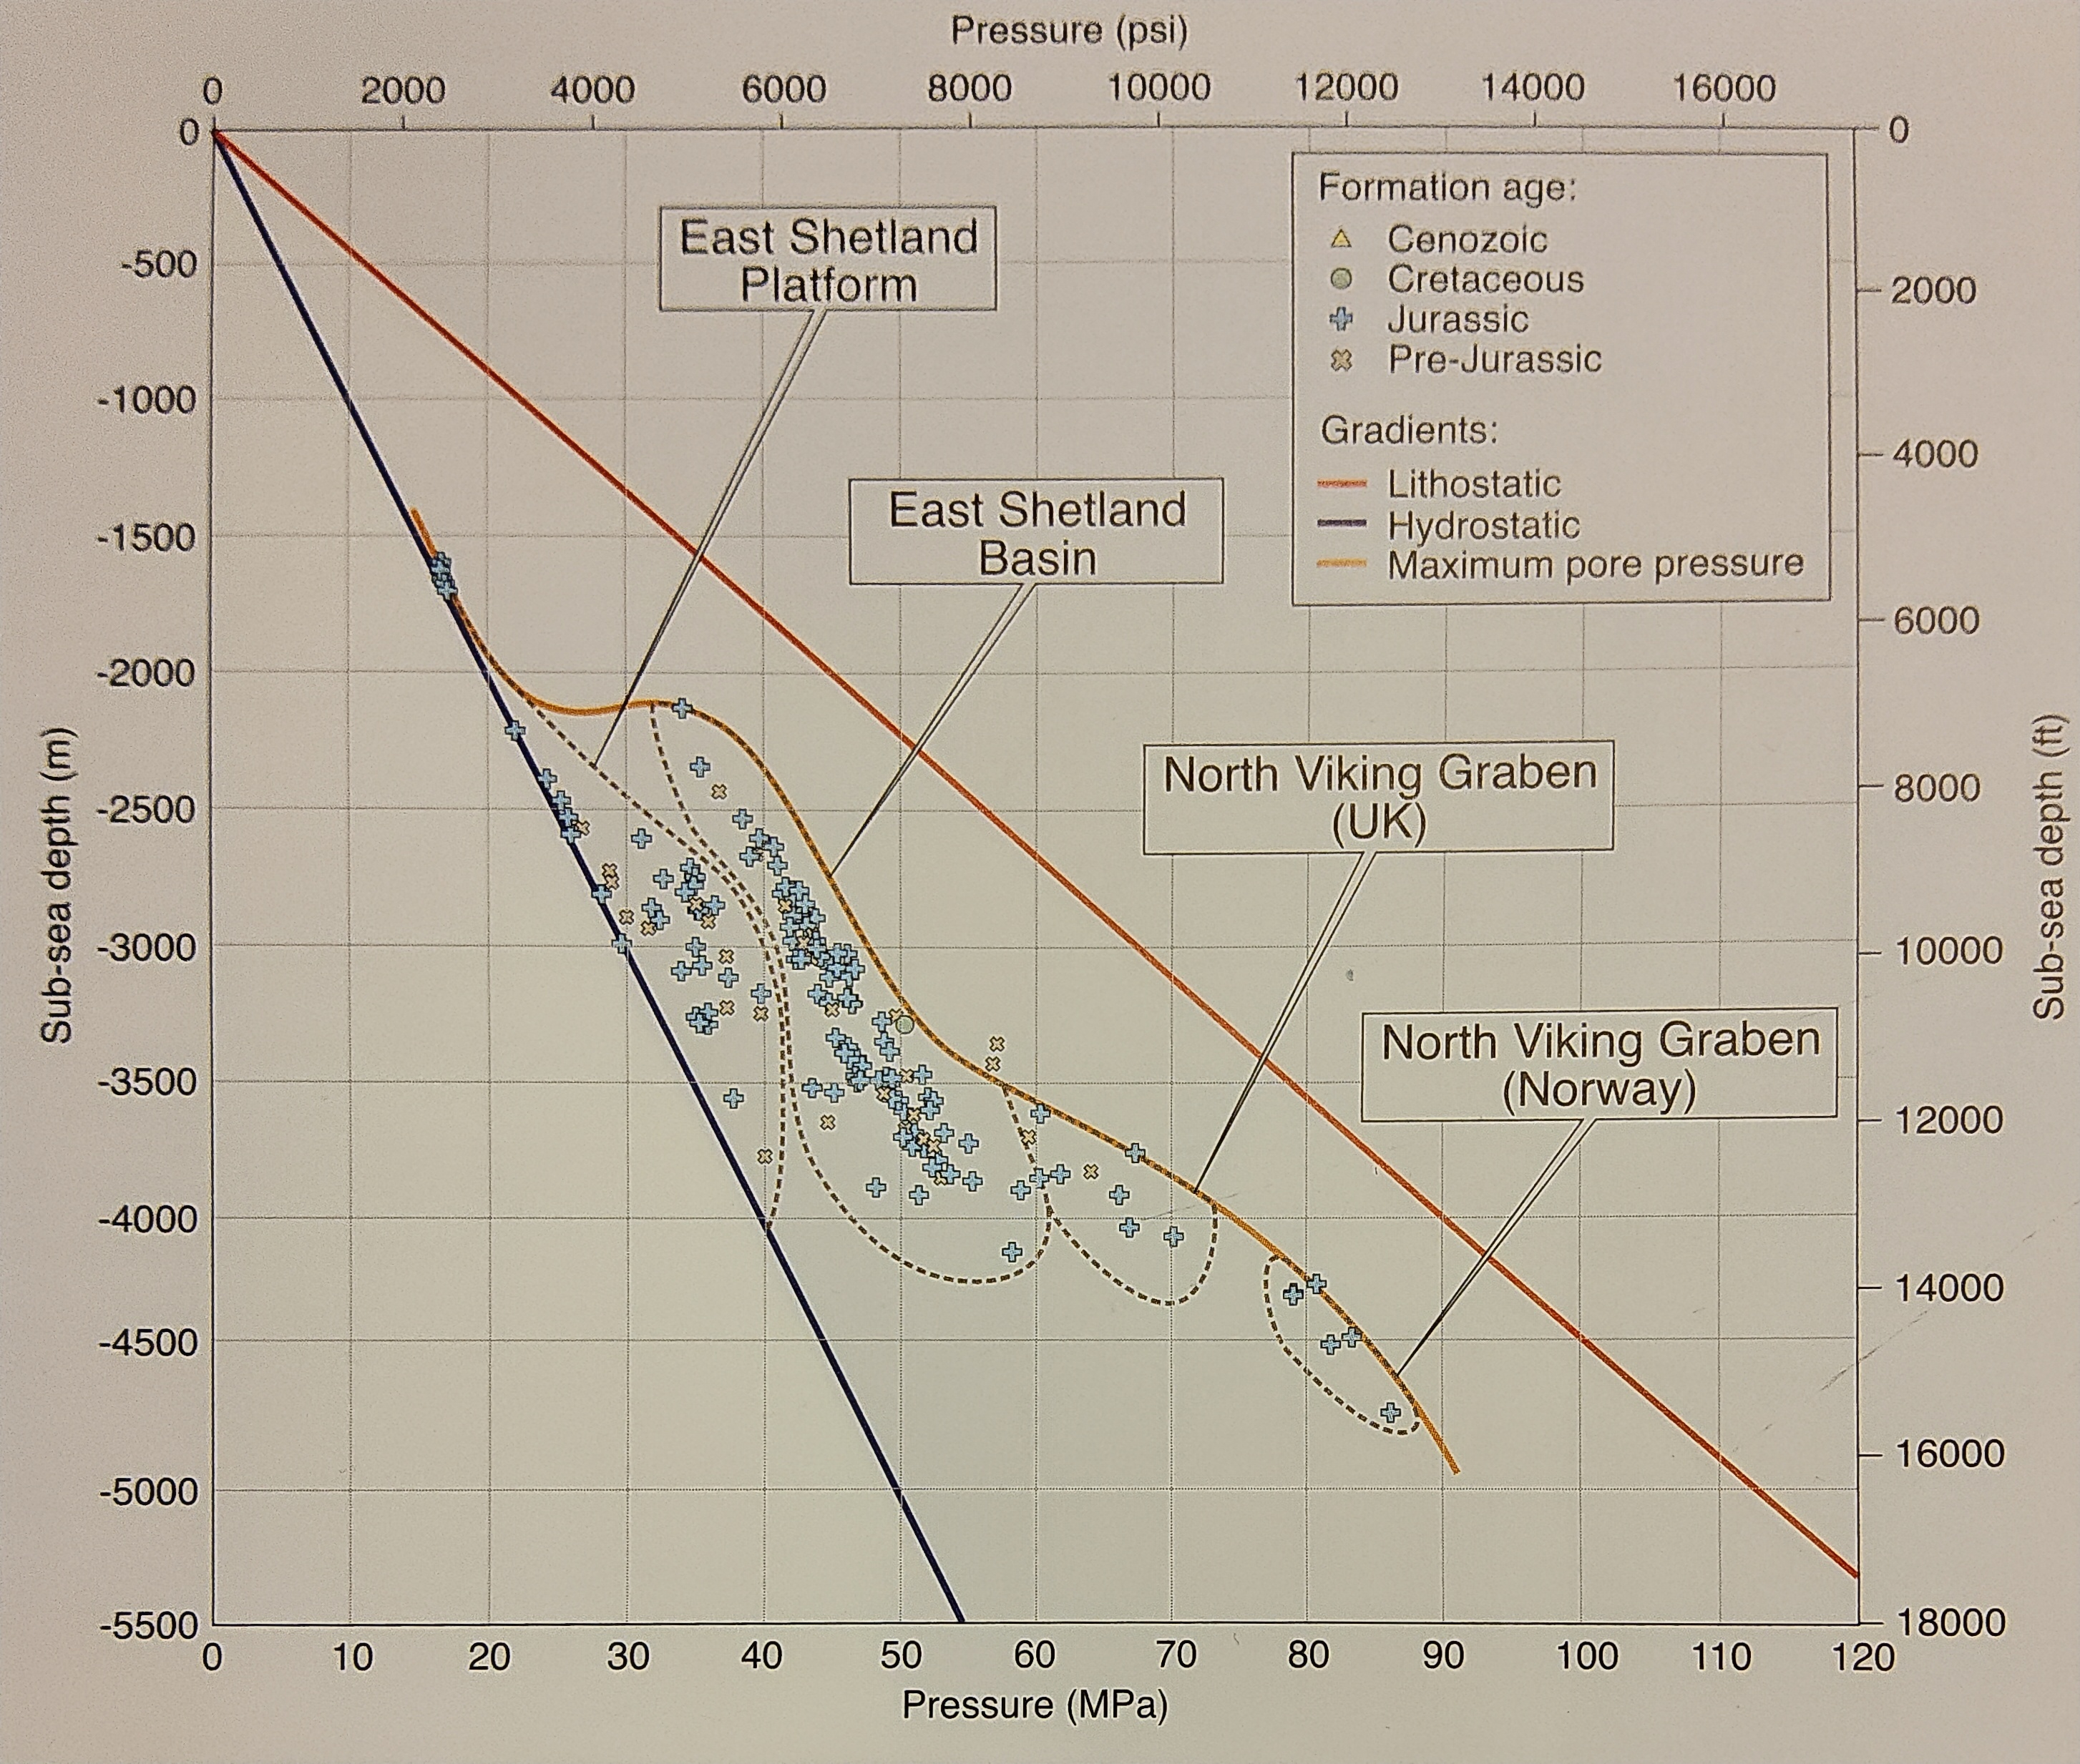

In [59]:
(720 - 100)/5500 

0.11272727272727273

In [60]:
# to estimate pressure in Brent reservoirs of East Shetland Basin
def f_pressure_brent(z):
    return z*0.113 + 100

In [61]:
ind = df['group'].str.contains('Brent')
df.loc[ind,'p0'] = f_pressure_brent(df.loc[ind,'depth'])
df.loc[ind,'p0'] = df.loc[ind,'p0'].round(1)
df.loc[ind,['depth','p0']] 

depth     p0
field                         
ATLA            2695.00  404.5
BRAGE           2195.70  348.1
FRAM            2468.00  378.9
FRØY            3278.50  470.5
FULLA           4049.00  557.5
GIMLE           2887.00  426.2
GJØA            2314.00  361.5
GULLFAKS        1997.00  325.7
GULLFAKS SØR    3331.50  476.5
HULDRA          3848.50  534.9
KVITEBJØRN      4230.50  578.0
LILLE-FRIGG     3853.50  535.4
MARTIN LINGE    3831.00  532.9
MUNIN           3644.00  511.8
OSEBERG         2699.50  405.0
OSEBERG SØR     2814.25  418.0
OSEBERG ØST     2884.00  425.9
SKIRNE          2900.00  427.7
STATFJORD       2659.20  400.5
STATFJORD NORD  2772.50  413.3
STATFJORD ØST   2526.00  385.4
SYGNA           2756.50  411.5
TORDIS          2280.50  357.7
TUNE            3553.00  501.5
VALE            3825.00  532.2
VALEMON         4282.05  583.9
VEGA            3618.00  508.8
VESLEFRIKK      3147.50  455.7
VIGDIS          2493.50  381.8
VISUND          2946.20  432.9
VISUND SØR      2881.50  425.6

## fields in Great Ekofisk area and nearby  
Fig. 18.10 (c). Central Graben from "The Millennium atlas ..." [4].  
The middle line crossing (0, 30 MPa) and (5500 m, 62 MPa):  
(620 - 300)/5500 * z + 300
p(z) = 0.0582z + 300 bar
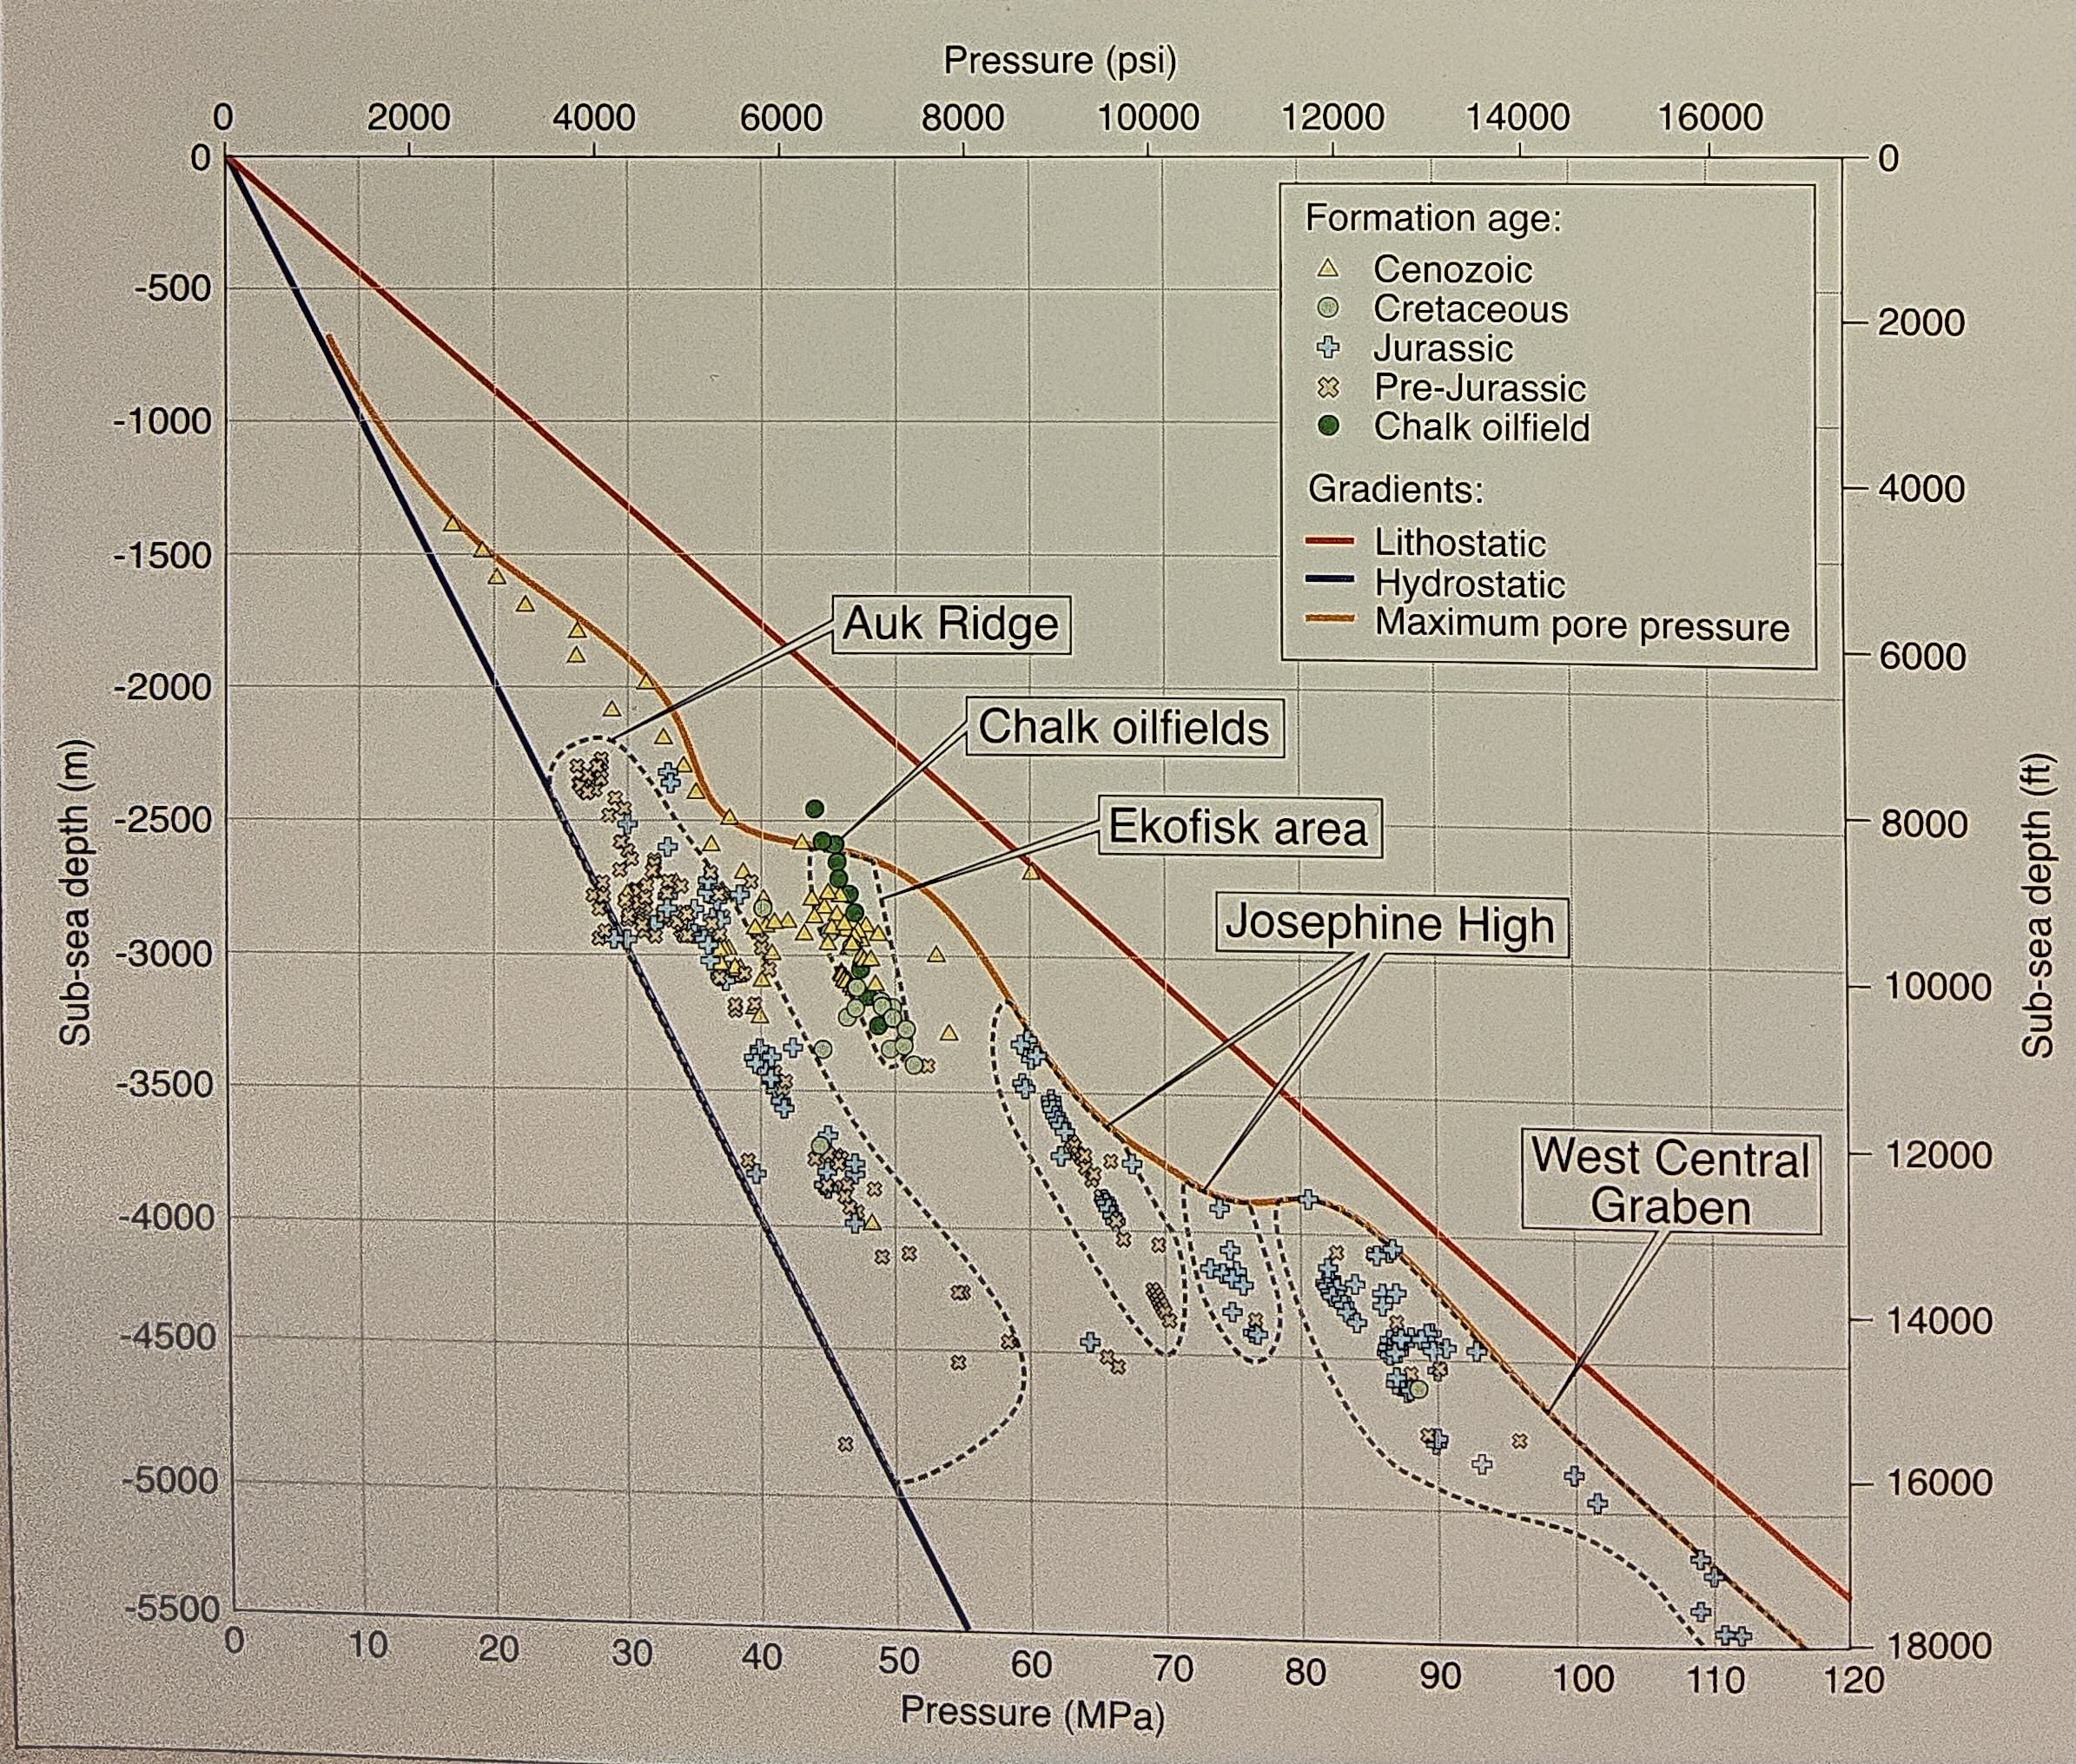

In [62]:
(620 - 300)/5500

0.05818181818181818

In [63]:
# to estimate pressure in reservoirs in the Great Ekofisk Area
def f_pressure_GEA(z):
    return z*0.0582 + 300

We are going to use this pressure trend as an initial guess for all reservoirs of the Great Ekofisk Area and nearby, as these reservoirs are at 3000 m and deeper, so using this pressure trend is likely to be much better than assuming hydrostatic conditions. We are going to double-check the most significant and HPHY reservoirs below.  

In [64]:
gea_list = ['ALBUSKJELL', 'BRYNHILD', 'COD', 'EDDA','EKOFISK', 'ELDFISK', 'EMBLA', 'FLYNDRE', 'GYDA', 'HOD', 'MIME', 
            'OSELVAR', 'TAMBAR', 'TAMBAR ØST', 'TOMMELITEN A', 'TOMMELITEN GAMMA', 'TOR', 'TRYM', 'ULA', 'VALHALL', 'VEST EKOFISK']
df.loc[gea_list,'p0'] = f_pressure_GEA(df.loc[gea_list,'depth'])
df.loc[gea_list,'p0'] = df.loc[gea_list,'p0'].round()
df.loc[gea_list,'p0'] 

field
ALBUSKJELL          497.0
BRYNHILD            495.0
COD                 486.0
EDDA                495.0
EKOFISK             488.0
ELDFISK             474.0
EMBLA               563.0
FLYNDRE             548.0
GYDA                536.0
HOD                 461.0
MIME                551.0
OSELVAR             482.0
TAMBAR              549.0
TAMBAR ØST          544.0
TOMMELITEN A        564.0
TOMMELITEN GAMMA    496.0
TOR                 489.0
TRYM                501.0
ULA                 511.0
VALHALL             449.0
VEST EKOFISK        495.0
Name: p0, dtype: float64

# verifications and corrections of p0, T0 and depth
This section aims to verify and correct (if needed) the initial pressure/temperature (p0/T0) and depth values derived above.

For comparison, P/T dependencies derived derived for Utsira Fm [6]:  
$T(z)=31.7z + 3.4$ (+/- 0.5 degC)  
$p(z)=101.1z+2.4$ bar (+/- 0.2 bar)
where z - depth (km)

gas fields with GIP==0?

In [65]:
sind=(df['in-place free gas']==0) & ((df['HC type'].str.contains('gas')) | (df['HC type'].str.contains('cond.')))
df.loc[sind, clmns_inplace]

STOIIP  GIIP     GOR  in-place ass. liquid  \
field                                                          
COD                  5.0  11.0  2200.0                   0.0   
HANZ                 5.0   1.0   200.0                   0.0   
JOHAN CASTBERG     175.0   0.0    None                   0.0   
MORVIN              36.0  16.0   444.4                   0.0   
SYMRA               40.0   5.0   125.0                   0.0   
TOMMELITEN GAMMA    12.0  15.0  1250.0                   0.0   

                  in-place ass. gas  in-place free gas  in-place OE  HC type  
field                                                                         
COD                            11.0                0.0         27.0      gas  
HANZ                            1.0                0.0          7.0  oil/gas  
JOHAN CASTBERG                  0.0                0.0        175.0  oil/gas  
MORVIN                         16.0                0.0         68.0  oil/gas  
SYMRA                           5.0                0.0         50.0  oil/gas  
TOMMELITEN GAMMA               15.0                0.0         42.0      gas

Oil fields without associated gas

In [66]:
sind=(df['STOIIP']>0) & (df['in-place ass. gas']==0)
df.loc[sind, clmns_inplace]

STOIIP   GIIP   GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                          
ALBUSKJELL        56.0   56.0  None                  40.0                0.0   
BRYNHILD           6.0    0.0  None                   0.0                0.0   
ENOCH              2.0    0.0  None                   0.0                0.0   
GLITNE            20.0    1.0  None                   0.0                0.0   
HALTEN ØST         3.0   16.0  None                   5.0                0.0   
HEIMDAL           11.0   61.0  None                   0.0                0.0   
IDUN NORD          1.0    4.0  None                   0.0                0.0   
JETTE              3.0    0.0  None                   0.0                0.0   
JOHAN CASTBERG   175.0    0.0  None                   0.0                0.0   
KRISTIN           70.0  121.0  None                  19.0                0.0   
ORMEN LANGE        1.0  398.0  None                  37.0                0.0   
SKIRNE             5.0   15.0  None                   0.0                0.0   
SKOGUL             3.0    0.0  None                   0.0                0.0   
TUNE               2.0   22.0  None                  11.0                0.0   
TYRVING           10.0    0.0  None                   0.0                0.0   
ÆRFUGL NORD        1.0    6.0  None                   0.0                0.0   
AASTA HANSTEEN     4.0   84.0  None                   1.0                0.0   

                in-place free gas  in-place OE  HC type  
field                                                    
ALBUSKJELL                   56.0        152.0      gas  
BRYNHILD                      0.0          6.0      oil  
ENOCH                         0.0          2.0      oil  
GLITNE                        1.0         21.0      oil  
HALTEN ØST                   16.0         24.0      gas  
HEIMDAL                      61.0         72.0  oil/gas  
IDUN NORD                     4.0          5.0      gas  
JETTE                         0.0          3.0      oil  
JOHAN CASTBERG                0.0        175.0  oil/gas  
KRISTIN                     121.0        210.0      gas  
ORMEN LANGE                 398.0        436.0      gas  
SKIRNE                       15.0         20.0      gas  
SKOGUL                        0.0          3.0      oil  
TUNE                         22.0         35.0      gas  
TYRVING                       0.0         10.0      oil  
ÆRFUGL NORD                   6.0          7.0      gas  
AASTA HANSTEEN               84.0         89.0      gas

In [67]:
sind=(df['GOR']>600)
df.loc[sind, clmns_inplace]

STOIIP  GIIP     GOR  in-place ass. liquid  \
field                                                          
COD                  5.0  11.0  2200.0                   0.0   
FLYNDRE              1.0   2.0  2000.0                   0.0   
TOMMELITEN GAMMA    12.0  15.0  1250.0                   0.0   

                  in-place ass. gas  in-place free gas  in-place OE HC type  
field                                                                        
COD                            11.0                0.0         27.0     gas  
FLYNDRE                         2.0                0.0          5.0     oil  
TOMMELITEN GAMMA               15.0                0.0         42.0     gas

In [68]:
df['p0 checked'] = False

## Sleipner Vest
Hansen, H., Eiken, O., & Aasum, T. O. (2005). Tracing the Path of Carbon Dioxide From a Gas/Condensate Reservoir, Through an Amine Plant and Back Into a Subsurface Aquifer – Case Study: The Sleipner Area, Norwegian North Sea. All Days, SPE-96742-MS. https://doi.org/10.2118/96742-MS

In [69]:
df.loc['SLEIPNER VEST',['p0','T0','depth']] # before correction

p0        377.8
T0        127.4
depth    3700.9
Name: SLEIPNER VEST, dtype: object

In [70]:
df.loc['SLEIPNER VEST','p0'] = 435
# df.loc['SLEIPNER VEST','T0']=120 

## SLEIPNER ØST

In [71]:
df.loc['SLEIPNER ØST',['p0','T0','depth']] # before correction

p0        255.6
T0         88.7
depth    2500.5
Name: SLEIPNER ØST, dtype: object

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/328_Formation_pressure_(Formasjonstrykk).pdf  
pretty much hydrostatic ...

In [72]:
df.loc['SLEIPNER ØST','p0'] = 240*10.5/9.6

## Kristin

In [73]:
df.loc['KRISTIN',['p0','T0']]

p0    488.0
T0    162.4
Name: KRISTIN, dtype: object

In [74]:
# ref.: https://www.equinor.com/no/energi/kristin
df.loc['KRISTIN','p0']=900
df.loc['KRISTIN','T0']=170 # close to the estimate via the geothermal gradient above

## Ekofisk
Hermansen, H., Thomas, L. K., Sylte, J. E., & Aasboe, B. T. (1997, October 5). Twenty Five Years of Ekofisk Reservoir Management. SPE Annual Technical Conference and Exhibition. https://doi.org/10.2118/38927-MS

In [75]:
df.loc['EKOFISK',['depth','p0','T0']] # before correction

depth    3237.55
p0         488.0
T0         112.5
Name: EKOFISK, dtype: object

In [76]:
df.loc['EKOFISK','depth'] = 10400*0.3048 # ft -> m
df.loc['EKOFISK','p0'] = 7135*0.0689476 # psia -> bar
df.loc['EKOFISK','T0'] = 5*(268 - 32)/9 # degF -> degC

## Albukjell

In [77]:
df.loc['ALBUSKJELL',['depth','p0','T0']] # before correction

depth    3385.5
p0        497.0
T0        117.3
Name: ALBUSKJELL, dtype: object

Based on estimates based on 1st flowing/build-up test from
[1/6-1's Completion Report](https://factpages.sodir.no/pbl/wellbore_documents/239_01_1_6_1_Completion_Report_and_Completion_log.pdf)

In [78]:
df.loc['ALBUSKJELL','depth'] = (10623-110)*0.3048 # ft -> m
# estimate
df.loc['ALBUSKJELL','p0'] = 7250*0.0689476 # psia -> bar 
df.loc['ALBUSKJELL','T0'] = 130 # as for Ekofisk 
# df.loc['ALBUSKJELL','HPHT'] = True

## ORMEN LANGE
https://factpages.sodir.no/pbl/wellbore_documents/3144_6305_5_1_COMPLETION_REPORT.pdf

In [79]:
print(df.loc['ORMEN LANGE',['p0','T0','depth']])

p0        288.4
T0         99.1
depth    2823.5
Name: ORMEN LANGE, dtype: object


In [80]:
# equivalent mud weight at mTVD (RKB) 2814 m (page 60 & 31)
sg_emd = 1.053 # g/cm3 
RKB= 26 # relative kelly bushing
z = df.loc['ORMEN LANGE','depth']
df.loc['ORMEN LANGE','p0'] = (z+RKB)*sg_emd*9.81*1000/1e+5 + 1 
df.loc['ORMEN LANGE','p0'] 

295.35135534999995

## SNØHVIT
https://factpages.sodir.no/pbl/wellbore_documents/85_01_Completion_Report.pdf

In [81]:
df.loc['SNØHVIT',['depth','p0','T0']] # before correction

depth    2372.5
p0        242.5
T0         84.5
Name: SNØHVIT, dtype: object

In [82]:
# p.159 equivalent mud weight at mTVD (RKB) ca. 2400 m
sg_emd = 1.13 # g/ccm 
RKB= 25 # relative kelly bushing
z = df.loc['SNØHVIT','depth']
df.loc['SNØHVIT','p0'] = (z+RKB)*sg_emd*9.81*1000/1e+5 +1 
df.loc['SNØHVIT','p0'] 

266.7700675

[digitized from 7120/7-1 formation pressure plot](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/85_Formation_pressure_(Formasjonstrykk).pdf):

In [83]:
p_, z_ = 267.741935483871, 2386.3714285714286
df.loc['SNØHVIT','p0'] = round((p_-1)/z_ * z + 1,1)
df.loc['SNØHVIT','p0'] 

266.2

## FENRIS

In [84]:
df.loc['FENRIS',['depth','p0','T0', 'GOR']]

depth    5237.0
p0        534.1
T0        177.1
GOR        None
Name: FENRIS, dtype: object

digitized from the 7120/7-1 [formation pressure plot](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/85_Formation_pressure_(Formasjonstrykk).pdf)

No pressure measurements available. So the initial reservoir pressure is estimated through the drilling mud weight of the [discovery well](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/6933) - 10%

In [85]:
sg_emd = 2.08 * (1 - .10) # g/ccm 
RKB= 48.1 # relative kelly bushing
z = df.loc['FENRIS','depth']
df.loc['FENRIS','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) +1 
df.loc['FENRIS','p0']

971.6

## KVITEBJØRN
https://factpages.sodir.no/pbl/wellbore_documents/2377_34_11_1_COMPLETION_REPORT_AND_LOG.pdf
page 32

In [86]:
df.loc['KVITEBJØRN',['depth','p0','T0', 'GOR']]

depth    4230.5
p0        578.0
T0        144.5
GOR        None
Name: KVITEBJØRN, dtype: object

In [87]:
sg_emd =1.875  # g/sm3
RKB= 24.0 # relative kelly bushing
z = df.loc['KVITEBJØRN','depth']
df.loc['KVITEBJØRN','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5,1) +1 
df.loc['KVITEBJØRN','p0']

783.6

## DVALIN

In [88]:
df.loc['DVALIN',['depth','p0','T0']]

depth    4257.0
p0        434.4
T0        145.4
Name: DVALIN, dtype: object

[estimated from 6507/7-14 FPP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/6367_Formation_pressure_(Formasjonstrykk).pdf):

In [89]:
df.loc['DVALIN','p0'] = round(120*63/56+500,1)
df.loc['DVALIN','p0']

635.0

## MARTIN LINGE

In [90]:
df.loc['MARTIN LINGE',['depth','p0','T0']]

depth    3831.0
p0        532.9
T0        131.6
Name: MARTIN LINGE, dtype: object

*Martin Linge produces mainly gas and condensate from sandstone of Middle Jurassic age in the Brent Group. The reservoirs are structurally complex with high pressure and high temperature (HPHT) at depths of 3700-4400 metres. In addition, oil is produced from the Frigg Formation of Eocene age. The Frigg reservoir is at a depth of 1750 metres and has good quality.*

In [91]:
foo=wells_dev.loc['MARTIN LINGE',['wlbWellboreName', 'wlbWellType', 'wlbWell','SSTVD']]
foo

wlbWellboreName  wlbWellType    wlbWell   SSTVD
field                                                       
MARTIN LINGE        30/4-A-9  DEVELOPMENT   30/4-A-9  4143.3
MARTIN LINGE       30/4-A-10  DEVELOPMENT  30/4-A-10  3842.3
MARTIN LINGE        30/4-A-6  DEVELOPMENT   30/4-A-6  1742.3
MARTIN LINGE      30/4-A-3 B  DEVELOPMENT   30/4-A-3  1741.3
MARTIN LINGE        30/4-A-8  DEVELOPMENT   30/4-A-8  3830.3
MARTIN LINGE       30/4-A-11  DEVELOPMENT  30/4-A-11  3831.7
MARTIN LINGE       30/4-A-12  DEVELOPMENT  30/4-A-12  3831.0
MARTIN LINGE       30/4-A-13  DEVELOPMENT  30/4-A-13  3820.7
MARTIN LINGE        30/4-A-7  DEVELOPMENT   30/4-A-7  1797.3
MARTIN LINGE       30/4-A-16  DEVELOPMENT  30/4-A-16  3965.7
MARTIN LINGE       30/4-A-19  DEVELOPMENT  30/4-A-19  4092.2
MARTIN LINGE      30/4-D-1 H  DEVELOPMENT   30/4-D-1  3997.0
MARTIN LINGE     30/4-D-1 AH  DEVELOPMENT   30/4-D-1  3836.0
MARTIN LINGE      30/4-A-3 A  DEVELOPMENT   30/4-A-3  1739.3
MARTIN LINGE        30/4-A-3  DEVELOPMENT   30/4-A-3  1768.3
MARTIN LINGE        30/4-A-1  DEVELOPMENT   30/4-A-1  1919.3
MARTIN LINGE       30/4-A-17  DEVELOPMENT  30/4-A-17  4069.7
MARTIN LINGE      30/4-A-7 A  DEVELOPMENT   30/4-A-7  1740.3

 correcting depth ...

In [92]:
# calculating depth by only wells in the Brent group
z = round(foo.loc[foo['SSTVD']>2000,'SSTVD'].mean())
df.loc['MARTIN LINGE','depth'] = z
df.loc['MARTIN LINGE','T0'] = round(f_temp_vs_depth(z)[0],1)

correcting pressure for that depth using [30/4-2's FPP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/378_Formation_pressure_(Formasjonstrykk).pdf)

In [93]:
df.loc['MARTIN LINGE','p0'] = round(11.8/11*240 + 500,0)

In [94]:
df.loc['MARTIN LINGE',['p0','depth','T0']]

p0        757.0
depth    3933.0
T0        134.9
Name: MARTIN LINGE, dtype: object

## HULDRA

Based on [30/2-3's FPP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/1970_Formation_pressure_(Formasjonstrykk).pdf)

In [95]:
df.loc['HULDRA','faulted']=True

In [96]:
df.loc['HULDRA','p0'] = round(8.3/11*240 + 500)
df.loc['HULDRA',['depth','p0','T0']]
df.loc['HULDRA','faulted'] = True

## EMBLA

In [97]:
df.loc['EMBLA',['depth','p0','T0']]

depth    4518.4
p0        563.0
T0        153.8
Name: EMBLA, dtype: object

The initial reservoir pressure is estimated from [2/7-23 S' FPP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/1547_Formation_pressure_(Formasjonstrykk).PDF)

In [98]:
df.loc['EMBLA','faulted']=True
df.loc['EMBLA','p0'] = 500+3*120+5
df.loc['EMBLA',['depth','p0','T0']]

depth    4518.4
p0        865.0
T0        153.8
Name: EMBLA, dtype: object

In [99]:
df.loc['EMBLA',['depth','p0','T0']]

depth    4518.4
p0        865.0
T0        153.8
Name: EMBLA, dtype: object

## MORVIN

In [100]:
df.loc['MORVIN',['depth','p0','T0']]

depth    4637.0
p0        473.1
T0        157.7
Name: MORVIN, dtype: object

Estimated from https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/3322_Formation_pressure_(Formasjonstrykk).pdf

In [101]:
df.loc['MORVIN','faulted']=True
df.loc['MORVIN','p0'] = round(500+360*15/16.6)
df.loc['MORVIN',['depth','p0','T0']]

depth    4637.0
p0        825.0
T0        157.7
Name: MORVIN, dtype: object

## BERLING

No pressure measurements available. So the initial reservoir pressure is estimated through the drilling mud weight of the [discovery well](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/8759) - 10%

In [102]:
df.loc['BERLING',['depth','p0','T0']]

depth    4236.0
p0        432.2
T0        144.7
Name: BERLING, dtype: object

In [103]:
sg_emd = 1.90 * (1 - .10) # g/ccm 
RKB= 23.0 # relative kelly bushing
z = df.loc['BERLING','depth']
df.loc['BERLING','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1 
df.loc['BERLING','p0']

715.5

## BRYNHILD

In [104]:
df.loc['BRYNHILD',['depth','p0','T0']]

depth    3346.0
p0        495.0
T0        116.0
Name: BRYNHILD, dtype: object

Estimated from https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/5683_Formation_pressure_(Formasjonstrykk).pdf

In [105]:
df.loc['BRYNHILD','p0'] = round(500 + 6.1/5.5*120)
df.loc['BRYNHILD','p0']

633.0

## Gyda

In [106]:
df.loc['GYDA',['depth','p0','T0']]

depth    4062.0
p0        536.0
T0        139.1
Name: GYDA, dtype: object

p.168 https://factpages.sodir.no/pbl/wellbore_documents/48_2_1_4_Drilling_Completion_report.pdf

In [107]:
sg_emd = 1.50 # g/ccm 
RKB= 25.0 # relative kelly bushing
z = df.loc['GYDA','depth']
df.loc['GYDA','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1 
df.loc['GYDA','T0'] = f_degF2degC(310) # approx. p.161
df.loc['GYDA','p0']

602.4

## ODA

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/6630_Formation_pressure_(Formasjonstrykk).PDF

In [108]:
df.loc['ODA',['depth','p0','T0']]
df.loc['ODA','depth'] = 2900
df.loc['ODA','p0'] = 200 + 240*8.5/9.8

## ÅSGARD
lots of reservoirs and producing formations ...

In [109]:
df.loc['ÅSGARD',['depth','p0','T0']] # before correction

depth    4236.8
p0        432.3
T0        144.7
Name: ÅSGARD, dtype: object

Midgard, 6507/11-1
https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/68_Formation_pressure_(Formasjonstrykk).pdf

In [110]:
# @SSTVD 2467 m
240*11.6/11.1 

250.8108108108108

6506/12-1 Smørbukk https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/1004_Formation_pressure_(Formasjonstrykk).pdf  
@4236.8 SSTVD => ~ 480 bar - very close to hydrostatic

In [111]:
df.loc['ÅSGARD','p0'] = 480 

## TROLL  

In [112]:
df.loc['TROLL',['depth','p0','T0']] # before correction

depth    1558.0
p0        159.6
T0         58.2
Name: TROLL, dtype: object

from https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/505_Formation_pressure_(Formasjonstrykk).PDF

In [113]:
df.loc['TROLL','p0'] = round(8.7/13.1*240,1)
df.loc['TROLL','p0']

159.4

## FRIGG and other reservoirs in the area

In [114]:
df.loc['FRIGG',['depth','p0','T0']] # before correction

depth    1875.0
p0        191.9
T0         68.5
Name: FRIGG, dtype: object

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/190_Formation_pressure_(Formasjonstrykk).pdf

In [115]:
df.loc['FRIGG','p0'] = round(9/11.1*240,1)
df.loc['FRIGG','p0']

194.6

In [116]:
ind = df['formation'] == ('Frigg')
df.loc[ind,['p0','depth','group','formation']]

p0   depth      group formation
field                                            
FRIGG          194.6  1875.0  Hordaland     Frigg
NORDØST FRIGG  200.1  1955.5  Hordaland     Frigg
ODIN           213.0  2082.1  Hordaland     Frigg
SKOGUL         215.8  2109.5  Hordaland     Frigg
ØST FRIGG      212.4  2076.0  Hordaland     Frigg

These fields seem to belong to the same regional aquifer at hydr. pressure.

In [117]:
df.loc[ind,'p0'] = .1038 * df.loc[ind,'depth']
df.loc[ind,'p0']

field
FRIGG            194.62500
NORDØST FRIGG    202.98090
ODIN             216.12198
SKOGUL           218.96610
ØST FRIGG        215.48880
Name: p0, dtype: float64

## JOHAN SVERDRUP

In [118]:
df.loc['JOHAN SVERDRUP',['depth','p0','T0']] # before correction

depth    1920.5
p0        196.5
T0         69.9
Name: JOHAN SVERDRUP, dtype: object

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/6374_Formation_pressure_(Formasjonstrykk).pdf

In [119]:
df.loc['JOHAN SVERDRUP','p0'] = 240*9.4/11.5

## GINA KROG
https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/315_Formation_pressure_(Formasjonstrykk).pdf
https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/5842_Formation_pressure_(Formasjonstrykk).pdf

In [120]:
df.loc['GINA KROG',['depth','p0','T0']] # before correction

depth    3790.5
p0        386.9
T0        130.3
Name: GINA KROG, dtype: object

In [121]:
df.loc['GINA KROG','p0'] = 500 # very approximate

## GULLFAKS

In [122]:
df.loc['GULLFAKS',['depth','p0','T0']] # before correction

depth    1997.0
p0        325.7
T0         72.4
Name: GULLFAKS, dtype: object

estimated from https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/426_Formation_pressure_(Formasjonstrykk).pdf

In [123]:
df.loc['GULLFAKS','faulted'] = True
df.loc['GULLFAKS','p0'] = round(3*120*17.5/19.6)
# pressure gradient
print('pressure gradient:', (df.loc['GULLFAKS','p0']-1)/1997 * 1000)
print('pressure:', df.loc['GULLFAKS','p0'])

pressure gradient: 160.24036054081122
pressure: 321.0


## STATFJORD

In [124]:
df.loc['STATFJORD',['depth','p0','T0']] # before correction

depth    2659.2
p0        400.5
T0         93.8
Name: STATFJORD, dtype: object

## COD

In [125]:
df.loc['COD',['depth','p0','T0']] # before correction

depth    3199.7
p0        486.0
T0        111.2
Name: COD, dtype: object

https://factpages.sodir.no/pbl/wellbore_documents/149_7_11_1_WELL_COMPLETION_REPORT.PDF
p. 16:  
"Three separate hydrocarbo accumulations on an abnormal formation pressure gradient were tested in the subject well. ...  
Abnormally high formation pressures were measured in the subject well.  
They range from 5326 psi at 9564 depth, $\nabla p_f$  = .558 psi/ft to 6177 psi @ 10178' depth, $\nabla p_f$  = .607 psi/ft."

In [126]:
cc_ft2m, cc_psi2bar = .3048, 0.0689476  # m, bar
cc = cc_psi2bar/cc_ft2m # conversion coefficient

grad_p_field = .607
grad_p_si = cc*grad_p_field
print(f'Assumed gradient: {grad_p_field} (psi/ft) => {grad_p_si*1000:.2f} (bar/km)')
z = df.loc['COD','depth']
df.loc['COD','p0'] = round(grad_p_si*z + 1,1)
df.loc['COD','p0']

Assumed gradient: 0.607 (psi/ft) => 137.31 (bar/km)


440.3

## OSELVAR

In [127]:
z = df.loc['OSELVAR','depth'] 
df.loc['OSELVAR',['depth','p0','T0']] # before correction

depth    3125.0
p0        482.0
T0        108.8
Name: OSELVAR, dtype: object

[1/3-7 completion report](https://factpages.sodir.no/pbl/wellbore_documents/2505_1_3_7_COMPLETION_REPORT.pdf): *"Extrapolation of pressure from DST 1B gives a pore pressure of 1.29 at TOP Forties Fm. resevoir (-3136 m msl TVD)"*  
p.38: Static pressure @3152.5: 396.2

In [128]:
# sg_emd, RKB = 1.29, 44.7
# df.loc['OSELVAR','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1 # ca. 402.1
df.loc['OSELVAR','depth'] = 3152.5
df.loc['OSELVAR','p0'] = 396.2
df.loc['OSELVAR','T0'] = 131.6

In [129]:
round((z+RKB)*sg_emd*9.81*1000/1e+5, 1)

463.5

## ULA

In [130]:
z = df.loc['ULA','depth'] 
df.loc['ULA',['depth','p0','T0']] # before correction

depth    3619.2
p0        511.0
T0        124.8
Name: ULA, dtype: object

[7/12-9](https://factpages.sodir.no/pbl/wellbore_documents/1470_7_12_9_Completion_report.pdf), p.31

In [131]:
RKB = 23.5
sg_emd = 1.48
df.loc['ULA','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1
df.loc['ULA','p0']

529.9

## MIME

In [132]:
z = df.loc['MIME','depth'] 
df.loc['MIME',['depth','p0','T0']] # before correction

depth    4309.0
p0        551.0
T0        147.1
Name: MIME, dtype: object

from 7/11-10S' [completion report p.89 and on](https://factpages.sodir.no/pbl/wellbore_documents/1563_7_11_10_S_COMPLETION_REPORT_AND_LOG.pdf)

In [133]:
RKB = 23.5
sg_emd = 1.44 # p. 90 
df.loc['MIME','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1
df.loc['MIME','T0'] = 5 + (168-5)/(4048 - 102)*z  # p.93
df.loc['MIME','T0'] = round(df.loc['MIME','T0'],1)
df.loc['MIME',['p0','T0']]

p0    613.0
T0    183.0
Name: MIME, dtype: object

## VEST EKOFISK

In [134]:
141/3.3420

42.190305206463194

In [135]:
z = df.loc['VEST EKOFISK','depth'] 
df.loc['VEST EKOFISK',['depth','p0','T0']] # before correction

depth    3348.6
p0        495.0
T0        116.1
Name: VEST EKOFISK, dtype: object

Set to the extrapolation pressure from [DST1 @ 2/4-6](https://factpages.sodir.no/pbl/wellbore_documents/181_05_2_4_6(5X)_DSTs.pdf) (p. 1)

In [136]:
df.loc['VEST EKOFISK','p0'] = 0.5*(7293.6+7263.3) * cc_psi2bar + 1
df.loc['VEST EKOFISK','p0'] 

502.83165922

## TOMMELITEN A 

In [137]:
df.loc['TOMMELITEN A',['depth','p0','T0']]

depth    4530.0
p0        564.0
T0        154.2
Name: TOMMELITEN A, dtype: object

As of 2024, TOMMELITEN A is a green field, so no reliable depth data are available from the developement wells. 
So here the depth is assumed from fig. 13 (p.26) of [this report](https://factpages.sodir.no/pbl/wellbore_documents/243_1_9_1_and_1_9_2_Pore_pressure_fracture_gradients.pdf).
The pressure is assumed to follow the GEA trend which is supported by the est. pressure gradient of ca. 1.6 gm/ccm in the same figure.

In [138]:
z = 3100 # 
df.loc['TOMMELITEN A','depth'] = z
df.loc['TOMMELITEN A','p0'] = f_pressure_GEA(z)
df.loc['TOMMELITEN A','T0'] = f_temp_vs_depth(z)

## FLYNDRE
The same problem as with Tommeliten A above.
The depth is assumed from NOD description https://factpages.sodir.no/en/field/PageView/All/24635035

In [139]:
df.loc['FLYNDRE',['depth','p0','T0']]

depth    4260.0
p0        548.0
T0        145.5
Name: FLYNDRE, dtype: object

In [140]:
z = 3100 # 
df.loc['FLYNDRE','depth'] = z
df.loc['FLYNDRE','p0'] = f_pressure_GEA(z)
df.loc['FLYNDRE','T0'] = f_temp_vs_depth(z)

## YME

In [141]:
z = df.loc['YME','depth'] 
df.loc['YME',['depth','p0','T0']] # before correction

depth    3256.4
p0        332.5
T0        113.1
Name: YME, dtype: object

[5], p.154:

In [142]:
df.loc['YME','p0'] = 350
df.loc['YME','T0'] = 110
df.loc['YME','depth'] = 3164
df.loc['YME','GOR'] = 40

## SNORRE

In [143]:
z = df.loc['SNORRE','depth'] 
df.loc['SNORRE',['depth','p0','T0']] # before correction

depth    2635.3
p0        269.3
T0         93.0
Name: SNORRE, dtype: object

[5] p.124.: reservoir pressure at Lunde and Statfjord formation @2525 is 383 bar. Reservoir fluid density 0.73 - 0.78 g/rsm3 (Statfjord) and 0.70 - 0.75 g/rsm3 (Lunde). Temperature: 92 - 95 and 90 - 96 respectively

In [144]:
df.loc['SNORRE','p0'] = 383 + (2635.3 - 2525) * 9.81 * .74 * 1000 / 1e+5
df.loc['SNORRE','p0']

391.00711820000004

## TYRIHANS

In [145]:
df.loc['TYRIHANS',['depth','p0','T0']] # before correction

depth    3667.0
p0        374.3
T0        126.3
Name: TYRIHANS, dtype: object

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/4589_Formation_pressure_(Formasjonstrykk).pdf

In [146]:
df.loc['TYRIHANS','p0'] = 360 * 17.5 / 16.6 
df.loc['TYRIHANS','p0'] 

379.5180722891566

## HEIDRUN

In [147]:
df.loc['HEIDRUN',['depth','p0','T0']] # before correction

depth    2429.3
p0        248.3
T0         86.4
Name: HEIDRUN, dtype: object

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/464_Formation_pressure_(Formasjonstrykk).pdf

In [148]:
df.loc['HEIDRUN','p0'] = round(10.3/9.7*240)
df.loc['HEIDRUN','p0']

255.0

## AASTA HANSTEEN

In [149]:
df.loc['AASTA HANSTEEN',['depth','p0','T0']] # before correction

depth    2937.0
p0        300.0
T0        102.8
Name: AASTA HANSTEEN, dtype: object

https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/5867_Formation_pressure_(Formasjonstrykk).pdf

In [150]:
df.loc['AASTA HANSTEEN','p0'] = round(360*12.3/14.3) # before correction

## KNARR

In [151]:
df.loc['KNARR',['depth','p0','T0']] # before correction

depth    3886.0
p0        396.6
T0        133.4
Name: KNARR, dtype: object

No pressure measurements available. So the initial reservoir pressure is estimated through the drilling mud weight of the [discovery well](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/5811) - 10%

In [152]:
sg_emd = 1.87 * (1 - .10) # g/ccm 
RKB= 25.0 # relative kelly bushing
z = df.loc['KNARR','depth']
df.loc['KNARR','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1 
df.loc['KNARR','p0']

646.7

## DUVA

In [153]:
df.loc['DUVA',['depth','p0','T0']] # before correction

depth    2496.2
p0        255.1
T0         88.5
Name: DUVA, dtype: object

No pressure measurements available. The drilling mud weight of the [discovery well](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/5811) looks very close to hydrostatic.

In [154]:
sg_emd = 1.19 * (1 - .10) # g/ccm 
RKB= 24.0 # relative kelly bushing
# z = df.loc['DUVA','depth']
# df.loc['DUVA','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1 
df.loc['DUVA','p0 checked'] = True

## NOVA

In [155]:
df.loc['NOVA',['depth','p0','T0']] # before correction

depth    2804.8
p0        286.5
T0         98.5
Name: NOVA, dtype: object

From [discovery well description](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/6776)
Two Intra Heather Formation Sandstones were penetrated: an Oxfordian age sandstone at 2621 m to 2690 m (Intra Heather Sandstone 2) and a Bathonian-Callovian age sandstone at 2776 m to 2790 m (Intra Heather Sandstone 1). The total net reservoir in the two sandstone intervals is 54.2 m. Both reservoirs were filled with light oil in oil down-to settings. The densities of the oils are slightly different but the two columns fall on a common pressure gradient within one bar discrepancy. **The overpressure at top reservoir is 16.7 bar**. **The Sandstones in the Brent Group were found water bearing with a hydrostatic pressure gradient.**

In [156]:
df.loc['NOVA','p0'] += 16.7 
df.loc['NOVA','p0']

303.2

## Byrding  

[FPP at the discovery well](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/5063)
looks pretty much hydrostatic

In [157]:
df.loc['BYRDING',['depth','p0','T0']] 

depth    3095.5
p0        316.1
T0        107.9
Name: BYRDING, dtype: object

In [158]:
df.loc['BYRDING','p0'] = 316.0 # ca.
df.loc['BYRDING','p0 checked'] = True

## FRAM H-NORD

In [159]:
df.loc['FRAM H-NORD',['depth','p0','T0']] 

depth    2910.0
p0        297.3
T0        101.9
Name: FRAM H-NORD, dtype: object

No pressure measurements available. The initial reservoir pressure is estimated through the drilling mud weight of the [discovery well](https://factpages.sodir.no/en/wellbore/pageview/exploration/all/5811) - 10%. Looks slightly above hydrostatic. 

In [160]:
sg_emd = 1.25 * (1 - .10) # g/ccm 
RKB= 26.0 # relative kelly bushing
z = df.loc['FRAM H-NORD','depth']
df.loc['FRAM H-NORD','p0'] = round((z+RKB)*sg_emd*9.81*1000/1e+5, 1) + 1 
df.loc['FRAM H-NORD','p0']

325.0

## HEIMDAL
looks very close to hydrostatic and close to the initial est.
https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/359_Formation_pressure_(Formasjonstrykk).pdf

In [161]:
df.loc['HEIMDAL','p0 checked'] = True

## GUDRUN

In [162]:
df.loc['GUDRUN',['depth','p0','T0']] 

depth    4226.2
p0        431.2
T0        144.4
Name: GUDRUN, dtype: object

From [FFP of an appraisal well](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/313_Formation_pressure_(Formasjonstrykk).pdf)

In [163]:
df.loc['GUDRUN', 'HPHT'] = True
df.loc['GUDRUN','p0'] = (500 + 1100)/2 -15  # approximate
df.loc['GUDRUN','p0']

785.0

## TAMBAR

In [164]:
df.loc['TAMBAR',['depth','p0','T0']] 

depth    4285.0
p0        549.0
T0        146.3
Name: TAMBAR, dtype: object

From [1/3-3's FFP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/87_Formation_pressure_(Formasjonstrykk).pdf):

In [165]:
df.loc['TAMBAR','p0'] = 615  # approximate

## TAMBAR ØST

In [166]:
df.loc['TAMBAR ØST',['depth','p0','T0']] 

depth    4197.5
p0        544.0
T0        143.5
Name: TAMBAR ØST, dtype: object

No data available. It is possible to est. by analogy from Tambar

## TRYM

In [167]:
df.loc['TRYM',['depth','p0','T0']] 

depth    3457.0
p0        501.0
T0        119.6
Name: TRYM, dtype: object

From [discovery well FPP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/1467_Formation_pressure_(Formasjonstrykk).pdf):

In [168]:
df.loc['TRYM','p0'] = 500 # approximate

## HUGIN

In [169]:
df.loc['HUGIN',['depth','p0','T0']] 

depth    2622.0
p0        267.9
T0         92.6
Name: HUGIN, dtype: object

The field consist of many reservoirs in different formations at varying depth. So the depth estimate is very approximate.
The [25/2-5's FFP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/357_Formation_pressure_(Formasjonstrykk).pdf) looks very close to hydrostatic. 

## NORNE

In [170]:
df.loc['NORNE',['depth','p0','T0']] 

depth    2619.0
p0        267.6
T0         92.5
Name: NORNE, dtype: object

The values from the Norne's benchmark model are very close to hydrostatic.  

In [171]:
df.loc['NORNE','p0 checked'] = True

## VOLVE

In [172]:
df.loc['VOLVE',['depth','p0','T0']] 

depth    3115.05
p0         318.1
T0         108.5
Name: VOLVE, dtype: object

From the [Volve field dataset](https://www.equinor.com/energy/volve-data-sharing):

In [173]:
z = df.loc['VOLVE','depth']
# using oil zone gradient of 0.07 bar/m
df.loc['VOLVE','p0'] = 337 + (z - 3060.0) * 0.07
df.loc['VOLVE','p0']

340.8535

## VEGA

In [174]:
df.loc['VEGA',['depth','p0','T0']] 

depth    3618.0
p0        508.8
T0        124.8
Name: VEGA, dtype: object

[The discovery well FPP](https://factpages.sodir.no/pbl/wellbore_pressure_plot_pdfs/205_Formation_pressure_(Formasjonstrykk).pdf):

In [175]:
df.loc['VEGA','p0'] = 550 # appoximate

# Initial pressure gradients

In [176]:
df['grad_p0'] = ((df.p0 - 1)/df.depth * 1000).round(1) # bar/km
df['grad_p0']

field
ALBUSKJELL        155.7
ALVE              101.8
ALVE NORD         101.8
ALVHEIM           101.8
ATLA              149.7
                  ...  
ÆRFUGL NORD       101.8
ØRN               101.8
ØST FRIGG         103.3
ÅSGARD            113.1
AASTA HANSTEEN    105.2
Name: grad_p0, Length: 134, dtype: float64

adding this column to track reservoirs with verified pressures

In [177]:
ind = (df.p0 != df.p_h) | (df['p0 checked'])
df.loc[ind,'p0 checked'] = True
# rounding up
df[['p0','T0','depth']] = df[['p0','T0','depth']].round(1)

# PVT data and correlations

## CO2, CH4 and H2 PVT from NIST [3]
Eric W. Lemmon, Ian H. Bell, Marcia L. Huber, and Mark O. McLinden, "Thermophysical Properties of Fluid Systems" in NIST Chemistry WebBook, NIST Standard Reference Database Number 69, Eds. P.J. Linstrom and W.G. Mallard, National Institute of Standards and Technology, Gaithersburg MD, 20899, https://doi.org/10.18434/T4D303, (retrieved October 5, 2024).

In [178]:
ref_p = 1.01325 # bar, reference pressure
ref_temp = 15 #  degC, ref. temperature

CO2_sc = get_fluid_properties(
    fluid='CO2', p_min=ref_p, p_max=ref_p, degC=ref_temp, nist_folder='./data/NIST')
CH4_sc = get_fluid_properties(
    fluid='CH4', p_min=ref_p, p_max=ref_p, degC=ref_temp, nist_folder='./data/NIST')
H2_sc = get_fluid_properties(
    fluid='H2',  p_min=ref_p, p_max=ref_p, degC=ref_temp, nist_folder='./data/NIST')
CO2_sc

Temperature (C)  Pressure (bar)  Density (kg/m3)  Volume (m3/kg)  \
0             15.0          1.0132           1.8718         0.53423   

   Internal Energy (kJ/kg)  Enthalpy (kJ/kg)  Entropy (J/g*K)  Cv (J/g*K)  \
0                   443.25            497.38           2.7079     0.64737   

   Cp (J/g*K)  Sound Spd. (m/s)  Joule-Thomson (K/bar)  Viscosity (cP)  \
0     0.84125            264.47                 1.1934        0.014434   

   Therm. Cond. (W/m*K)  Phase  
0              0.015871  vapor

In [179]:
den_CO2_sc=CO2_sc.at[0,'Density (kg/m3)']
den_CH4_sc=CH4_sc.at[0,'Density (kg/m3)']
den_H2_sc = H2_sc.at[0,'Density (kg/m3)']
print(f'CO2 density at SC: {den_CO2_sc} (kg/m3)')
print(f'CH4 density at SC: {den_CH4_sc} (kg/m3)')
print(f'H2 density  at SC: {den_H2_sc} (kg/m3)')

CO2 density at SC: 1.8718 (kg/m3)
CH4 density at SC: 0.67983 (kg/m3)
H2 density  at SC: 0.085205 (kg/m3)


In [180]:
tt = np.arange(0,220,10) # temperature range (degC)
pp = np.arange(1,1011,10) # pressure range (bar)
PVT_dict = {}
# print(tt)

f_fvf = {}
for fluid, den_sc in zip(['CO2','CH4','H2'],[den_CO2_sc,den_CH4_sc,den_H2_sc]):
    PVT_dict[fluid] = {}
    FVF = np.empty(shape=(len(pp),len(tt)))
    for n,t in enumerate(tt):
        pvt_df=get_fluid_properties(
            fluid=fluid,p_min=1, p_max=1001, p_inc=10, degC=t, den_sc=den_sc,
            process=False, nist_folder='./data/NIST')   
        PVT_dict[fluid][t] = pvt_df
        pvt_df_=pvt_df.copy().drop_duplicates(subset=['Pressure (bar)'], keep='last')
        # to avoid issues with duplicates around critical pressures
        int_func = interp1d(pvt_df_['Pressure (bar)'], pvt_df_['FVF'], kind='cubic')
        FVF[:,n] = int_func(pp)

    f_fvf[fluid]=RegularGridInterpolator((pp,tt), FVF, method='pchip') 

In [181]:
f_fvf['CH4']((300,100))

array(0.00439617)

In [182]:
df.loc[['FRIGG','MARTIN LINGE'],'depth']

field
FRIGG           1875.0
MARTIN LINGE    3933.0
Name: depth, dtype: float64

## Glasø

In [183]:
# https://en.wikipedia.org/wiki/Brent_Crude :  
# Brent Crude has a density of approximately 835 kg/m3, 
# being equivalent to a specific gravity of 0.835 or an API gravity of 38.06.
api_gravity=38.06
sg_oil = 0.835

# https://www.sodir.no/en/regulations/regulations/measurement-of-petroleum-for-fiscal-purposes-and-for-calculation-of-co2-tax/#:~:text=Natural%20gas%20mainly%20consisting%20of,%E2%80%93%20460%20kg%2Fm3%20.
# "...Standard density is typically in the area 0,67 – 0,74 kg/Sm3."
density_air = 1.225 # SC, kg/m3
density_gas = 0.80 # very rough estimate based on wiki and various sim. models
# " ... average spetific gravity of total surface gases from flash separation (air = 1)"
sg_gas = density_gas/density_air # specific gravity
print(f'Specific gas density: {sg_gas:.3f}')

Specific gas density: 0.653


In [184]:
def f_fvf_oil(t, rs, sg_oil=0.835, sg_gas=0.5714):
    '''
    Glasø's correlation for FVF at saturation pressure:
    rs - gas solution ratio (sm3/sm3)
    t - temperature (degC)
    '''

    t = 32 + 1.8*t # to degF
    rs *= 5.614583333333333 # to scf/STB
    v = np.log10(rs*(sg_gas/sg_oil)**0.526 + 0.968*t)
    v = -6.58511 + 2.91329*v - 0.27683*v**2

    return 1.0 + 10**v

# GOR vs. depth trend 

In [185]:
def poly(x,*p):
    y = 0
    for i in range(1,len(p)):
        y += p[i]*x**i
    y += p[0]
    return y

Two ways to do correction: select all fields with 
ind = (df['STOIIP']>0.0) & (df['in-place ass. gas'] >0)

In [186]:
ind = (df['STOIIP']>0.0) & (df['in-place ass. gas'] >0)
hj1 = df[ind].sort_values(by='depth')

gor_coeff1,cov1=curve_fit(
    poly, hj1['depth'], hj1['GOR'], np.ones(3,), 
    sigma=1/hj1['in-place ass. gas'])
hj1.loc[:,'GOR trend'] = poly(hj1['depth'],*gor_coeff1)

ind=(df['STOIIP']>0.0) & (df['in-place ass. gas']>0) & (df['in-place free gas']>0)
hj2 = df[ind].sort_values(by='depth')

gor_coeff2,cov2=curve_fit(
    poly, hj2['depth'], hj2['GOR'], np.ones(3,), 
    sigma=1/hj2['in-place ass. gas'])

hj2.loc[:,'GOR trend'] = poly(hj2['depth'],*gor_coeff2)

if recreate_figures:
    # fig=px.scatter(hj1, x='depth', y='GOR', size='in-place OE', hover_data=['field']) 
    fig=px.scatter(
        hj2, x='depth', y='GOR', size='in-place OE', hover_data=['field'],
        size_max=50,
        text='field'
    ) 
    fig.add_trace(
        go.Scattergl(x=hj1['depth'],y=hj1['GOR trend'], name='trend1')
        )
    fig.add_trace(
        go.Scattergl(x=hj2['depth'],y=hj2['GOR trend'], name='trend2')
        )

    fig.update_layout(
        title='GOR vs. depth trend',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        modebar_add=['toggleHover', 'drawline', 'drawopenpath',
                     'drawclosedpath', 'drawcircle', 'drawrect',
                     'eraseshape', 'toggleSpikelines'])
    fig.show(renderer='browser')
    fig.write_html('GOR vs. depth trend.html')

In [187]:
sdf=df[clmns_inplace]
sdf=sdf[ind]
sdf

STOIIP    GIIP    GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                          
ALVE             5.0    19.0  400.0                   6.0                2.0   
ALVE NORD       17.0    18.0  235.3                   5.0                4.0   
ALVHEIM        124.0    32.0   96.8                   1.0               12.0   
BRAGE          162.0    22.0  104.9                  13.0               17.0   
BYRDING          8.0     2.0  125.0                   0.0                1.0   
DRAUGEN        228.0    15.0   57.0                   0.0               13.0   
DUVA            11.0     6.0   90.9                   0.0                1.0   
FENJA           16.0     4.0  187.5                   0.0                3.0   
FRAM           101.0    33.0  148.5                   3.0               15.0   
FRIGG           97.0   155.0   51.5                   1.0                5.0   
GAUPE           11.0     5.0  181.8                   1.0                2.0   
GIMLE           23.0    12.0  304.3                   4.0                7.0   
GINA KROG       24.0    26.0  208.3                  12.0                5.0   
GJØA            51.0    61.0  176.5                  13.0                9.0   
GOLIAT          91.0    20.0  120.9                   0.0               11.0   
GUDRUN          50.0    48.0  380.0                  23.0               19.0   
GULLFAKS SØR   198.0   171.0  176.8                  45.0               35.0   
HEIDRUN        436.0    89.0   84.9                   8.0               37.0   
HUGIN           90.0    17.0  155.6                   1.0               14.0   
IVAR AASEN      46.0    10.0  152.2                   1.0                7.0   
MARTIN LINGE    27.0    30.0   37.0                   9.0                1.0   
MIKKEL          13.0    47.0  307.7                  19.0                4.0   
MUNIN           51.0    40.0   78.4                   7.0                4.0   
NJORD          132.0    49.0  265.2                   5.0               35.0   
NORNE          157.0    30.0  114.6                   2.0               18.0   
NOVA            30.0    11.0  233.3                   0.0                7.0   
OSEBERG        678.0   210.0  137.2                  36.0               93.0   
OSEBERG SØR    247.0    61.0  153.8                   1.0               38.0   
OSELVAR          7.0     4.0  285.7                   4.0                2.0   
SIGYN           16.0    10.0  187.5                   9.0                3.0   
SKARV           61.0   109.0  131.1                   0.0                8.0   
SKULD           23.0     3.0   87.0                   0.0                2.0   
SOLVEIG         40.0     8.0  150.0                   0.0                6.0   
STATFJORD      862.0   166.0  178.7                   0.0              154.0   
TROLL          664.0  1663.0   57.2                  86.0               38.0   
TYRIHANS        68.0    74.0  250.0                  20.0               17.0   
VEGA             4.0    50.0  500.0                  33.0                2.0   
VERDANDE        39.0     6.0  102.6                   0.0                4.0   
VESLEFRIKK     120.0    19.0  141.7                   2.0               17.0   
VISUND          91.0   117.0  285.7                  41.0               26.0   
VISUND SØR      13.0    12.0  230.8                   4.0                3.0   
VOLUND          22.0     4.0   90.9                   0.0                2.0   
ÅSGARD         198.0   394.0  292.9                 202.0               58.0   

              in-place free gas  in-place OE  HC type  
field                                                  
ALVE                       17.0         32.0      gas  
ALVE NORD                  14.0         44.0  oil/gas  
ALVHEIM                    20.0        169.0  oil/gas  
BRAGE                       5.0        214.0      oil  
BYRDING                     1.0         11.0  oil/gas  
DRAUGEN              

# SC (storage capacity) estimates

## initial

In [188]:
df['oil FVF'] = 0.0
df['gas FVF'] = 0.0
df['oil PV0'] = 0.0
df['gas PV0'] = 0.0
df['HCPV0'] = 0.0
# df['rec. HCPV'] = None # part of PV that can be potentially used to store CO2
for i in df.index:
    gor=df.loc[i,'GOR']
    fgip = df.loc[i,'in-place free gas']
    dgip = df.loc[i,'in-place ass. gas']
    stoiip = df.loc[i,'STOIIP']
    p,temp,z = df.loc[i,['p0','T0','depth']]

    if (stoiip>0):
        # if (gor is None):
        if pd.isna(gor):
            gor=poly(z,*gor_coeff1)
        else:
            if (gor > 600):
                # fix unrealistic GOR and zero
                # for fields like "COD" and "TOMMELITEN GAMMA"
                gor_ = poly(z,*gor_coeff1)
                # moving some gas to the gas cap
                fgip = fgip+stoiip*(gor - gor_)/1000
                gor=gor_
                # print(f'{i}: GOR->{gor}')
                df.loc[i,'in-place ass. gas']=dgip-fgip
                df.loc[i,'in-place free gas']=fgip
                print(f'{i}: GOR correction {gor_}->{gor}')
                gor=gor_
            else:
                pass
        df.loc[i,'GOR']=round(gor,1)
        fvf_oil=f_fvf_oil(temp,gor)
        
        df.loc[i,'oil FVF']= fvf_oil    
        df.loc[i,'oil PV0'] = stoiip*fvf_oil         

    df.loc[i,'gas FVF']=f_fvf['CH4']((p, temp))
    df.loc[i,'HCPV0'] = 0
    df.loc[i,'gas PV0'] += fgip*df.loc[i,'gas FVF']*1e+3
    
df['HCPV0']=df['oil PV0']+df['gas PV0']
df[['HCPV0','oil PV0','gas PV0']]=df[['HCPV0','oil PV0','gas PV0']].round(2)
    
df['gas PV0/HC PV0'] = (df['gas PV0']/df['HCPV0']).round(3)
# df.loc[~df['GOR'].isna(),'GOR']=df.loc[~df['GOR'].isna(),'GOR'].round(1)

if not 'HCPV0' in clmns_inplace:
    clmns_inplace.append('HCPV0')
if not 'oil PV0' in clmns_inplace:
    clmns_inplace.append('oil PV0')    
if not 'gas PV0' in clmns_inplace:
    clmns_inplace.append('gas PV0')   
if not 'gas PV0/HC PV0' in clmns_inplace:
    clmns_inplace.append('gas PV0/HC PV0')     

COD: GOR correction 262.9796027443741->262.9796027443741
FLYNDRE: GOR correction 251.65881535028177->251.65881535028177
TOMMELITEN GAMMA: GOR correction 280.8743926545583->280.8743926545583


In [189]:
sdf = df.loc[:,clmns_inplace].sort_values(by='HCPV0',ascending=False).head(10)
sdf

STOIIP    GIIP    GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                         
TROLL         664.0  1663.0   57.2                  86.0               38.0   
EKOFISK      1069.0   286.0  267.5                   0.0              286.0   
ORMEN LANGE     1.0   398.0  217.0                  37.0                0.0   
SNØHVIT         0.0   377.0   None                  43.0               11.0   
ÅSGARD        198.0   394.0  292.9                 202.0               58.0   
OSEBERG       678.0   210.0  137.2                  36.0               93.0   
STATFJORD     862.0   166.0  178.7                   0.0              154.0   
FRIGG          97.0   155.0   51.5                   1.0                5.0   
GULLFAKS      745.0    84.0  112.8                   0.0               84.0   
SNORRE        613.0    65.0  106.0                   0.0               65.0   

             in-place free gas  in-place OE  HC type     HCPV0  oil PV0  \
field                                                                     
TROLL                   1625.0       2451.0  oil/gas  11323.97   750.29   
EKOFISK                    0.0       1641.0      oil   1864.65  1864.65   
ORMEN LANGE              398.0        436.0      gas   1767.12     1.58   
SNØHVIT                  366.0        431.0      gas   1670.81     0.00   
ÅSGARD                   336.0        852.0      gas   1568.04   361.40   
OSEBERG                  117.0       1017.0  oil/gas   1330.66   923.34   
STATFJORD                 12.0       1182.0      oil   1308.99  1267.09   
FRIGG                    150.0        258.0      gas    952.96   109.22   
GULLFAKS                   0.0        913.0      oil    951.25   951.25   
SNORRE                     0.0        743.0      oil    784.27   784.27   

              gas PV0  gas PV0/HC PV0  
field                                  
TROLL        10573.69           0.934  
EKOFISK          0.00           0.000  
ORMEN LANGE   1765.54           0.999  
SNØHVIT       1670.81           1.000  
ÅSGARD        1206.63           0.770  
OSEBERG        407.32           0.306  
STATFJORD       41.90           0.032  
FRIGG          843.74           0.885  
GULLFAKS         0.00           0.000  
SNORRE           0.00           0.000

In [190]:
sdf['1/HCPV0']=1/sdf['HCPV0']
sdf['#'] = np.arange(1,sdf.shape[0]+1,1)
sdf

STOIIP    GIIP    GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                         
TROLL         664.0  1663.0   57.2                  86.0               38.0   
EKOFISK      1069.0   286.0  267.5                   0.0              286.0   
ORMEN LANGE     1.0   398.0  217.0                  37.0                0.0   
SNØHVIT         0.0   377.0   None                  43.0               11.0   
ÅSGARD        198.0   394.0  292.9                 202.0               58.0   
OSEBERG       678.0   210.0  137.2                  36.0               93.0   
STATFJORD     862.0   166.0  178.7                   0.0              154.0   
FRIGG          97.0   155.0   51.5                   1.0                5.0   
GULLFAKS      745.0    84.0  112.8                   0.0               84.0   
SNORRE        613.0    65.0  106.0                   0.0               65.0   

             in-place free gas  in-place OE  HC type     HCPV0  oil PV0  \
field                                                                     
TROLL                   1625.0       2451.0  oil/gas  11323.97   750.29   
EKOFISK                    0.0       1641.0      oil   1864.65  1864.65   
ORMEN LANGE              398.0        436.0      gas   1767.12     1.58   
SNØHVIT                  366.0        431.0      gas   1670.81     0.00   
ÅSGARD                   336.0        852.0      gas   1568.04   361.40   
OSEBERG                  117.0       1017.0  oil/gas   1330.66   923.34   
STATFJORD                 12.0       1182.0      oil   1308.99  1267.09   
FRIGG                    150.0        258.0      gas    952.96   109.22   
GULLFAKS                   0.0        913.0      oil    951.25   951.25   
SNORRE                     0.0        743.0      oil    784.27   784.27   

              gas PV0  gas PV0/HC PV0   1/HCPV0   #  
field                                                
TROLL        10573.69           0.934  0.000088   1  
EKOFISK          0.00           0.000  0.000536   2  
ORMEN LANGE   1765.54           0.999  0.000566   3  
SNØHVIT       1670.81           1.000  0.000599   4  
ÅSGARD        1206.63           0.770  0.000638   5  
OSEBERG        407.32           0.306  0.000752   6  
STATFJORD       41.90           0.032  0.000764   7  
FRIGG          843.74           0.885  0.001049   8  
GULLFAKS         0.00           0.000  0.001051   9  
SNORRE           0.00           0.000  0.001275  10

In [191]:
df.T0

field
ALBUSKJELL        130.0
ALVE              129.7
ALVE NORD         145.0
ALVHEIM            76.8
ATLA               94.9
                  ...  
ÆRFUGL NORD       100.3
ØRN               141.8
ØST FRIGG          75.0
ÅSGARD            144.7
AASTA HANSTEEN    102.8
Name: T0, Length: 134, dtype: float64

In [192]:
df.loc[['TROLL','SNØHVIT'],'depth']

field
TROLL      1558.0
SNØHVIT    2372.5
Name: depth, dtype: float64

## correcting 'HC type' by 'gas PV0/HC PV0'

A few obvious mistakes were find in the data from Factpages.  
For instance: 
* gas for 'TYRIHANS' 
* gas for 'ALVE'  
Below is a simple classification suggested based on 'gas PV0/HC PV0' ratio:
+ 1.0 = pure gas field
+ 1.0 > gas/oil >= 0.5
+ 0.5 > oil/gas > 0.0
+ 0.0 = pure oil field

In [193]:
foo = df['gas PV0/HC PV0']
eee = 1e-2
df.loc[(foo>=0.5) & (foo<1.0-eee),'HC type'] = 'gas/oil'
df.loc[(foo<0.5) & (foo>eee),'HC type']  = 'oil/gas'
df.loc[foo<eee,'HC type'] = 'oil'
df.loc[foo>1.0-eee,'HC type'] = 'gas'
del foo

In [194]:
df.loc['ORMEN LANGE',['HC type','gas PV0/HC PV0']]

HC type             gas
gas PV0/HC PV0    0.999
Name: ORMEN LANGE, dtype: object

## to be produced HCPV
i.e. PV that would be released during production if the reservoir pressure were constant.

In [195]:
df.loc['STATFJORD',clmns_inplace]

STOIIP                    862.0
GIIP                      166.0
GOR                       178.7
in-place ass. liquid        0.0
in-place ass. gas         154.0
in-place free gas          12.0
in-place OE              1182.0
HC type                 oil/gas
HCPV0                   1308.99
oil PV0                 1267.09
gas PV0                    41.9
gas PV0/HC PV0            0.032
Name: STATFJORD, dtype: object

In [196]:
df.loc['GULLFAKS','oil FVF']

1.276840777751717

In [197]:
df['rec. oil']

field
ALBUSKJELL          7.35
ALVE                2.62
ALVE NORD           1.55
ALVHEIM            62.78
ATLA                0.28
                   ...  
ÆRFUGL NORD         0.23
ØRN                 0.36
ØST FRIGG           0.00
ÅSGARD            110.66
AASTA HANSTEEN      0.00
Name: rec. oil, Length: 134, dtype: float64

Gas can be produced both from gas cap and with oil as a solution gas.
The same logic applies to oil: it can be produced from oil zone, or as condensate.
Let us assume that recoverable oil and gas is produced from oil/gas zones proportionally to their in-place volumes.
It is a rather bold assumption, it is not likely to inflict a signinficant error and totally distort the picture.

In [198]:
# lr = df['rec. ass. liq.']/(df['rec. ass. liq.'] + df['rec. oil'])
lr = df['STOIIP']/(df['in-place ass. liquid']+df['STOIIP'] )
# gr = df['ass']/(df['rec. ass. liq.'] + df['rec. oil'])
gr = df['in-place free gas']/(df['in-place ass. gas']+df['in-place free gas'])

df['rec. oil PV']=(df['rec. oil']+df['rec. ass. liq.'])*lr*df['oil FVF']
df['rec. gas PV']=df['rec. gas']*gr*df['gas FVF']*1000

df['rec. oil PV']=df['rec. oil PV'].fillna(0).round(2)
df['rec. gas PV']=df['rec. gas PV'].fillna(0).round(2)
df['rec. HCPV']=df['rec. oil PV']+df['rec. gas PV']

df

rec. oil        sea  rec. gas  rec. ass. liq.  rec. OE  \
field                                                                    
ALBUSKJELL          7.35      NORTH     15.53           1.881    24.76   
ALVE                2.62  NORWEGIAN     11.99           3.496    18.11   
ALVE NORD           1.55  NORWEGIAN      4.15           1.121     6.82   
ALVHEIM            62.78      NORTH     17.19           0.000    79.97   
ATLA                0.28      NORTH      1.48           0.000     1.76   
...                  ...        ...       ...             ...      ...   
ÆRFUGL NORD         0.23  NORWEGIAN      2.41           0.361     3.00   
ØRN                 0.36  NORWEGIAN      8.61           0.551     9.52   
ØST FRIGG           0.00      NORTH      9.22           0.070     9.29   
ÅSGARD            110.66  NORWEGIAN    241.61          98.753   451.02   
AASTA HANSTEEN      0.00  NORWEGIAN     61.33           1.180    62.51   

                rem. oil  rem. gas  rem. ass. liq.  rem. OE  STOIIP  ...  \
field                                                                ...   
ALBUSKJELL          0.00      0.00           0.000     0.00    56.0  ...   
ALVE                0.33      3.00           0.779     4.11     5.0  ...   
ALVE NORD           1.55      4.15           1.121     6.82    17.0  ...   
ALVHEIM            11.50      8.85           0.000    20.35   124.0  ...   
ATLA                0.00      0.00           0.000     0.00     0.0  ...   
...                  ...       ...             ...      ...     ...  ...   
ÆRFUGL NORD         0.05      0.57           0.095     0.72     1.0  ...   
ØRN                 0.36      8.61           0.551     9.52     0.0  ...   
ØST FRIGG           0.00      0.00           0.000     0.00     0.0  ...   
ÅSGARD              6.66     27.10           9.025    42.79   198.0  ...   
AASTA HANSTEEN      0.00     20.74           0.300    21.04     4.0  ...   

                grad_p0   oil FVF   gas FVF  oil PV0  gas PV0    HCPV0  \
field                                                                    
ALBUSKJELL        155.7  1.732548  0.003370    97.02   188.70   285.73   
ALVE              101.8  2.089684  0.004011    10.45    68.19    78.64   
ALVE NORD         101.8  1.672587  0.003851    28.43    53.91    82.35   
ALVHEIM           101.8  1.240809  0.005254   153.86   105.08   258.94   
ATLA              149.7  0.000000  0.003482     0.00     6.96     6.96   
...                 ...       ...       ...      ...      ...      ...   
ÆRFUGL NORD       101.8  1.591596  0.004495     1.59    26.97    28.56   
ØRN               101.8  0.000000  0.003880     0.00    42.68    42.68   
ØST FRIGG         103.3  0.000000  0.005270     0.00   110.67   110.67   
ÅSGARD            113.1  1.825265  0.003591   361.40  1206.63  1568.04   
AASTA HANSTEEN    105.2  1.620605  0.004327     6.48   363.48   369.96   

                gas PV0/HC PV0  rec. oil PV rec. gas PV  rec. HCPV  
field                                                               
ALBUSKJELL               0.660         9.33       52.33      61.66  
ALVE                     0.867         5.81       43.03      48.84  
ALVE NORD                0.655         3.45       12.43      15.88  
ALVHEIM                  0.406        77.27       56.45     133.72  
ATLA                     1.000         0.00        5.15       5.15  
...                        ...          ...         ...        ...  
ÆRFUGL NORD              0.944         0.94       10.83      11.77  
ØRN                      1.000         0.00       33.41      33.41  
ØST FRIGG                1.000         0.00       48.59      48.59  
ÅSGARD                   0.770       189.21      739.94     929.15  
AASTA HANSTEEN           0.982         1.53      265.38     266.91  

[134 rows x 72 columns]

## CO2/H2 storage capacities

CO2/H2 capacities (Mt) that can be held at the initial reservoir pressure/temp. given produced HCPV.
NB! 
We do not account for: 
* compaction effects
* aquifer influxes and water inj.  
HC gas inj. seems to be accounted for

In [199]:
df['CO2 density RC'] = den_CO2_sc/f_fvf['CO2']((df['p0'],df['T0'])) # kg/sm3
df['CO2 SC'] = df['rec. HCPV']*df['CO2 density RC']/1000
df['H2 SC'] = df['rec. HCPV']/f_fvf['H2']((df['p0'],df['T0']))*den_H2_sc/1000

df[['H2 SC','CO2 SC']]=df[['H2 SC','CO2 SC']].round(2)

In [200]:
df[['p0','T0','CO2 density RC']].describe()

p0          T0  CO2 density RC
count  134.000000  134.000000      134.000000
mean   388.505224  104.883582      711.839985
std    167.886438   27.174306       65.963154
min    157.100000   57.400000      649.547393
25%    255.375000   83.075000      651.685153
50%    380.650000  101.350000      673.741029
75%    480.300000  126.250000      773.357828
max    971.600000  183.000000      845.823162

In [201]:
df[['p0','T0','CO2 density RC']].head(20)

p0     T0  CO2 density RC
field                                     
ALBUSKJELL    499.9  130.0      737.130964
ALVE          384.9  129.7      649.805211
ALVE NORD     433.2  145.0      649.557451
ALVHEIM       218.1   76.8      651.800872
ATLA          404.5   94.9      776.632295
BALDER        180.7   64.9      652.344576
BAUGE         309.5  105.8      650.493660
BERLING       715.5  144.7      810.034704
BRAGE         348.1   78.8      791.993623
BREIDABLIKK   179.0   64.4      652.071558
BRYNHILD      633.0  116.0      839.610799
BYRDING       316.0  107.9      650.265296
BØYLA         216.2   76.2      651.818520
COD           440.3  111.2      750.417408
DRAUGEN       167.2   60.6      652.622238
DUVA          255.1   88.5      651.448426
DVALIN        635.0  145.4      773.651660
EDDA          495.0  115.9      771.828632
EDVARD GRIEG  193.9   69.1      652.246714
EKOFISK       491.9  131.1      729.162593

In [202]:
den_CO2_sc/f_fvf['CO2']((344.6, 118.2))

645.7964466525858

In [203]:
df_styler=df.style.format(
    {'rec. HCPV':'{:e}',
     'H2 capacity indicator':'{:e}',
     'CO2 capacity indicator':'{:e}'})

In [204]:
df[['H2 SC','CO2 SC']].sum()

H2 SC       434.21
CO2 SC    18195.67
dtype: float64

## CO2 SC/well num
simple indicator to calc. ratio of storage capacity and number of legacy wells

In [205]:
for i in df.index:
    well_num=df.loc[i,'well num']
    if (well_num is not None) & (well_num >0):
        df.loc[i,'CO2 SC/well num']=round(df.loc[i,'CO2 SC']/well_num,2)

In [206]:
clmns_list = clmns_inplace + ['CO2 SC/well num', 'rec. HCPV']
clmns_list

['STOIIP',
 'GIIP',
 'GOR',
 'in-place ass. liquid',
 'in-place ass. gas',
 'in-place free gas',
 'in-place OE',
 'HC type',
 'HCPV0',
 'oil PV0',
 'gas PV0',
 'gas PV0/HC PV0',
 'CO2 SC/well num',
 'rec. HCPV']

In [207]:
df[clmns_list].sort_values(by='rec. HCPV', ascending=False)

STOIIP    GIIP    GOR  in-place ass. liquid  in-place ass. gas  \
field                                                                         
TROLL         664.0  1663.0   57.2                  86.0          38.000000   
ORMEN LANGE     1.0   398.0  217.0                  37.0           0.000000   
EKOFISK      1069.0   286.0  267.5                   0.0         286.000000   
STATFJORD     862.0   166.0  178.7                   0.0         154.000000   
ÅSGARD        198.0   394.0  292.9                 202.0          58.000000   
...             ...     ...    ...                   ...                ...   
BRYNHILD        6.0     0.0  278.5                   0.0           0.000000   
MIME            7.0     2.0  285.7                   0.0           2.000000   
ENOCH           2.0     0.0  134.0                   0.0           0.000000   
JETTE           3.0     0.0   97.8                   0.0           0.000000   
FLYNDRE         1.0     2.0  251.7                   0.0           0.251659   

             in-place free gas  in-place OE  HC type     HCPV0  oil PV0  \
field                                                                     
TROLL              1625.000000       2451.0  gas/oil  11323.97   750.29   
ORMEN LANGE         398.000000        436.0      gas   1767.12     1.58   
EKOFISK               0.000000       1641.0      oil   1864.65  1864.65   
STATFJORD            12.000000       1182.0  oil/gas   1308.99  1267.09   
ÅSGARD              336.000000        852.0  gas/oil   1568.04   361.40   
...                        ...          ...      ...       ...      ...   
BRYNHILD              0.000000          6.0      oil     10.55    10.55   
MIME                  0.000000         11.0      oil     12.91    12.91   
ENOCH                 0.000000          2.0      oil      2.68     2.68   
JETTE                 0.000000          3.0      oil      3.72     3.72   
FLYNDRE               1.748341          5.0  gas/oil      7.37     1.68   

              gas PV0  gas PV0/HC PV0  CO2 SC/well num  rec. HCPV  
field                                                              
TROLL        10573.69           0.934             8.27    9472.24  
ORMEN LANGE   1765.54           0.999            36.31    1485.68  
EKOFISK          0.00           0.000             1.68     979.54  
STATFJORD       41.90           0.032             1.88     944.46  
ÅSGARD        1206.63           0.770             6.38     929.15  
...               ...             ...              ...        ...  
BRYNHILD         0.00           0.000             0.12       0.86  
MIME             0.00           0.000             0.10       0.72  
ENOCH            0.00           0.000             0.38       0.58  
JETTE            0.00           0.000             0.12       0.53  
FLYNDRE          5.69           0.772             0.10       0.13  

[134 rows x 14 columns]

## for presentation

In [208]:
top10=df[['HC type',
        'depth',
        'maturity OE',
        'rec. HCPV',
        # 'H2 SC',
        'CO2 SC']]
top10=top10.sort_values(by='CO2 SC', ascending=False).iloc[:10]
top10

HC type   depth  maturity OE  rec. HCPV   CO2 SC
field                                                          
TROLL          gas/oil  1558.0        0.648    9472.24  6171.02
ORMEN LANGE        gas  2823.5        0.776    1485.68   980.27
STATFJORD      oil/gas  2659.2        0.982     944.46   734.28
EKOFISK            oil  3169.9        0.953     979.54   714.24
ÅSGARD         gas/oil  4236.8        0.905     929.15   637.52
OSEBERG        oil/gas  2699.5        0.881     820.81   637.22
SNØHVIT            gas  2372.5        0.364     923.47   633.99
FRIGG          gas/oil  1875.0        1.000     633.04   416.42
GULLFAKS           oil  1997.0        0.969     505.75   402.38
SLEIPNER VEST      gas  3700.9        0.955     569.64   398.29

In [209]:
top10['CO2 SC'].sum()/df['CO2 SC'].sum()

0.6444186996136995

In [210]:
df[['CO2 SC','H2 SC']].sum()

CO2 SC    18195.67
H2 SC       434.21
dtype: float64

In [211]:
top10_=top10.style.format(
    {'depth':'{:.0f}',
     'maturity OE':'{:.3f}',
     'rec. HCPV':'{:.2e}',
     'H2 SC':'{:.2e}',
     'CO2 SC':'{:.2e}'})
top10_

estimating share of the storage capacity indicator related to oil and gas production

In [212]:
foo=df['rec. gas PV'].sum()/df['rec. HCPV'].sum()
print(f'storage capacity due to gas production %: {100*foo:.1f}')

storage capacity due to gas production %: 69.0


# estimate productivity/injectivity

## approach 1
using DISCOS wellbore production data

In [213]:
well_PR=well_prod[['year','well','operationTime','oil','gas','water','condensate']]\
.copy().reset_index()

well_PR = well_PR.fillna(0)
# well_PR=well_PR.replace(0,np.nan)
flds=well_PR['field'].unique()
# cumulatives (i.e. yearly rates)/daily rates are denoted by Q/q
well_PR=well_PR.rename(\
    columns={'oil': 'Qo', 'gas': 'Qg', 'water': 'Qw','condensate': 'Qc'})

# adding a proxy for reservoir volume production:
well_PR['Qrv']=np.nan
bw = 1
for fld in df[df.status.isin(['shut down', 'producing'])].index:
    if not fld in flds: continue
    ind = well_PR.field==fld
    bo,bg=df.loc[fld,['oil FVF','gas FVF']]
    # print(f'{fld}: {bg: .2e}, {gor}, {gor*bg:.2e}')
    gor=df.loc[fld,'GOR']
    well_PR.loc[ind,'Qrv'] = (well_PR.loc[ind,'Qo'])*bo + \
    well_PR.loc[ind,'Qg']*bg + well_PR.loc[ind,'Qw']*bw + well_PR.loc[ind,'Qc']
    if not pd.isna(gor):
        # correcting for dissolved gas if needed
        well_PR.loc[ind,'Qrv'] = well_PR.loc[ind,'Qrv'] - well_PR.loc[ind,'Qo']*bg*gor  
    
    well_PR.loc[ind,'Qrv']=well_PR.loc[ind,'Qrv'].round(0)

# calculating rates
for c in ['Qo','Qg','Qw','Qc','Qrv']:
    well_PR[c.lower()] = round(well_PR[c]/well_PR['operationTime'])
well_PR=well_PR.dropna(subset='operationTime')
well_PR=well_PR.set_index('field')
# well_PR

# preliminary removal of ...
well_PR=well_PR[well_PR['operationTime']>30] # wells that didn't produced much
well_PR=well_PR[well_PR.qrv>10] # wells that producered at very small rates
well_PR = well_PR.sort_values(by=['field','year', 'well'])

In [214]:
log10_qrv=np.log10(well_PR['qrv'])
fig1 = px.histogram(log10_qrv, template='plotly_white')
fig1.update_layout(xaxis_title='log10(reservoir volume rate)',
                   xaxis_showgrid=True, 
                   title='all well rates (averaged yearly)')

log10_qrv_mean=log10_qrv.mean()
log10_qrv_std=log10_qrv.std()
log10_qrv_median=log10_qrv.median()

fig1.add_vline(log10_qrv_mean, line={'dash': 'longdash'}, annotation_text='mean')
fig1.add_vline(log10_qrv_mean - 3*log10_qrv_std, line={'dash': 'dash'},
              annotation_text='mean-3std')
fig1.add_vline(log10_qrv_mean + 3*log10_qrv_std, line={'dash': 'dash'},
              annotation_text='mean+3std')
# fig1.show(renderer='browser')
fig1

just for one reservoir

In [215]:
# fld='ORMEN LANGE'
# fig = px.histogram(np.log10(well_PR.loc[fld,'qrv']), 
#                    template='plotly_white')
# fig.update_layout(xaxis_title='log10(reservoir volume rate)')
# fig.show(renderer='browser')

There seem to be lots of outliers. Let's output all the wells greater than ***mean + 3std*** and  remove them ...

In [216]:
ind = (log10_qrv_mean + 3*log10_qrv_std) < log10_qrv
well_PR_ = well_PR.copy() # saving just in case
well_PR = well_PR[~ind]
well_PR_[ind]

year            well  operationTime        Qo            Qg  \
field                                                                  
DRAUGEN  2014      6407/9-A-6      31.000000  318840.0  1.715261e+07   
GAUPE    2013     15/12-E-1 H     331.000000       0.0  5.880175e+09   
GAUPE    2013       6/3-A-1 H     331.000000       0.0  1.921836e+10   
REV      2013     15/12-C-2 H      74.450000       0.0  1.522768e+07   
VARG     2008     15/12-A-8 A     112.670000  128094.0  8.001153e+07   
ÅSGARD   2012   6506/12-L-4 H      30.458333   97202.0  5.494776e+08   
ÅSGARD   2015   6506/12-K-3 H      30.170000       0.0  4.906876e+08   
ÅSGARD   2015  6506/12-S-1 AH      30.490000   59559.0  7.832119e+08   
ÅSGARD   2015   6507/11-X-1 H      30.880000       0.0  5.419495e+08   
ÅSGARD   2015   6507/11-Y-2 H      31.000000       0.0  5.614962e+08   

                Qw        Qc         Qrv       qo          qg        qw  \
field                                                                     
DRAUGEN  2190004.0       0.0   2544372.0  10285.0    553310.0   70645.0   
GAUPE      12270.0   24868.0  25981690.0      0.0  17764878.0      37.0   
GAUPE       3094.0   25450.0  84823918.0      0.0  58061497.0       9.0   
REV      9450579.0   15157.0   9534583.0      0.0    204536.0  126939.0   
VARG     9781729.0       0.0  10236424.0   1137.0    710140.0   86818.0   
ÅSGARD     19365.0   32732.0   2100542.0   3191.0  18040305.0     636.0   
ÅSGARD     17337.0  110780.0   1890260.0      0.0  16264091.0     575.0   
ÅSGARD     17860.0       0.0   2876572.0   1953.0  25687502.0     586.0   
ÅSGARD      6997.0   62129.0   2015359.0      0.0  17550177.0     227.0   
ÅSGARD      7388.0   64919.0   2088736.0      0.0  18112781.0     238.0   

             qc       qrv  
field                      
DRAUGEN     0.0   82077.0  
GAUPE      75.0   78495.0  
GAUPE      77.0  256266.0  
REV       204.0  128067.0  
VARG        0.0   90853.0  
ÅSGARD   1075.0   68964.0  
ÅSGARD   3672.0   62654.0  
ÅSGARD      0.0   94345.0  
ÅSGARD   2012.0   65264.0  
ÅSGARD   2094.0   67379.0

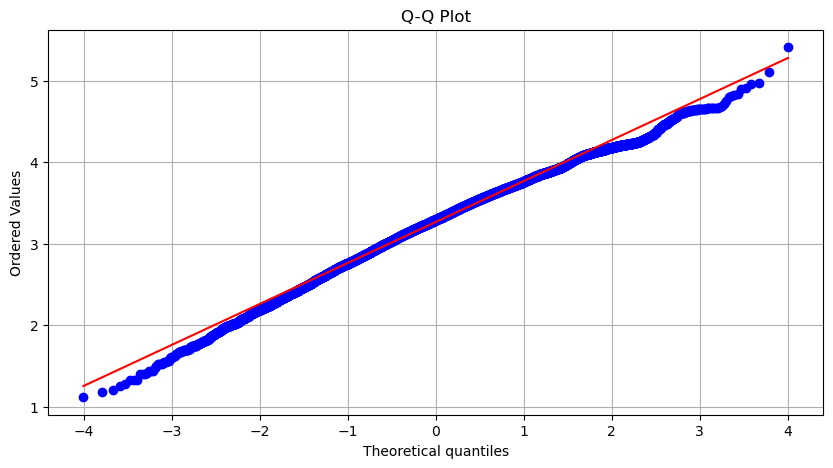

In [217]:
# Q-Q Plot
plt.figure(figsize=(10, 5))
stats.probplot(log10_qrv, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid()
plt.show()

In [218]:
kstest_test = stats.kstest(log10_qrv, 'norm')
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_test.statistic}, p-value={kstest_test.pvalue}')

Kolmogorov-Smirnov Test: Statistic=0.9675067798940865, p-value=0.0


Now let's aggregate the data well-wise...

In [219]:
well_q_agg = well_PR[['well','Qo','Qg','Qw','Qc','Qrv','operationTime']]\
.groupby(['field','well']).agg('sum')
for c in ['Qo','Qg','Qw','Qc','Qrv']:
    well_q_agg[c.lower()] = round(well_q_agg[c]/well_q_agg['operationTime'])

qrv_log10 = np.log10(well_q_agg.qrv)
fig2=px.histogram(qrv_log10, template='plotly_white',
                  title='well rates (averaged yearly and grouped by wells)')
fig2.update_layout(xaxis_title='log10(reservoir volume rate)',
                   xaxis_showgrid=True, showlegend=False, 
                   # height = 500,
                   font_size=14,
                  )
fig2.add_vline(qrv_log10.median(), 
               line={'dash': 'longdash','width': 3}, 
               annotation_text='median')
# fig2.show(renderer='browser')
fig2

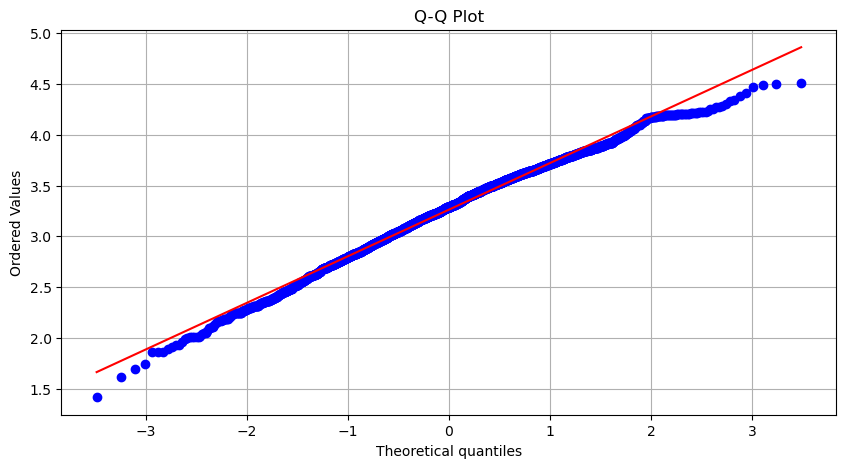

In [220]:
# Q-Q Plot
plt.figure(figsize=(10, 5))
stats.probplot(np.log10(well_q_agg.qrv), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid()
plt.show()

In [221]:
shapiro_test = stats.shapiro(np.log10(well_q_agg['qrv']))
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

Shapiro-Wilk Test: Statistic=0.9926422000934995, p-value=8.529567137377081e-11


In [222]:
kstest_test = stats.kstest(np.random.normal(size=(100,)), 'norm')
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_test.statistic}, p-value={kstest_test.pvalue}')

Kolmogorov-Smirnov Test: Statistic=0.06797194688963915, p-value=0.7186237442383681


In [223]:
# well_q_agg
# fld,v = 'AASTA HANSTEEN', 'Qrv'
# log10_v = np.log10(well_q_agg.loc[:,v])
# fig = px.histogram(log10_v, template='plotly_white')
# fig.update_layout(xaxis_title=f"log10({v})")
# fig.show(renderer='browser')

### **q_resv** averaged over well's lifetime

In [224]:
fld_q_agg = well_PR[['Qo','Qg','Qc','Qw','Qrv','operationTime']].\
groupby(['field']).agg('sum')
for c in ['Qo','Qg','Qw','Qc','Qrv']:
    fld_q_agg[c.lower()] = round(fld_q_agg[c]/fld_q_agg['operationTime'])
fld_q_agg
df['q_resv1_1'] = fld_q_agg['qrv']

In [225]:
fld_q_agg

Qo            Qg          Qc          Qw  \
field                                                              
AASTA HANSTEEN         0.0  2.620665e+10    380662.0     54428.0   
ALBUSKJELL       5734965.0  1.861957e+10         0.0   1130687.0   
ALVE             1997721.0  8.414312e+09         0.0     78496.0   
ALVHEIM         46868985.0  7.959498e+09         0.0  53541956.0   
ATLA                   0.0  1.961937e+08     37274.0      4386.0   
...                    ...           ...         ...         ...   
YME              8156753.0  3.595894e+08         0.0   2013399.0   
YTTERGRYTA             0.0  2.543324e+09    290115.0      5310.0   
ÅSGARD          64186003.0  3.631761e+11  50358511.0  12903634.0   
ÆRFUGL NORD        36995.0  3.612769e+08         0.0      1464.0   
ØST FRIGG              0.0  8.778374e+09         0.0         0.0   

                         Qrv  operationTime     qo         qg     qw     qc  \
field                                                                         
AASTA HANSTEEN  1.138335e+08    7546.883000    0.0  3472513.0    7.0   50.0   
ALBUSKJELL      6.871729e+07   67813.900000   85.0   274569.0   17.0    0.0   
ALVE            3.479838e+07    8229.924000  243.0  1022405.0   10.0    0.0   
ALVHEIM         1.296803e+08   57799.116653  811.0   137710.0  926.0    0.0   
ATLA            7.247930e+05     418.803000    0.0   468463.0   10.0   89.0   
...                      ...            ...    ...        ...    ...    ...   
YME             1.140916e+07    9517.720000  857.0    37781.0  212.0    0.0   
YTTERGRYTA      1.261824e+07     846.300000    0.0  3005228.0    6.0  343.0   
ÅSGARD          1.417132e+09  220951.837167  290.0  1643689.0   58.0  228.0   
ÆRFUGL NORD     1.647233e+06     113.100000  327.0  3194314.0   13.0    0.0   
ØST FRIGG       4.626044e+07    8159.800000    0.0  1075807.0    0.0    0.0   

                    qrv  
field                    
AASTA HANSTEEN  15084.0  
ALBUSKJELL       1013.0  
ALVE             4228.0  
ALVHEIM          2244.0  
ATLA             1731.0  
...                 ...  
YME              1199.0  
YTTERGRYTA      14910.0  
ÅSGARD           6414.0  
ÆRFUGL NORD     14564.0  
ØST FRIGG        5669.0  

[110 rows x 11 columns]

### **q_resv** only for peak year

In [226]:
fld_y_agg = well_PR[['year','Qo','Qg','Qc','Qw','Qrv','operationTime']].\
groupby(['field','year']).agg('sum')
for c in ['Qo','Qg','Qw','Qc','Qrv']:
    fld_q_agg[c.lower()] = round(fld_q_agg[c]/fld_q_agg['operationTime'])
fld_y_agg

Qo            Qg        Qc       Qw         Qrv  \
field          year                                                          
AASTA HANSTEEN 2019       0.0  6.800208e+09  126376.0  11081.0  29562542.0   
               2020       0.0  8.838974e+09  133330.0  20553.0  38400882.0   
               2021       0.0  9.033135e+09  103687.0  19403.0  39210240.0   
               2022       0.0  1.534330e+09   17269.0   3391.0   6659837.0   
ALBUSKJELL     1979  468655.0  7.640500e+08       0.0      0.0   2970471.0   
...                       ...           ...       ...      ...         ...   
ØST FRIGG      1993       0.0  1.262033e+09       0.0      0.0   6650686.0   
               1994       0.0  9.850120e+08       0.0      0.0   5190835.0   
               1995       0.0  3.189090e+08       0.0      0.0   1680593.0   
               1996       0.0  6.041760e+08       0.0      0.0   3183899.0   
               1997       0.0  9.241800e+07       0.0      0.0    487026.0   

                     operationTime  
field          year                 
AASTA HANSTEEN 2019       1780.313  
               2020       2667.143  
               2021       2638.581  
               2022        460.846  
ALBUSKJELL     1979        744.000  
...                            ...  
ØST FRIGG      1993       1172.140  
               1994        966.900  
               1995        369.950  
               1996        749.970  
               1997        543.850  

[1512 rows x 6 columns]

In [227]:
# for fld in fld_q_agg.index.get_level_values(0):
fld_y_agg['Qoe'] = fld_y_agg.Qo + fld_y_agg.Qc + fld_y_agg.Qg/1000
fld_y_agg['Qhcrv'] = fld_y_agg.Qrv - fld_y_agg.Qw # hydrocarbon res. vol.
pyear = fld_y_agg.loc[fld_y_agg.groupby(level='field')['Qhcrv'].idxmax(),:]
pyear['qrv']=pyear['Qrv']/pyear['operationTime']
pyear = pyear.reset_index().set_index('field')
df['q_resv1_2'] = pyear.qrv

fig = px.scatter(
    df, x='q_resv1_1', y='q_resv1_2', 
    hover_data=['field'])
fig=cross_plot(fig)
# fig.show(renderer='browser')
fig

Estimating correlation between two metrics ...

In [228]:
df[['q_resv1_1','q_resv1_2']].corr()

q_resv1_1  q_resv1_2
q_resv1_1   1.000000   0.888321
q_resv1_2   0.888321   1.000000

In [229]:
sdf = df[['q_resv1_1','q_resv1_2']].dropna()
xx = sdf['q_resv1_1' ].values
yy = sdf['q_resv1_2'].values
# LS_model=LinearRegression()
# LS_model.fit(X, y)
# print(f"q_resv1_2 = {LS_model.coef_[0]:f}*q_resv1_1 + {LS_model.intercept_:f} ")


In [230]:
sdf = df[['q_resv1_1','q_resv1_2']].copy().dropna()
xx = sdf['q_resv1_1' ].values
yy = sdf['q_resv1_2'].values

def ray_trend(x,p):
    return x*p

p,cov=curve_fit(ray_trend, xx, yy, 1.0)
print(f"q_resv1_2/q_resv1_1 = {p[0]:.3f}")

q_resv1_2/q_resv1_1 = 1.163


The second approach yields 19% more

In [231]:
df = df.drop(columns='q_resv1_2')
df = df.rename(columns={'q_resv1_1': 'q_resv'})

## + gas production rates for gas fields

In [232]:
fld_q_agg['q_gas']=fld_q_agg['qg']

ind=df['gas PV0/HC PV0']>0.5
df.loc[~ind,'q_gas'] = np.nan

### chart

In [233]:
fig3 = deepcopy(fig2)
fig3.update_layout(showlegend=False)
clrs = generate_rainbow_colors(10)
c = 1
for fld,clr in zip(top10.index,clrs):
    x = np.log10(df.q_resv[fld])
    fig3.add_annotation(
        x=x, y=0, ax=x, ay=10*(12-c), text=f"{c}.{fld}", 
        arrowwidth=2, showarrow=True, arrowhead=2, 
        arrowcolor=clr, font_color=clr,
        xref="x", yref="y", axref="x", ayref="y"
    )
    c += 1
# fig3.show(renderer='browser')
fig3

### using DISKOS injection data

In [234]:
# well_IR=well_inj['year','well','operationTime','gas','water']]\
# .copy().reset_index()
well_IR=well_inj[['year','well','operationTime','gas','water']].copy().reset_index()
well_IR = well_IR.fillna(0)
# well_IR=well_IR.replace(0,np.nan)
flds=well_IR['field'].unique()
# cumulatives (i.e. yearly rates)/daily rates are denoted by Q/q
well_IR=well_IR.rename(\
    columns={'gas': 'Qg', 'water': 'Qw','co2': 'Qc'})

# adding a proxy for reservoir volume production:
well_IR['Qrv']=np.nan
bw = 1
for fld in df[df.status.isin(['shut down', 'producing'])].index:
    if not fld in flds: continue
    ind = well_IR.field==fld
    bg=df.loc[fld,'gas FVF']
    # print(f'{fld}: {bg: .2e}, {gor}, {gor*bg:.2e}')
    gor=df.loc[fld,'GOR']
    well_IR.loc[ind,'Qrv'] = \
    well_IR.loc[ind,'Qg']*bg + well_IR.loc[ind,'Qw']*bw
    
    well_IR.loc[ind,'Qrv']=well_IR.loc[ind,'Qrv'].round(0)

# calculating rates
for c in ['Qg','Qw','Qrv']:
    well_IR[c.lower()] = round(well_IR[c]/well_IR['operationTime'])
well_IR=well_IR.dropna(subset='operationTime')
well_IR=well_IR.set_index('field')
# well_IR

# preliminary removal of ...
well_IR=well_IR[well_IR['operationTime']>30] # wells that didn't injected much
well_IR=well_IR[well_IR.qrv>10] # wells that injected at very small rates
well_IR = well_IR.sort_values(by=['field','year', 'well'])

In [235]:
log10_qrv=np.log10(well_IR['qrv'])
fig1 = px.histogram(log10_qrv, template='plotly_white')
fig1.update_layout(xaxis_title='log10(reservoir volume rate)',
                   xaxis_showgrid=True)

log10_qrv_mean=log10_qrv.mean()
log10_qrv_std=log10_qrv.std()
log10_qrv_median=log10_qrv.median()

fig1.add_vline(log10_qrv_mean, line={'dash': 'longdash'}, 
               annotation_text='mean')
fig1.add_vline(log10_qrv_median, line={'dash': 'longdashdot'}, 
               annotation_text='median')
fig1.add_vline(log10_qrv_mean - 3*log10_qrv_std, line={'dash': 'dash'},
              annotation_text='mean-3std')
fig1.add_vline(log10_qrv_mean + 3*log10_qrv_std, line={'dash': 'dash'},
              annotation_text='mean+3std')
# fig1.show(renderer='browser')
fig1

removing entries less\greater than mean+/-3std

In [236]:
# ind = (well_IR['qrv'] > 10**(log10_qrv_mean - 3*log10_qrv_std)) & \
# (well_IR['qrv'] < 10**(log10_qrv_mean + 3*log10_qrv_std))
ind = (well_IR['qrv'] < 10**(log10_qrv_mean + 3*log10_qrv_std))
well_IR_ = well_IR.copy()
well_IR = well_IR[ind]
well_IR_[~ind]

year           well  operationTime            Qg          Qw  \
field                                                                   
BALDER   2001   25/11-C-12 H         171.30  0.000000e+00  37584430.0   
DRAUGEN  2014   6407/9-C-2 H          30.60  0.000000e+00   2413398.0   
GRANE    2014   25/11-G-20 A         118.90  1.406607e+09         0.0   
ÅSGARD   2015  6506/12-R-2 H          30.34  1.195034e+09         0.0   

                Qrv          qg        qw       qrv  
field                                                
BALDER   37584430.0         0.0  219407.0  219407.0  
DRAUGEN   2413398.0         0.0   78869.0   78869.0  
GRANE     8379611.0  11830171.0       0.0   70476.0  
ÅSGARD    4291573.0  39388081.0       0.0  141449.0

In [237]:
well_IR_[well_IR_['well']=='6407/9-C-2 H']

year          well  operationTime   Qg         Qw        Qrv   qg  \
field                                                                        
DRAUGEN  2000  6407/9-C-2 H        335.250  0.0  3749022.0  3749022.0  0.0   
DRAUGEN  2001  6407/9-C-2 H        117.710  0.0  3470690.0  3470690.0  0.0   
DRAUGEN  2002  6407/9-C-2 H        332.410  0.0  3449898.0  3449898.0  0.0   
DRAUGEN  2003  6407/9-C-2 H        269.600  0.0  2743127.0  2743127.0  0.0   
DRAUGEN  2004  6407/9-C-2 H        343.730  0.0  3544683.0  3544683.0  0.0   
DRAUGEN  2005  6407/9-C-2 H        271.540  0.0  2759900.0  2759900.0  0.0   
DRAUGEN  2006  6407/9-C-2 H         81.220  0.0   842242.0   842242.0  0.0   
DRAUGEN  2007  6407/9-C-2 H        318.670  0.0  3244254.0  3244254.0  0.0   
DRAUGEN  2008  6407/9-C-2 H        349.170  0.0  3463521.0  3463521.0  0.0   
DRAUGEN  2009  6407/9-C-2 H        325.420  0.0  3477414.0  3477414.0  0.0   
DRAUGEN  2010  6407/9-C-2 H        320.560  0.0  3361944.0  3361944.0  0.0   
DRAUGEN  2011  6407/9-C-2 H        243.920  0.0  2565923.0  2565923.0  0.0   
DRAUGEN  2012  6407/9-C-2 H        288.560  0.0  2880111.0  2880111.0  0.0   
DRAUGEN  2014  6407/9-C-2 H         30.600  0.0  2413398.0  2413398.0  0.0   
DRAUGEN  2015  6407/9-C-2 H        125.540  0.0  2823287.0  2823287.0  0.0   
DRAUGEN  2016  6407/9-C-2 H        228.109  0.0  2452258.0  2452258.0  0.0   
DRAUGEN  2017  6407/9-C-2 H        310.495  0.0  2908329.0  2908329.0  0.0   
DRAUGEN  2018  6407/9-C-2 H        303.684  0.0  2747809.0  2747809.0  0.0   
DRAUGEN  2019  6407/9-C-2 H        317.312  0.0  2698194.0  2698194.0  0.0   
DRAUGEN  2020  6407/9-C-2 H        316.890  0.0  2751558.0  2751558.0  0.0   
DRAUGEN  2021  6407/9-C-2 H        332.353  0.0  2907666.0  2907666.0  0.0   
DRAUGEN  2022  6407/9-C-2 H         55.312  0.0   461778.0   461778.0  0.0   

              qw      qrv  
field                      
DRAUGEN  11183.0  11183.0  
DRAUGEN  29485.0  29485.0  
DRAUGEN  10378.0  10378.0  
DRAUGEN  10175.0  10175.0  
DRAUGEN  10312.0  10312.0  
DRAUGEN  10164.0  10164.0  
DRAUGEN  10370.0  10370.0  
DRAUGEN  10181.0  10181.0  
DRAUGEN   9919.0   9919.0  
DRAUGEN  10686.0  10686.0  
DRAUGEN  10488.0  10488.0  
DRAUGEN  10520.0  10520.0  
DRAUGEN   9981.0   9981.0  
DRAUGEN  78869.0  78869.0  
DRAUGEN  22489.0  22489.0  
DRAUGEN  10750.0  10750.0  
DRAUGEN   9367.0   9367.0  
DRAUGEN   9048.0   9048.0  
DRAUGEN   8503.0   8503.0  
DRAUGEN   8683.0   8683.0  
DRAUGEN   8749.0   8749.0  
DRAUGEN   8349.0   8349.0

In [238]:
well_IR_[well_IR_['well']=='25/11-G-20 A']

year          well  operationTime            Qg   Qw        Qrv  \
field                                                                    
GRANE  2004  25/11-G-20 A        222.060  5.164970e+08  0.0  3076938.0   
GRANE  2005  25/11-G-20 A        319.010  9.521730e+08  0.0  5672400.0   
GRANE  2006  25/11-G-20 A        340.120  1.253892e+09  0.0  7469837.0   
GRANE  2007  25/11-G-20 A        355.230  1.315560e+09  0.0  7837213.0   
GRANE  2008  25/11-G-20 A        350.000  1.240761e+09  0.0  7391611.0   
GRANE  2009  25/11-G-20 A        337.950  1.356315e+09  0.0  8080003.0   
GRANE  2010  25/11-G-20 A        356.320  1.359672e+09  0.0  8100002.0   
GRANE  2011  25/11-G-20 A        309.270  1.209633e+09  0.0  7206172.0   
GRANE  2012  25/11-G-20 A        255.123  1.014430e+09  0.0  6043284.0   
GRANE  2013  25/11-G-20 A        340.883  1.045620e+09  0.0  6229092.0   
GRANE  2014  25/11-G-20 A        118.900  1.406607e+09  0.0  8379611.0   
GRANE  2015  25/11-G-20 A        248.330  1.124981e+09  0.0  6701871.0   
GRANE  2016  25/11-G-20 A        359.819  1.016817e+09  0.0  6057507.0   
GRANE  2017  25/11-G-20 A        348.911  8.899230e+08  0.0  5301556.0   
GRANE  2018  25/11-G-20 A        342.016  9.577628e+08  0.0  5705700.0   
GRANE  2019  25/11-G-20 A        359.173  9.688370e+08  0.0  5771673.0   
GRANE  2020  25/11-G-20 A        362.570  9.924470e+08  0.0  5912325.0   
GRANE  2021  25/11-G-20 A        358.246  9.195152e+08  0.0  5477847.0   
GRANE  2022  25/11-G-20 A         56.929  1.290326e+08  0.0   768688.0   

               qg   qw      qrv  
field                            
GRANE   2325934.0  0.0  13856.0  
GRANE   2984775.0  0.0  17781.0  
GRANE   3686616.0  0.0  21962.0  
GRANE   3703403.0  0.0  22062.0  
GRANE   3545031.0  0.0  21119.0  
GRANE   4013360.0  0.0  23909.0  
GRANE   3815873.0  0.0  22732.0  
GRANE   3911252.0  0.0  23301.0  
GRANE   3976238.0  0.0  23688.0  
GRANE   3067386.0  0.0  18273.0  
GRANE  11830171.0  0.0  70476.0  
GRANE   4530185.0  0.0  26988.0  
GRANE   2825914.0  0.0  16835.0  
GRANE   2550573.0  0.0  15195.0  
GRANE   2800345.0  0.0  16683.0  
GRANE   2697410.0  0.0  16069.0  
GRANE   2737256.0  0.0  16307.0  
GRANE   2566715.0  0.0  15291.0  
GRANE   2266552.0  0.0  13503.0

In [239]:
fld_qi_agg = well_IR[['Qg','Qw','Qrv','operationTime']].\
groupby(['field']).agg('sum')
for c in ['Qg','Qw','Qrv']:
    fld_qi_agg[c.lower()] = round(fld_qi_agg[c]/fld_qi_agg['operationTime'])
fld_qi_agg
df['qi_resv'] = fld_qi_agg['qrv']
df['qi_w'] = fld_qi_agg['qw']
df['qi_gas'] = fld_qi_agg['qg']

## approach 2
using well count and field net prod. rates at the peak

### for gas fields

In [240]:
df['q_gas2'] = None
for f in df[df['gas PV0/HC PV0']>0.5].index:
    wdf=well_count_dict.get(f)
    if wdf is None: 
        print(f'{f} not found!')
        continue

    y,pr=df.loc[f,['peak year','peak gas YPR']] # Bsm3
    if y==date.today().year: y -= 1
    nw=wdf.loc[y,'gas prod.']
    # nw=wdf.loc[y,'prod.']

    q_gas2 = round(pr/nw/365*1000,2)
    df.loc[f,'q_gas2']=q_gas2 # Bsm3/year => Msm3/day
    print(f'{f}: gp/nw={pr}/{nw:.1f}={q_gas2:.2}')

sc=df.q_gas2.mean()
print(f'average q_gas2={sc: .2e} sm3/day')
# df.q_gas2 = df.q_gas2/sc
# df.q_gas2 = df.q_gas2.round(2)

ALBUSKJELL: gp/nw=2.249/16.6=0.37
ALVE: gp/nw=0.9/0.9=2.6
ALVE NORD not found!
ATLA: gp/nw=0.465/1.0=1.3
BERLING not found!
COD: gp/nw=0.843/6.0=0.38
DUVA: gp/nw=0.699/1.0=1.9
DVALIN: gp/nw=0.845/4.0=0.58
FENRIS not found!
FLYNDRE not found!
FRIGG: gp/nw=10.928/47.0=0.64
FULLA not found!
GINA KROG: gp/nw=2.811/2.0=3.9
GJØA: gp/nw=3.886/3.0=3.5
GULLFAKS SØR: gp/nw=5.907/12.0=1.4
GUNGNE: gp/nw=0.0/2.0=0.0
HALTEN ØST not found!
HEIMDAL: gp/nw=4.569/10.0=1.2
HULDRA: gp/nw=2.958/6.0=1.4
IDUN NORD not found!
IRPA not found!
KRISTIN: gp/nw=3.94/11.7=0.92
KVITEBJØRN: gp/nw=6.979/11.1=1.7
LILLE-FRIGG: gp/nw=0.609/4.0=0.42
MARTIN LINGE: gp/nw=2.628/9.6=0.75
MARULK: gp/nw=1.288/2.0=1.8
MIKKEL: gp/nw=1.85/3.0=1.7
MUNIN not found!
NORDØST FRIGG: gp/nw=2.228/6.0=1.0
ODIN: gp/nw=3.549/10.9=0.89
ORMEN LANGE: gp/nw=22.203/16.1=3.8
REV: gp/nw=1.129/3.0=1.0
SIGYN: gp/nw=0.913/2.0=1.2
SKARV: gp/nw=6.531/11.0=1.6
SKIRNE: gp/nw=1.277/2.0=1.8
SLEIPNER VEST: gp/nw=3.1/11.5=0.74
SLEIPNER ØST: gp/nw=13.481/16.3

### via reservoir volume

In [241]:
df['q_resv2'] = None
fld_ypr2=fld_ypr2.reset_index()
for f in df[df.status.isin(['shut down', 'producing'])].index:
    
    wdf=well_count_dict.get(f)
    if wdf is None: 
        print(f'{f} not found!')
        continue
    
    sdf=fld_ypr2[fld_ypr2.field==f].copy().reset_index()
    if sdf.empty: continue # to exclude fields that has just come online
    
    sdf['resv']=\
    sdf['oil YPR']*(df.loc[f,'oil FVF']) +\
    1000*sdf['gas YPR']*df.loc[f,'gas FVF'] +\
    sdf['water YPR']  # assuming water's FVF==1
    if not pd.isna(df.loc[f,'GOR']):
        sdf['resv'] -= sdf['oil YPR']*df.loc[f,'GOR']*df.loc[f,'gas FVF']

    # finding the year with highest res. volume production
    y,pr=sdf.loc[sdf.resv.idxmax(),['year','resv']] # Msm3
    if pd.isna(y): continue # to exclude fields that has just come online
    if y==date.today().year: y -= 1
    
    nw=wdf.loc[y,'prod.'] # number of wells
    # print(f'{f}: pr/nw={pr}/{nw}')
    df.loc[f,'q_resv2']=round(1e+6*pr/nw/365,0) # Mrm3/year => rm3/day
    
# normalizing
sc = df.q_resv2.mean()
print(f'average q_resv2={sc: .2e} rm3/day')
# df.q_resv2 = df.q_resv2/sc

# ind=~df['q_resv2'].isna()
# df.loc[ind,'q_resv2']=df.loc[ind,'q_resv2'].round(2)
df['q_resv2'] = df['q_resv2'].apply(lambda x: np.round(x,2) if pd.notnull(x) else np.nan)
fld_ypr2=fld_ypr2.set_index('field')

ENOCH not found!
FLYNDRE not found!
HANZ not found!
MIME not found!
TOMMELITEN A not found!
average q_resv2= 2.89e+03 rm3/day


In [242]:
fld_ypr2

year  oil YPR  gas YPR  OE YPR  water YPR     fldID
field                                                                   
16/1-12 Troldhaugen  2021    0.000    0.007   0.007      0.032  17196400
16/1-12 Troldhaugen  2022    0.008    0.014   0.022      0.162  17196400
16/1-12 Troldhaugen  2023    0.049    0.011   0.060      0.106  17196400
16/1-12 Troldhaugen  2024    0.014    0.003   0.017      0.031  17196400
33/9-6 DELTA         2009    0.010    0.000   0.010      0.011     44576
...                   ...      ...      ...     ...        ...       ...
AASTA HANSTEEN       2020    0.192    8.749   8.941      0.021  23395946
AASTA HANSTEEN       2021    0.172    8.920   9.092      0.019  23395946
AASTA HANSTEEN       2022    0.185    8.890   9.075      0.021  23395946
AASTA HANSTEEN       2023    0.148    6.939   7.087      0.018  23395946
AASTA HANSTEEN       2024    0.055    2.548   2.603      0.007  23395946

[2220 rows x 6 columns]

## comparisons

In [243]:
df.loc['HOD',['q_resv','q_resv2']]

q_resv      739.0
q_resv2    1579.0
Name: HOD, dtype: object

In [244]:
df.loc['HOD',['q_resv','q_resv2']]

q_resv      739.0
q_resv2    1579.0
Name: HOD, dtype: object

In [245]:
df.loc['VALHALL',['q_resv','q_resv2']]

q_resv     617.0
q_resv2    283.0
Name: VALHALL, dtype: object

In [246]:
df.loc['FRIGG',['q_resv','q_resv2']]

q_resv     6694.0
q_resv2    3511.0
Name: FRIGG, dtype: object

In [247]:
# fig=px.scatter(df,x='q_resv',y='q_resv2',
#                # hover_data=['field']
#               )
# fig=cross_plot(fig)
# fig.show(renderer='browser')

In [248]:
# fig=px.scatter(df,x='q_gas',y='q_gas2',
#                hover_data=['field'])
# fig=cross_plot(fig)
# fig.show(renderer='browser')

In [249]:
# df[['reservoir','depth','recovery']].to_csv('./data/NOD/formations.csv')

## checking cross-correlation

In [252]:
df[['q_resv','gas PV0/HC PV0']].corr()

q_resv  gas PV0/HC PV0
q_resv          1.000000        0.610438
gas PV0/HC PV0  0.610438        1.000000

In [251]:
df.columns

Index(['rec. oil', 'sea', 'rec. gas', 'rec. ass. liq.', 'rec. OE', 'rem. oil',
       'rem. gas', 'rem. ass. liq.', 'rem. OE', 'STOIIP', 'GIIP', 'GOR',
       'in-place ass. liquid', 'in-place ass. gas', 'in-place free gas',
       'in-place OE', 'in-place liq./OE ratio', 'in-place free gas/OE ratio',
       'RF oil', 'RF gas', 'RF liq.', 'maturity oil', 'maturity gas',
       'maturity OE', 'maturity liq.', 'field', 'HPHT', 'res. quality',
       'faulted', 'reservoir', 'recovery', 'operator', 'PL/BAA', 'HC type',
       'status', 'FactPageUrl', 'group', 'formation', 'lithology', 'peak year',
       'peak oil YPR', 'peak gas YPR', 'peak OE YPR', 'water YPR', 'fldID',
       'rem. OE prod. years', 'well num', 'prod. num', 'inj. num', 'obs. num',
       'lat', 'lon', 'water depth', 'depth', 'depth median', 'depth mean',
       'depth min', 'depth max', 'T0', 'p_h', 'p0', 'p0 checked', 'grad_p0',
       'oil FVF', 'gas FVF', 'oil PV0', 'gas PV0', 'HCPV0', 'gas PV0/HC PV0',
       'rec. o

# postproc / saving / export

reordering the columns

In [249]:
df_ = df.copy() # backing up before many changes

In [250]:
df = df_.copy() # for back-compartability
# to prettify the columns in the app and provide tool tips
FANCY_CLMNS = {
    'field': ["", "field"],
    '#': ["", "#"],
    'sea': ["overview", "sea"],    
    'status':  ["overview", "status"],
    'HC type':  ["overview", "HC type"],
    'PL/BAA':  ["overview", "PL/BAA"],
    'operator':  ["overview", "operator"],
    'HPHT':  ["overview", "HPHT"],
    # 'res. quality':  ["overview", "reservoir quality"],
    # 'faulted':  ["overview", "faulted"],
    'reservoir':   ["overview", "reservoir"],
    'group':   ["overview", "group"],  
    'formation':   ["overview", "formation"],    
    'lithology':   ["overview", "lithology"],        
    'recovery':    ["overview", "recovery strategy"],
    'FactPageUrl': ["overview", "URL"],    
    
    'rec. oil':    ["initial reserves", "oil","Msm3"],
    'rec. gas':    ["initial reserves", "gas","Bsm3"],
    'rec. ass. liq.': ["initial reserves", "ass. liq.", "Msm3"],
    'rec. OE':     ["initial reserves", "OE", "Msm3"],

    'rem. oil':    ["remaining reserves", "oil","Msm3"],
    'rem. gas':    ["remaining reserves", "gas","Bsm3"],
    'rem. ass. liq.': ["remaining reserves", "ass. liq.","Msm3"],
    'rem. OE':     ["remaining reserves", "OE","Msm3"],
    'rem. OE prod. years': ["remaining reserves",'lifetime',"years"],   

    'STOIIP':      ["initial in-place volumes", "oil", "Msm3"],
    'GIIP':        ["initial in-place volumes", "gas", "Bsm3"],
    'in-place ass. liquid':  ["initial in-place volumes", "oil", "Msm3"],
    'in-place ass. gas':  ["initial in-place volumes", "ass. gas", "Bsm3"],
    'in-place free gas':  ["initial in-place volumes", "free gas", "Bsm3"],
    # 'in-place liq.':  ["initial in-place volumes", "liquids", "Msm3"],    
    'in-place OE':  ["initial in-place volumes", "OE", "Msm3"],
    'in-place liq./OE ratio':  ["initial in-place volumes", "liquids/OE","-"],
    'in-place free gas/OE ratio': ["initial in-place volumes", "free gas/OE","-"],

    'RF oil':  ["recovery factor", "oil","-"],
    'RF liq.':  ["recovery factor", "liq.","-"],
    'RF gas':  ["recovery factor", "gas","-"],

    'maturity oil':   ["maturity", "oil","-"],
    'maturity gas':   ["maturity", "gas","-"],
    'maturity liq.':  ["maturity", "liq.","-"],
    'maturity OE':    ["maturity", "OE","-"],

    'peak year':    ["peak yearly production", "year"],
    'peak OE YPR':  ["peak yearly production", "OE", "Msm3"],
    'peak oil YPR': ["peak yearly production", "oil", "Msm3"],
    'peak gas YPR': ["peak yearly production", "gas", "Bsm3"],
    # 'water YPR': ["peak yearly production", "water", "Msm3"],

    'well num':   ["wells", "sum"],
    'prod. num':  ["wells", "prod."],
    'inj. num':   ["wells", "inj."],
    'obs. num':   ["wells", "obs."],

    'lat':  ["coordinates", "lat"],
    'lon':  ["coordinates", "lon"],
    
    'depth min':   ["depth", "min","m"],
    'depth mean':  ["depth", "mean","m"],
    'depth median':  ["depth", "median","m"], 
    'depth max':   ["depth", "max","m"],
    'water depth': ["depth","water", "m"],
    'depth':   ["res. estimates", "depth","m"],
    'p_h':     ["res. estimates", "p_h","bar"],
    'p0':     ["res. estimates", "p0","bar"],
    'grad_p0': ["res. estimates", "grad p0","bar/km"],
    'p0 checked': ["res. estimates", "p0 checked","-"],    
    'T0':    ["res. estimates", "T0","degC"],
    'GOR':     ["res. estimates", "GOR","sm3/sm3"],    
    'oil FVF': ["res. estimates", "oil FVF","rm3/sm3"],
    'gas FVF': ["res. estimates", "gas FVF","rm3/sm3"],      
    
    'oil PV0': ["initial PV","oil", 'Mrm3'],
    'gas PV0': ["initial PV","gas", 'Mrm3'],
    'HCPV0': ["initial PV","HC", 'Mrm3'],    
    'gas PV0/HC PV0': ["initial PV","gas/HC",'-'],    
    
    'rec. oil PV':["released PV0","oil","Mrm3"],
    'rec. gas PV':["released PV0","gas","Mrm3"],
    'rec. HCPV':  ["released PV0","HCPV","Mrm3"],    
    
    'CO2 SC': ['storage capacity ind.','CO2','Mt'],
    'H2 SC':  ['storage capacity ind.','H2','Mt'],
    'CO2 SC/well num':  ['CO2 SC/well',"",'Mt/well'],
    'CO2 density RC':   ['CO2 density',"",'kg/rm3'],
    
    'q_resv':  ['injectivity ind.', 'q_resv',  'rm3/day'], 
    'qi_resv': ['injectivity ind.', 'qi_resv', 'rm3/day'], 
    'q_gas':   ['injectivity ind.', 'q_gas',   'sm3/day'], 
    'qi_gas':  ['injectivity ind.', 'qi_gas',  'sm3/day'], 
    'q_gas2':  ['injectivity ind.','q_gas2', 'sm3/day'], 
    'q_resv2': ['injectivity ind.','q_resv2','rm3/day'],  
    'total score': ["total", "score","-"],
}

df['#'] = range(df.shape[0])
df['total score'] = 0.0
df = df.infer_objects(copy=False)
numcols = df.select_dtypes(include=['number','bool']).columns
df[numcols] = df[numcols].fillna(np.nan)

priority_columns = [i for i in FANCY_CLMNS if i in df.columns]     
other_columns = [col for col in df.columns if col not in priority_columns]
# Combine the lists, with priority columns first, then others
# new_column_order = priority_columns + other_columns
new_column_order = priority_columns # drops other columns

df = df[new_column_order]

all_clmns = {i: ["", i, ""] for i in df.columns}
all_clmns = {**all_clmns, **FANCY_CLMNS}

# enumerating columns
for n,i in enumerate(all_clmns):
    foo = all_clmns[i]
    if len(foo)==2: foo.append("") 
    foo.append(str(n+1))

with open(r'./assets/_main_columns.json', 'w') as f:
    json.dump(FANCY_CLMNS, f, indent=1)

for i in ['depth','depth min','depth mean','depth median','depth max','water depth']:
    df[i]=df[i].round(1)

for i in ['in-place ass. liquid',\
          'in-place ass. gas','in-place free gas',\
          'in-place OE','in-place liq./OE ratio',\
          'rec. oil', 'rec. gas', 'rec. ass. liq.',
          'rec. OE', 'rem. oil', 'rem. gas', 
          'rem. ass. liq.', 'rem. OE',
          'oil PV0', 'gas PV0', 'HCPV0', 
          'gas PV0/HC PV0', 'rec. oil PV', 'rec. gas PV',
          'rec. HCPV', 'CO2 SC', 'H2 SC',
         ]:
    # df.loc[~df[i].isna(),i]=df.loc[~df[i].isna(),i].round(3)
    df[i]=df[i].round(2)

df['CO2 density RC'] = df['CO2 density RC'].round(0)
df['peak oil YPR'] = df['peak oil YPR'].round(3)
df['peak gas YPR'] = df['peak gas YPR'].round(3)

if 'field' in df.columns:
    df=df.drop(columns=['field'])
# this line drops a few field which are mostly in the UK
# df=df.dropna(subset='depth') 
df.to_csv(f'./data/_main.csv')

In [251]:
for i in df.columns:
    if not i in FANCY_CLMNS:
        print(i)

## generating help for columns and markdown draft

In [252]:
HELP_CLMNS={
    'field': "field name",
	'#': "entry number",
    'sea': "sea where the field is located: North, Norwegian, or Barents",
    'status': "current status of the field: producing, shut-down, or approved for production",
    'HC type': "type of hydrocarbons",
    'PL/BAA': "production license or block area agreement",
    'operator': "company operating the field",
    
    'HPHT': "indicates if the field is high pressure/high temperature",

    # 'res. quality': "quality of the reservoir",
    # 'faulted': "indicates if the field is faulted",
    'reservoir': "description of the reservoir",
    'group': 'lithostratigraphical groups',
    'formation': 'geological formation(s). Group name(s) are used if formation is not available',    
    'lithology': 'dominant type of formation minerals',    
    'recovery': "description of the recovery strategy",
    'FactPageUrl': "URL to the field's fact page",    
    
    'rec. oil': "initial recoverable oil, million standard cubic meters (Msm3)",
    'rec. gas': "initial recoverable gas, billion standard cubic meters (Bsm3)",
    'rec. ass. liq.': "initial recoverable associated liquids, million standard cubic meters (Msm3)",
    'rec. OE': "initial recoverable oil equivalent, million standard cubic meters (Msm3)",

    'rem. oil': "remaining recoverable oil, million standard cubic meters (Msm3)",
    'rem. gas': "remaining recoverable gas, billion standard cubic meters (Bsm3)",
    'rem. ass. liq.': "remaining recoverable associated liquids (Msm3)",
    'rem. OE': "remaining recoverable oil equivalent (Msm3)",
    'rem. OE prod. years': "remaining production years, ratio of current remaining volume to current production",

    'STOIIP': "stock tank oil initially in place, Msm3",
    'GIIP': "gas initially in place, Bsm3",
    'in-place ass. liquid': "in-place associated liquid in Msm3",
    'in-place ass. gas': "in-place associated gas in Bsm3",
    'in-place free gas': "in-place free gas in Bsm3",
    'in-place OE': "in-place oil equivalent in Msm3",
    'in-place liq./OE ratio': "ratio of in-place liquids to oil equivalent",
    'in-place free gas/OE ratio': "ratio of in-place free gas to oil equivalent",

    'RF oil': "recovery factor for oil",
    'RF liq.': "recovery factor for liquids",
    'RF gas': "recovery factor for gas",

    'maturity oil': "maturity of oil production, ratio of the produced oil volume to the original recoverable volume (fraction)",
    'maturity gas': "maturity of gas production, ratio of the produced gas volume to the original recoverable volume (fraction)",
    'maturity liq.': "maturity of liquid production, ratio of the produced liquid (oil+gas liquids) volume to the original recoverable volume (fraction)",
    'maturity OE': "maturity, ratio of the produced volume to the original recoverable volume expressed in oil equivalent (fraction)",

    'peak year': "year of peak production",
    'peak OE YPR': "peak yearly oil equivalent production in Msm3",
    'peak oil YPR': "peak yearly oil production in Msm3",
    'peak gas YPR': "peak yearly gas production in Msm3",

    'well num': "total number of wells",
    'prod. num': "number of production wells",
    'inj. num': "number of injection wells",
    'obs. num': "number of observation wells",

    'lat': "decimal latitude  coordinate",
    'lon': "decimal longitude coordinate",
    
    'depth min': "minimum depth (below sea level) estimated from available wells (m)",
    'depth mean': "mean depth (below sea level) estimated from available wells (m)",
    'depth median': "median depth (below sea level) estimated from available wells (m)",
    'depth max': "maximum depth (below sea level) estimated from available wells (m)",
    'water depth': "estimated field water depth (m)",
    'depth': "estimated depth (m) used for varios calculations (hydrostatic pressure, reservoir temperature etc.)",
    'p_h': "estimate of hydrostatic pressure (bar)",
    'p0': "initial reservoir pressure estimate (bar)",
    'grad_p0': "initial pressure gradient calculated as *(p0-1)/depth* (bar/km)",
    'p0 checked': "indicates if pressure was verified/refined by data from exploration well(s) or literature. If False => hydrostatic pressure estimate p0=p_h",
    'T0': "initial reservoir temperature estimate (degC)",
    'GOR': "gas-to-oil ratio (sm3/sm3)",
    'oil FVF': "oil formation volume factor (rm3/sm3)",
    'gas FVF': "gas formation volume factor (rm3/sm3)",

    'oil PV0': "initial oil pore volume, million cubic meters (Mrm3)",
    'gas PV0': "initial gas pore volume, million cubic meters (Mrm3)",
    'HCPV0': "initial hydrocarbon pore volume, million cubic meters (Mrm3)",
    'gas PV0/HC PV0': "estimated ratio of initial gas pore volume to total hydrocarbon pore volume (fraction)",

    'rec. oil PV': "recoverable oil pore volume (Mrm3)",
    'rec. gas PV': "recoverable gas pore volume (Mrm3)",
    'rec. HCPV': "recoverable hydrocarbon pore volume (Mrm3)",

    'CO2 SC': "CO2 storage capacity indicator (million tonnes, Mt)",
    'H2 SC': "hydrogen storage capacity indicator (million tonnes, Mt)",
    'CO2 SC/well num': "CO2 storage capacity per well (Mt/well)",
    'CO2 density RC': "CO2 density under reservoir conditions (kg/rm3)",

    'q_resv': "reservoir injectivity indicator (rm3/day) based on well production rates from the DISKOS database at the peak level", 
    'qi_resv': "reservoir injectivity indicator (rm3/day)", 
    'q_gas': "gas injectivity indicator (sm3/day)", 
    'qi_gas': "initial gas injectivity indicator (sm3/day)",
    'q_gas2': "secondary gas injectivity indicator (sm3/day)", 
    'q_resv2': "secondary reservoir injectivity indicator (rm3/day) based on field production profile and well count at the peak level",

    "total score": "aggregated indicator, calculated as a weighted sum of other parameters in TOTAL SCORE tab (-)",
}

with open(r'./assets/_help_columns.json', 'w') as file:
    json.dump(HELP_CLMNS, file, indent=4)